In [5]:
import os
import re
import csv
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter, freqz

#Comment these out if you are not using PyVHR
import pyVHR as vhr
from pyVHR.BVP import * 
vhr.plot.VisualizeParams.renderer = 'notebook' #Comment this out if you are not using PyVHR

In [7]:
#Functions and global variables are defined in this cell

FIG_WIDTH = 3  # inches
FIG_HEIGHT = 3  # inches
FONT_SIZE = 6
DPI = 300  

def create_box_plots(grouped_values, group_names, y_label, title=None, sharey=False):
    
    """
    Create box swarm plots of one or more distribution.

    Args:
    - grouped_values: A list of data arrays to plot.
    - group_names: A list of group names corresponding to the data arrays.
    - y_label: Label(s) for the y-axis. If sharey=False, this should be a list of labels.
    - title: Title for the plot (optional).
    """

    # Check if the right number of y-labels are provided
    if not sharey and len(y_label) != len(grouped_values):
        raise ValueError("Number of y_labels should match the number of box plots if sharey is set to False")

    sns.set_context("paper", rc={"font.size": FONT_SIZE, "axes.titlesize": FONT_SIZE, "axes.labelsize": FONT_SIZE})
    plt.rcParams["figure.dpi"] = DPI
    plt.rcParams["figure.figsize"] = (FIG_WIDTH, FIG_HEIGHT)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(grouped_values), sharey=sharey)

    # If only one subplot, make axes a list for consistent indexing
    if len(grouped_values) == 1:
        axes = [axes]

    # Create a list to store the data used for the plots
    data_used_for_plots = []

    # Loop through each subplot
    for i, (values, group_name) in enumerate(zip(grouped_values, group_names)):
        ax = sns.boxplot(ax=axes[i], y=values, showfliers=True, whis=(0, 100), color='w')
        ax = sns.swarmplot(ax=axes[i], y=values, color=".25", marker="x", linewidth=1, size=1)
        ax.set_title('')
        ax.set_xlabel(group_name)

        # Set y-label
        if sharey:
            axes[0].set_ylabel(y_label, fontsize = FONT_SIZE)
        else:
            axes[i].set_ylabel(y_label[i], fontsize = FONT_SIZE)

        # Append the data for this group to the list
        data_used_for_plots.append({'Group': group_name, 'Mean_ISC': values})

    # Add a common title
    if title:
        plt.suptitle(title)
        
    # Display the plot
    plt.tight_layout()

def extract_hr_es_data(file_location):
    
    """
    Extract the HR data from the output of PyVHR.

    Args:
    - file_location: Directory for the output file
    
    Returns:
    - folder_name: Name of the folder the file is in, which should be the participant ID
    - hr_es: HR data from PyVHR output file
    """
    
    folder_name = os.path.basename(os.path.dirname(file_location))
    # Read the data from the second column of the text file
    hr_es = np.load(file_location)

    return folder_name, hr_es

def find_hr_es_files(directory, identifier = "second_pass"):
    
    """
    Find the HR files produced by PyVHR

    Args:
    - directory: Top level folder to search for files within.
    - identifier: All relevant files should have '_hr_es_med' in the name plus some identifier.
    
    Returns:
    - hr_files: List of locations of the PyVHR output files. 
    
    """
        
    hr_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "_hr_es_med_" + identifier in file and not file.startswith('.'):
                file_path = os.path.join(root, file)
                hr_files.append(file_path)

    return hr_files

def remove_baseline_wander(ecg_signal, sampling_rate = 130, cutoff_freq=0.5):
    """
    Remove baseline wander from an ECG signal using high-pass filtering.

    Args:
    - ecg_signal: The ECG signal as a 1D numpy array.
    - sampling_rate: The sampling rate of the ECG signal in Hz.
    - cutoff_freq: The cutoff frequency for high-pass filtering in Hz (default: 0.5 Hz).

    Returns:
    - filtered_ecg: The ECG signal with baseline wander removed.
    """
    # Design a high-pass Butterworth filter
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(1, normal_cutoff, btype='high', analog=False)

    # Apply the high-pass filter to remove baseline wander
    filtered_ecg = lfilter(b, a, ecg_signal)

    return filtered_ecg

def filter_ecg_signal(ecg_signal, sampling_rate = 130, low_cutoff_freq=15, high_cutoff_freq=50.0):
    """
    Filter an ECG signal using a band-pass filter.

    Args:
    - ecg_signal: The ECG signal as a 1D numpy array.
    - sampling_rate: The sampling rate of the ECG signal in Hz.
    - low_cutoff_freq: The low cutoff frequency for the band-pass filter in Hz (default: 0.5 Hz).
    - high_cutoff_freq: The high cutoff frequency for the band-pass filter in Hz (default: 50.0 Hz).

    Returns:
    - filtered_ecg: The filtered ECG signal.
    """
    # Design a band-pass Butterworth filter
    nyquist_freq = 0.5 * sampling_rate
    low_cutoff = low_cutoff_freq / nyquist_freq
    high_cutoff = high_cutoff_freq / nyquist_freq
    b, a = butter(1, [low_cutoff, high_cutoff], btype='band', analog=False)

    # Apply the band-pass filter
    filtered_ecg = lfilter(b, a, ecg_signal)

    return filtered_ecg

def extract_ecg_data(file_location):
    
    """
    Extract the ECG data from the Polar H10 recording file.

    Parameters:
    - file_location: Directory for the ECG recording file
    """
    
    folder_name = os.path.basename(os.path.dirname(file_location))
    # Read the data from the second column of the text file
    df = pd.read_csv(file_location, delimiter=';', usecols=[3])
    column_data = df.iloc[:, 0].to_numpy()

    return folder_name, column_data

def find_ecg_trunc_files(directory):
    
    """
    Find the ECG files recorded by Polar H10.

    Parameters:
    - directory: Top level folder to search for files within.
    """
    
    ecg_trunc_files = []
    folder_names = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "ECG_trunc" in file and not file.startswith('.'):
               
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(os.path.dirname(file_path))

                folder_names.append(folder_name)
                ecg_trunc_files.append(file_path)

    return ecg_trunc_files, folder_names

def plot_ecg_with_rr_and_bpm(ecg_signal, sampling_rate=130):
    """
    Plot the ECG signal with R-peaks overlaid as black X's and calculate BPM at 1Hz.

    Args:
    - ecg_signal (numpy.ndarray): The ECG signal as a 1D numpy array.
    - sampling_rate (float): The sampling rate of the ECG signal in samples per second (Hz) (default: 130 Hz).
    """
    # Find R-peaks using find_peaks
    peaks, _ = find_peaks(ecg_signal, height=0.12, distance=sampling_rate*0.33) 

    # Calculate RR intervals
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)  # Convert to milliseconds

    # Calculate BPM value at 1Hz
    bpm = calculate_bpm(rr_intervals)

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    plt.plot(ecg_signal, label='ECG Signal')
    plt.scatter(peaks, ecg_signal[peaks], marker='x', color='black', label='R-Peaks')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'ECG Signal with R-Peaks (BPM: {bpm:.2f})')
    plt.grid(True)
    plt.show()

def calculate_bpm(rr_interval):
    """
    simple function converts rr_intervals from ms to BPM.
    
    Args:
    - rr_interval: Gap between heart beats in miliseconds.
    
    Returns: 
    - heart_rate: HR in BPM
    
    """
    heart_rate = 60 * 1000 / np.mean(rr_interval)
    return heart_rate

def calc_instantaneous_bpm(ecg_signal, sampling_rate=130):
    """
    Calculate instantaneous BPM (beats per minute) from ECG signal peaks at the same sampling frequency as the ECG.

    Args:
    - ecg_signal: The ECG signal as a 1D numpy array.
    - sampling_rate: The sampling rate of the ECG signal in samples per second (Hz) (default: 130 Hz).

    Returns:
    - interpolated_bpm: Instantaneous BPM values at the same length as the input ECG signal, with interpolation applied.
    """
    # Find R-peaks using find_peaks
    peaks, _ = find_peaks(ecg_signal, height=0.12, distance=sampling_rate * 0.33) #3 beats in a seconds is v v unlikely

    # Calculate RR intervals in seconds
    rr_intervals = np.diff(peaks) / sampling_rate

    # Initialize time and BPM arrays
    time = np.cumsum(rr_intervals)
    bpm_values = 60 / rr_intervals

    # Create an interpolation function with quadratic method
    interpolate_bpm = interp1d(time, bpm_values, kind='cubic', fill_value='extrapolate')

    # Interpolate BPM values at each sample point
    interpolated_bpm = interpolate_bpm(np.arange(0, len(ecg_signal)) / sampling_rate)

    return interpolated_bpm


def apply_window_stride(signal, window_length_seconds, stride_seconds, sampling_rate=130):
    """
    Apply a centered moving average filter.

    Args:
    - signal: The 1D signal of instantaneous heart rates.
    - window_length_seconds: The length of the window in seconds.
    - stride_seconds: The stride between windows in seconds.
    - sampling_rate: The sampling rate of the signal in Hz (default: 130).

    Returns:
    - moving_avg: An array containing the mean value for each windowed segment of the signal.
    """
    # Calculate the window size and stride in samples
    window_length_samples = int(window_length_seconds * sampling_rate)
    stride_samples = int(stride_seconds * sampling_rate)

    # Initialize an empty list to store the mean values
    means = []

    # Iterate through the signal and apply the centered window with the specified stride
    half_window = window_length_samples // 2
    start = half_window
    
    while start < len(signal) - half_window:
        windowed_segment = signal[start - half_window:start + half_window]
        mean_value = np.mean(windowed_segment)
        means.append(mean_value)
        start += stride_samples
    
    moving_avg = np.array(means)

    return moving_avg

def mae(expected, measured):
    """
    Simple function for calculating mean absolute error

    Args:
    - expected: A ground truth or similar signal
    - measured: An estimated or similar signal
    
    Returns:
    - mae: Mean absolute error between input signals.
    - res: An array showing the residual difference, measured minus expected. 
    """
    expected, measured = np.array(expected), np.array(measured)
    res = measured - expected
    mae = np.mean(np.abs(expected - measured))
    mae = np.round(mae, decimals = 2)
    return mae, res

def corr(expected, measured):
    """
    Simple function for calculating Pearson Correlation

    Args:
    - expected: A ground truth or similar signal
    - measured: An estimated or similar signal
    
    Returns:
    - pers: PCC value, pearson correlation coefficiant
    - p: Significance to 2 decimal places.
    """
    
    expected, measured = np.array(expected), np.array(measured)
    pers, p = scipy.stats.pearsonr(expected, measured)
    pers = np.round(pers, decimals = 2)
    return pers, p


def create_scatter_plot_with_regression(x, y, x_label, y_label):
    """
    Create a scatter plot with regression line and save data to CSV.

    Args:
    - x: X axis data
    - y: Y axis data
    - x_label: Label for x axis
    - y_label: Label for Y axis
    """

    # Calculate the linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_x = np.array(x)
    line_y = intercept + slope * line_x

    # Create a scatter plot
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    plt.scatter(x, y, c='k', marker='x', s=1)  # Black crosses

    # Add the linear regression line
    plt.plot(line_x, line_y, color='k', linestyle='-', alpha=0.5)

    # Set axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Show the plot
    plt.show()
      
def extract_bpm(PatchFileName, wsize, stride, fps, l_freq, h_freq, label, overwrite = False):
    
    """
    Run patch files from PyVHR through the CHROM based BPM extraction process

    Args:
    - PatchFileName: Location of patch file for processing
    - wsize: Window size parameter for processing
    - stride: Stride value to define how much each window overlaps as well as the output sample rate
    - l_freq: Low cutoff frequency applied to pre and post filtering for blood volume pulse (BVP) extraction
    - h_freq: Low cutoff frequency applied to pre and post filtering for BVP extraction
    - overwrite: If the output exists already, do we want to overwrite it?
    
    Returns:
    - patch_median_bpmES: Output BPM values. This is the median of the HR extracted from all the patches.
    """
    
    # Check if the output file already exists
    output_filename = PatchFileName + '_hr_es_med_' + label + '.npy'
    
    if overwrite == False:
        if os.path.exists(output_filename):
            print(f"Output file '{output_filename}' already exists. Skipping extraction.")
            return  # Exit the function

    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.display_cuda_device()
    sig_extractor.choose_cuda_device(0)
    
    patch_sig = np.load(PatchFileName)
        
    # -- WINDOWING OF RGB SIGNALS ON PATCHES
    windowed_patch_sig, timesES = vhr.extraction.sig_windowing(patch_sig, wsize, stride, fps)
    
    patch_sig = None
    
    # -- APPLY TRESHOLDING ON RGB COLORS (suggested)
    filtered_windowed_patch_sig = vhr.BVP.apply_filter(windowed_patch_sig, vhr.BVP.rgb_filter_th, params={'RGB_LOW_TH': 0, 'RGB_HIGH_TH': 240}) 
    
    windowed_patch_sig = None
    
    # -- SELECT THE FILTER CASCADE FOR PREFILTER
    filtered_windowed_patch_sig = vhr.BVP.apply_filter(filtered_windowed_patch_sig, vhr.BVP.BPfilter, params={'order':6,'minHz':l_freq,'maxHz':h_freq,'fps':fps})

    # -- APPLY A METHOD TO EXTRACT BVP
    patch_bvps = RGB_sig_to_BVP(filtered_windowed_patch_sig, fps, device_type='cuda', method=cupy_CHROM)
    
    #patch_bvps = RGB_sig_to_BVP(filtered_windowed_patch_sig, fps, device_type='cpu', method=cpu_CHROM)

    filtered_windowed_patch_sig = None
    
    # -- Post Filtering
    patch_bvps = vhr.BVP.apply_filter(patch_bvps, BPfilter, params={'order':6,'minHz':l_freq,'maxHz':h_freq,'fps':fps}) 

    # -- Export BVP signal
    #np.save(PatchFileName + '_p_rppg', patch_bvps) #slows things down

    #-- HR BPM & Export
    patch_bpmES = vhr.BPM.BVP_to_BPM_cuda(patch_bvps, fps)   # CUDA version
    
    patch_median_bpmES, MAD = vhr.BPM.BPM_median(patch_bpmES)
    
    MAD = None

    np.save(output_filename, patch_median_bpmES)
    
    return patch_median_bpmES

def check_isc_single_feature(data):
    
    """
    Generate the intersubject correlation ISC feature value for an input 1D input feature (n_participants by n_samples)

    Args:
    - data: Input data, in this case heart rate
    Returns:
    - isc: intersubject correlation feature array, each value is indexed the same as the input and provides
           a measure of synchronicity with other participants in the dataset
    """
    
    n_participants, n_samples = data.shape
    isc = np.zeros(n_participants)

    for vid_1 in range(n_participants):
        for vid_2 in range(n_participants):
            if vid_1 != vid_2:
                corr, p = scipy.stats.pearsonr(data[vid_1, :], data[vid_2, :])
                if math.isnan(corr):
                    corr = 0
                isc[vid_1] += corr / (n_participants - 1)

    return isc

def extract_patches(videoFileName, seconds, fps, overwrite = False):
    
    """
    Use PyVHR to extract relevant skin patches from a video file, to later be processed into a HR estimate
    
    Args:
    - videoFileName: Location of video file.
    - seconds: Number of seconds of the video file you wish to process. Use 0 for full video.
    - fps: Input video frame rate / sample rate/ frames per second 
    - overwrite: If the output file already exists, do you want to overwrite it? 
    
    """
    
    # Check if the output file already exists
    output_filename = videoFileName + '_patches.npy'
    
    if overwrite == False:
        if os.path.exists(output_filename):
            print(f"Output file '{output_filename}' already exists. Skipping extraction.")
            return  # Exit the function

    print('processing ' + videoFileName)
    landmarks = []
    
    forehead_center = [10, 151, 9, 8, 107, 336, 285, 55, 8]
    cheek_left_bottom = [215, 138, 135, 210, 212, 57, 216, 207, 192]
    cheek_right_bottom = [435, 427, 416, 364,  394, 422, 287, 410, 434, 436]
    forehoead_right = [338, 337, 336, 296, 285, 295, 282, 334, 293, 301, 251, 298, 333, 299, 297, 332, 284]
    forehead_left = [21, 71, 68, 54, 103, 104, 63, 70, 53, 52, 65, 107, 66, 108, 69, 67, 109, 105]
    cheek_left_top = [116, 111, 117, 118, 119, 100, 47, 126, 101, 123,  137, 177, 50, 36, 209, 129, 205, 147, 177, 215, 187, 207,
                      206, 203]
    cheek_right_top = [349, 348, 347, 346, 345, 447, 323, 280, 352, 330, 371, 358, 423, 426, 425, 427, 411, 376]
    
    landmarks = forehead_center + cheek_left_bottom + cheek_right_bottom + forehoead_right + forehead_left + cheek_left_top + cheek_right_top
    
    print('Num landmarks: ', len(landmarks))
    
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.display_cuda_device()
    sig_extractor.choose_cuda_device(0)
    
    sig_extractor.set_landmarks(landmarks)
    
    # -- PATCHES EXTRACTION (Slow)
    sig_extractor.set_square_patches_side(30.0)
    
    sig_extractor.set_total_frames(seconds*fps)

    patch_sig = sig_extractor.extract_patches(videoFileName, "squares", "mean")
    print('Size: (#frames, #landmarks, #channels) = ', patch_sig.shape)
    
    np.save(videoFileName + '_patches', patch_sig, allow_pickle = True)
    
def permutation_correlation_test(hr_data, data, n_permutations=10000):
    """
    Perform random shuffle test on immersion scores for ISC correlation.

    Args:
    - hr_data: A numpy array with shape (n_participants, n_samples).
    - data: An array of immersion scores for each participant.
    - n_permutations: Number of random shuffles to perform.

    Returns:
    - p_value: P-value based on the proportion of permuted correlations exceeding the observed correlation.
    - permuted_correlations: Array of permuted correlations.
    - observed_correlation: Observed correlation value.
    """

    n_participants, n_samples = hr_data.shape
    
    # Calculate the ISC for the original data
    observed_isc = check_isc_single_feature(hr_data) 
    
    # Calculate the observed correlation between ISC and immersion scores
    observed_correlation, _ = scipy.stats.spearmanr(observed_isc, data)

    permuted_correlations = []

    for _ in range(n_permutations):
        # Shuffle the immersion scores
        shuffled_data = np.random.permutation(data)
        
        # Calculate the correlation between observed ISC and shuffled immersion scores
        permuted_correlation, _ = scipy.stats.spearmanr(observed_isc, shuffled_data)

        permuted_correlations.append(permuted_correlation)

    # Calculate the p-value for a two-tailed test
    p_value = np.mean(np.abs(permuted_correlations) >= np.abs(observed_correlation))

    return p_value, permuted_correlations, observed_correlation

def find_rot_basic_files(directory):
    """
    Find the locations of the video files in the dataset
    
    Args:
    - directory: folder to be searched

    Returns:
    - rot_basic_files: locations of .MOV files with 'rot_basic' in the name
    """
    rot_basic_files = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if 'rot_basic' in file and not file.startswith('.') and file.endswith('.MOV'):
                file_path = os.path.join(root, file)
                rot_basic_files.append(file_path)
    
    return rot_basic_files

def permutation_isc_test(group1_isc, group2_isc, n_permutations=100000):
    """
    Perform two-tailed permutation testing for between-groups ISC comparison.

    Args:
    - group1_isc: Array of ISC values for group 1.
    - group2_isc: Array of ISC values for group 2.
    - n_permutations: Number of permutations for testing (default is 100000).

    Returns:
    - observed_difference: Observed difference in mean ISC between groups.
    - permuted_differences: Array of permuted differences in mean ISC.
    - p_value: Two-tailed permutation-based p-value.
    """

    # Compute the observed difference in mean ISC between groups
    observed_difference = np.median(group1_isc) - np.median(group2_isc)

    # Initialize an array to store permuted differences
    permuted_differences = np.zeros(n_permutations)

    # Perform permutations
    for i in range(n_permutations):
        # Shuffle the group labels randomly
        combined_isc = np.concatenate((group1_isc, group2_isc))
        np.random.shuffle(combined_isc)

        # Split the shuffled data back into two groups
        permuted_group1_isc = combined_isc[:len(group1_isc)]
        permuted_group2_isc = combined_isc[len(group1_isc):]

        # Compute the permuted difference in mean ISC between groups
        permuted_difference = np.median(permuted_group1_isc) - np.median(permuted_group2_isc)


        # Store the permuted difference
        permuted_differences[i] = permuted_difference

    # Calculate the two-tailed p-value as the proportion of permuted differences
    # whose absolute value is greater than or equal to the absolute value of the observed difference
    p_value = (np.sum(np.abs(permuted_differences) >= np.abs(observed_difference)) + 1) / (n_permutations + 1)

    return observed_difference, permuted_differences, p_value

In [8]:
#Directory should be organised so that each video is in a folder correponding as Response_ID
directory = 'E:\participants/'

#Find the video files in the directory
rot_basic_files = find_rot_basic_files(directory)

#Extract skin patches, this is a very slow process
for vid in rot_basic_files:
    extract_patches(vid, 0, 50, overwrite = False) #0 seconds is the full clip!

#Find all skin patches in directory
patch_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if 'rot_basic' in file and not file.startswith('.') and not 'hr_es_med' in file and not '_p_rppg' in file and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            patch_files.append(file_path) 

#Set the window length for PyVHR
w_length = 60

#intial filter settings are the default, second pass they are adapted based on the the persons average HR
#Extract_bpm is a slow process
for file in patch_files: 
    extract_bpm(file, w_length, 1, 50, 0.75, 4, "first_pass_w" + str(w_length) + "s", overwrite = True) 

    hr_est_file = file + '_hr_es_med_' + "first_pass_w" + str(w_length) + "s" + '.npy'
    hr_es = np.load(hr_est_file)
    low_f = bpm_to_hz(np.median(hr_es[1:969]) - 25) 
    extract_bpm(file, w_length, 1, 50, low_f, 4, "second_pass_w" + str(w_length) + "s", overwrite = True) 

In [9]:
#import PyVHR data
directory = 'E:\participants/'
w_length = 60

#Use the second_pass data as it is more accurate
hr_es_files = find_hr_es_files(directory, identifier = "second_pass_w" + str(w_length) + "s") 

duration = 995
n_vids = len(hr_es_files)
hr_est = np.zeros((n_vids,duration))
n = 0
participants_pyvhr = []

#import HR data estimates (Camera method)
for file_location in hr_es_files:
        folder_name = os.path.basename(os.path.dirname(file_location))
        participant_ID, hr_data = extract_hr_es_data(file_location)
        hr_est[n,:] = hr_data[0:duration]
        participants_pyvhr.append(participant_ID)
        n += 1

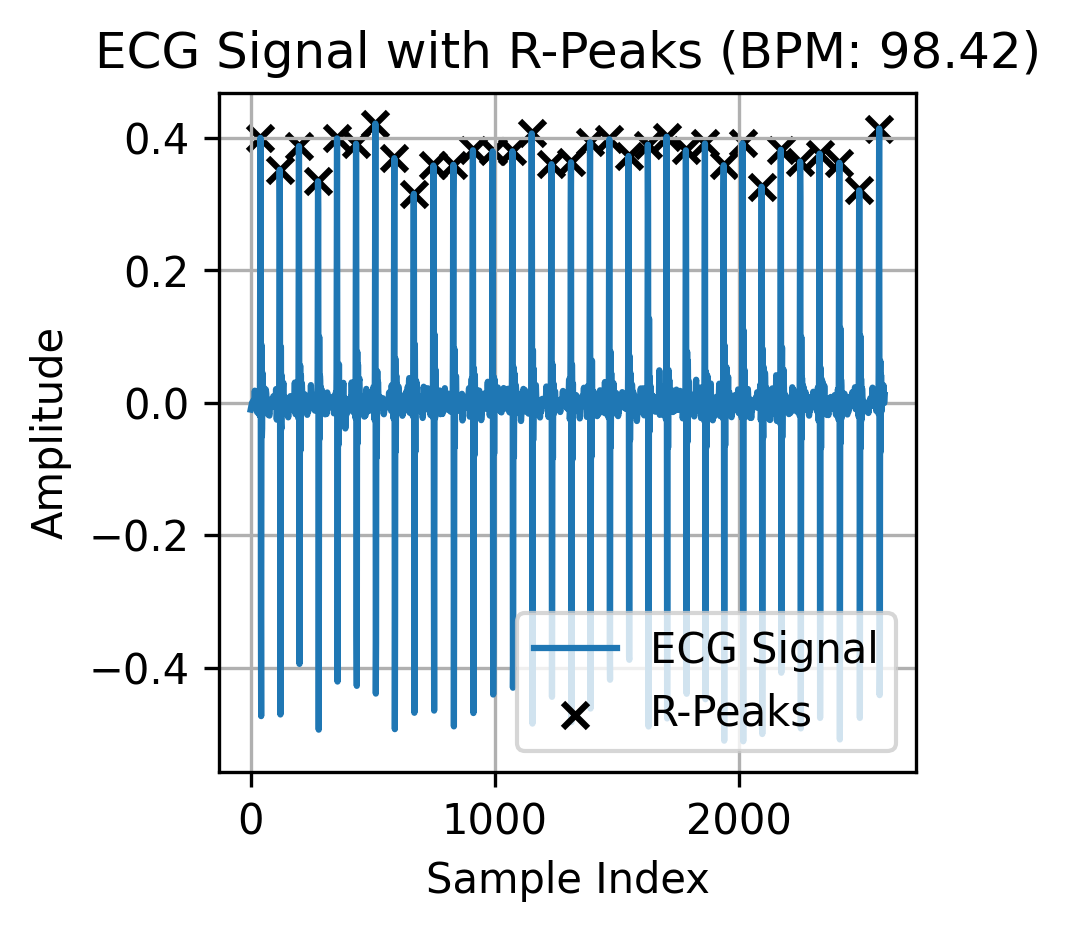

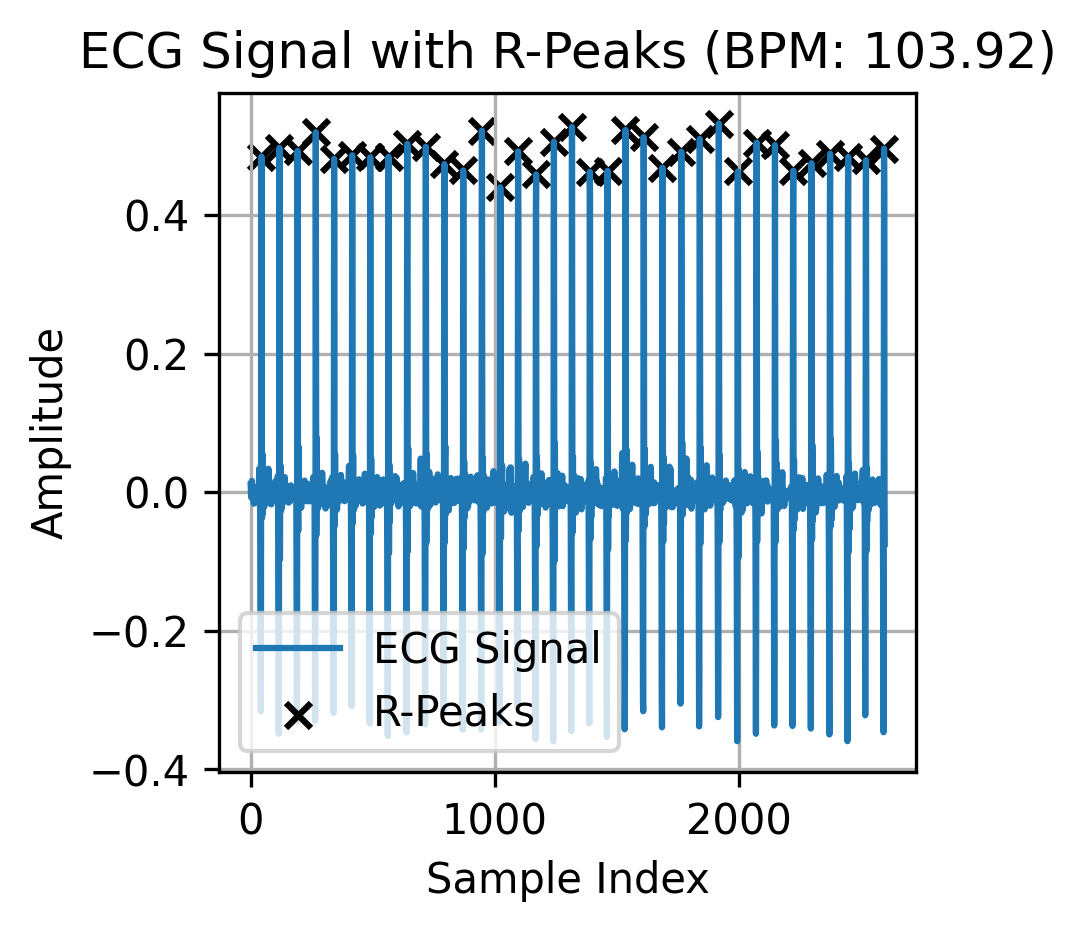

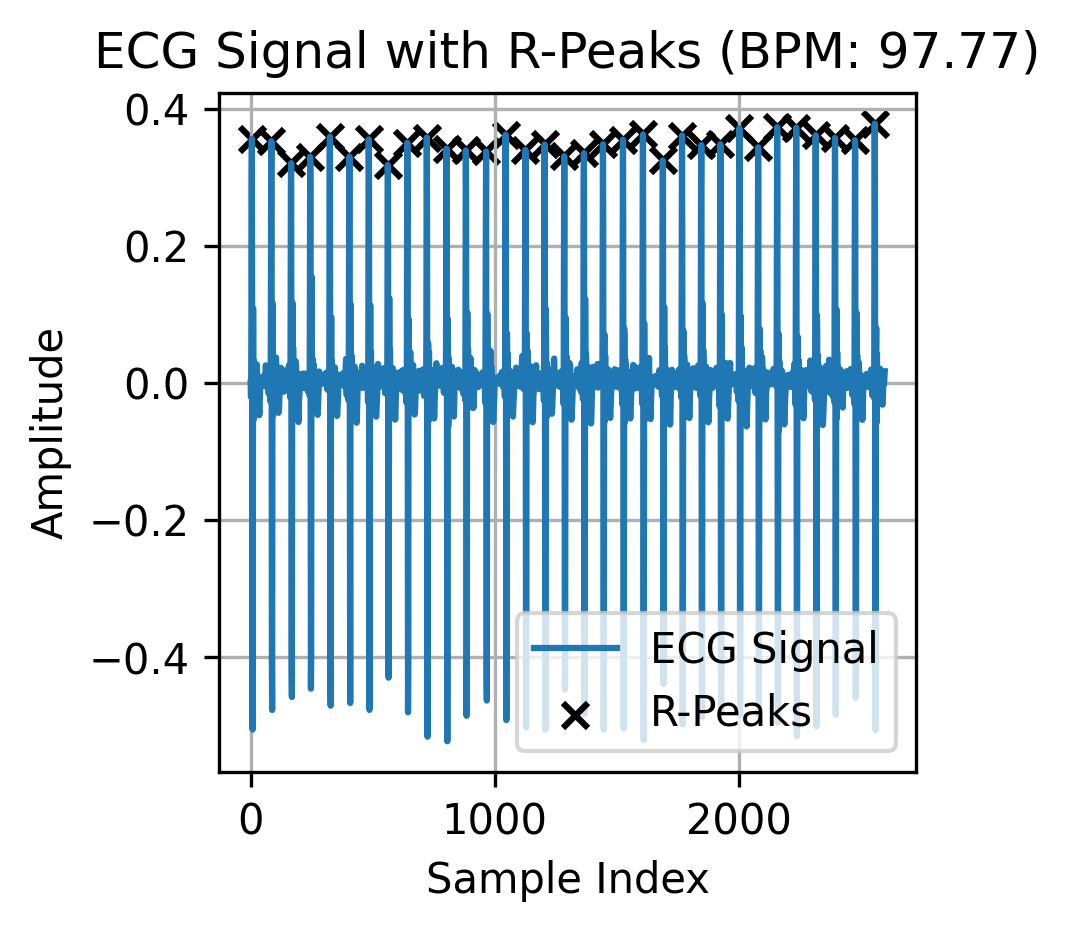

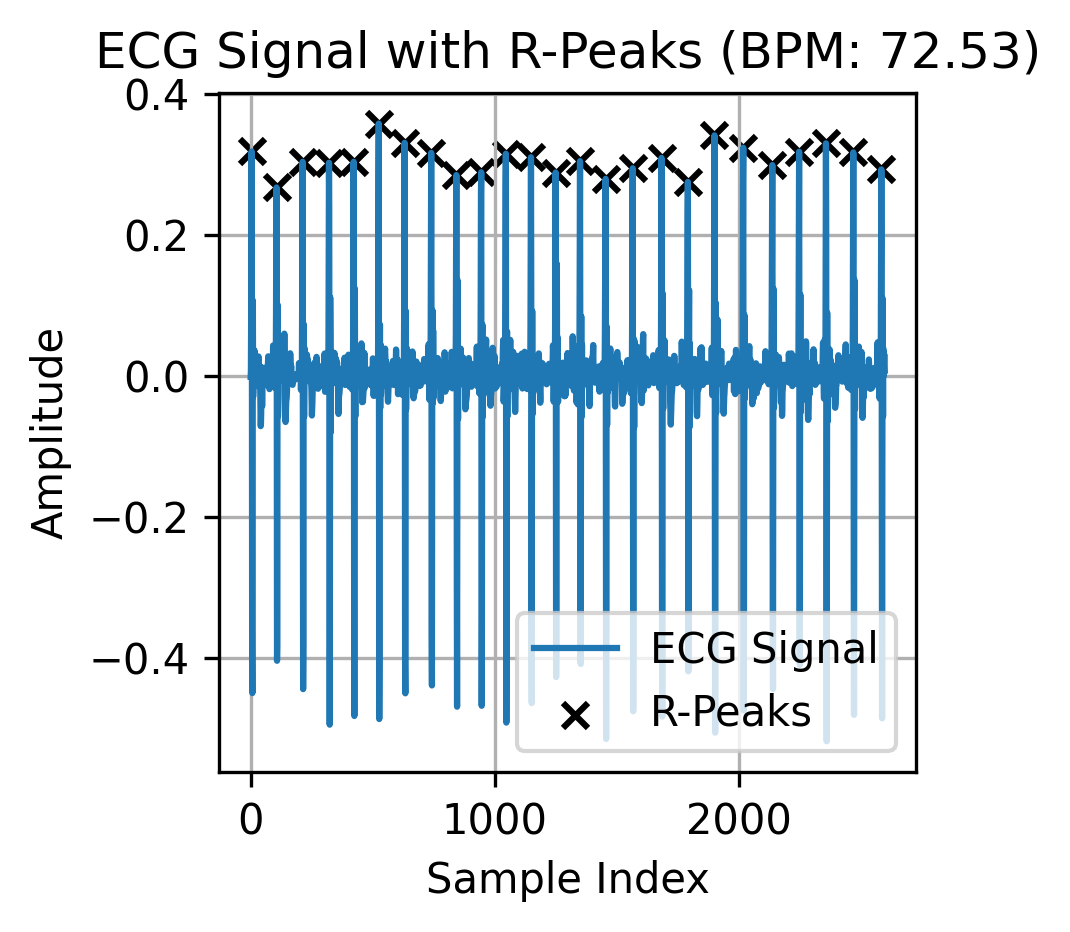

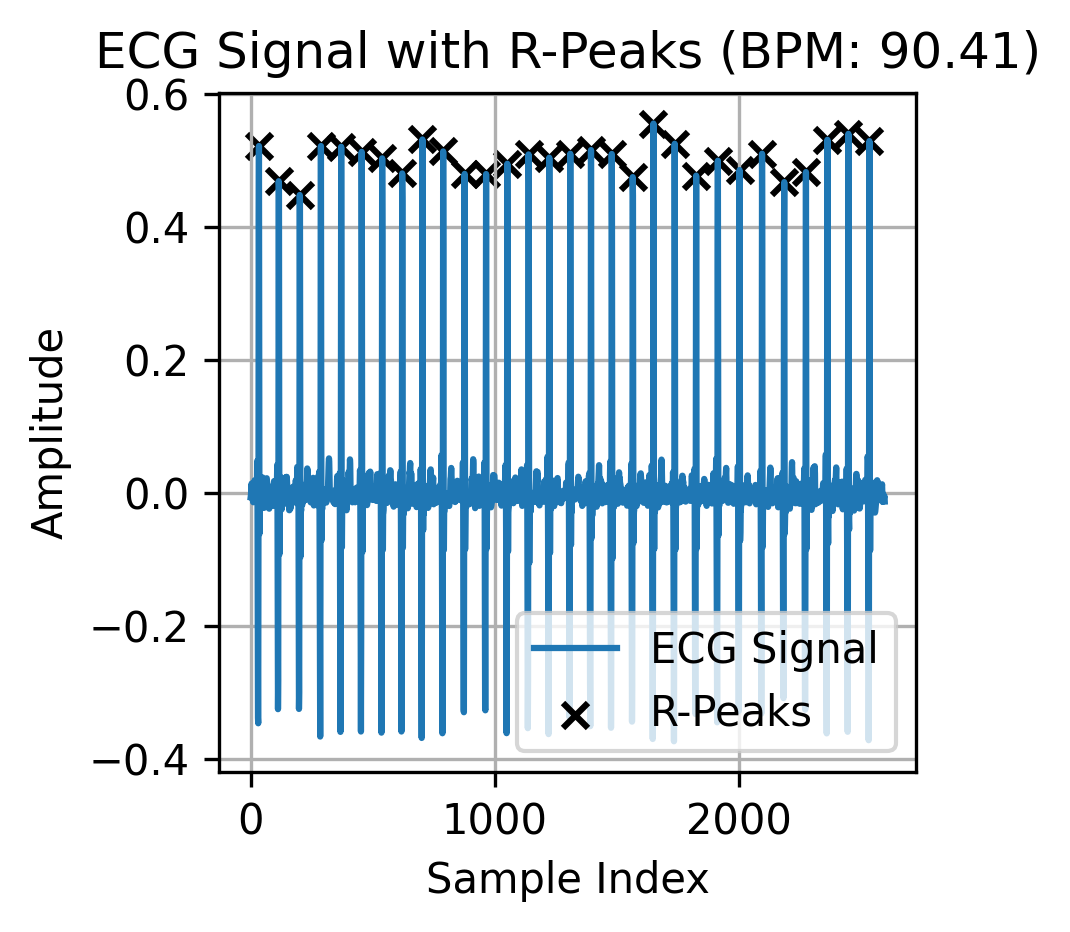

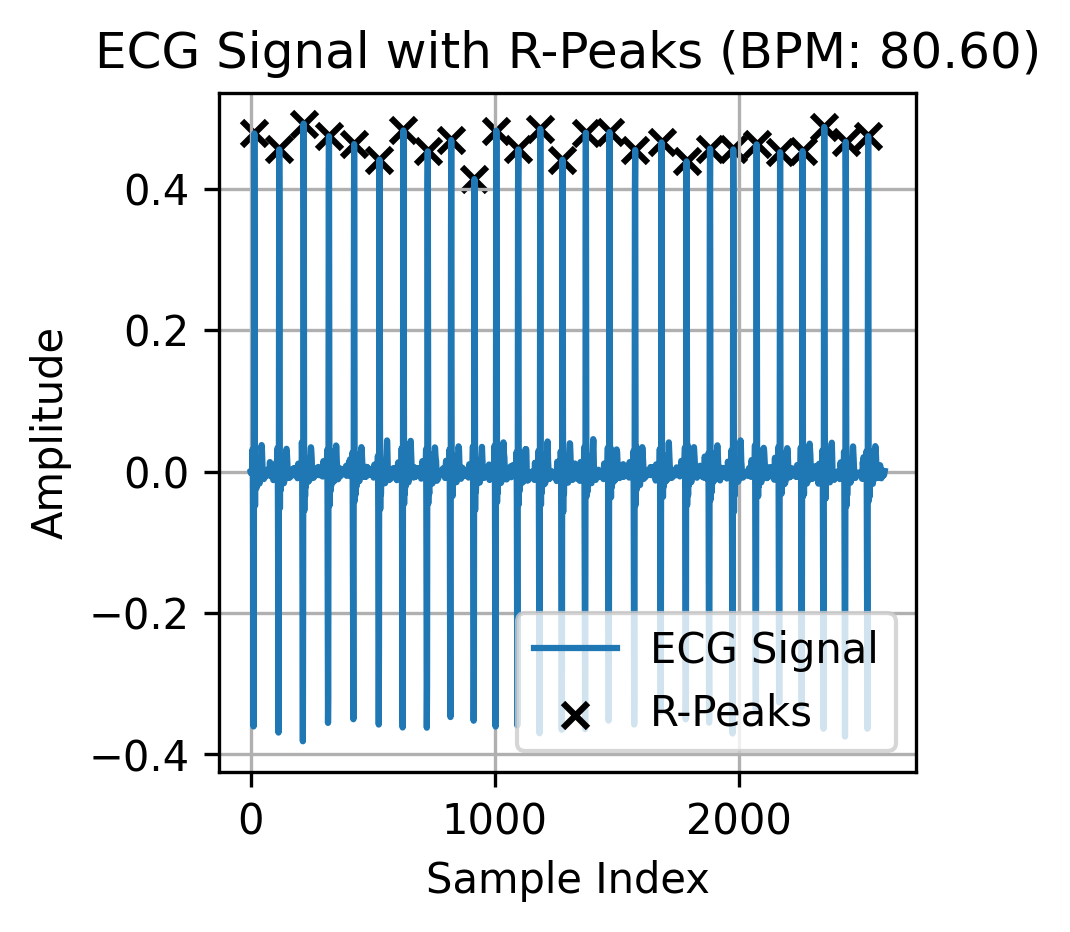

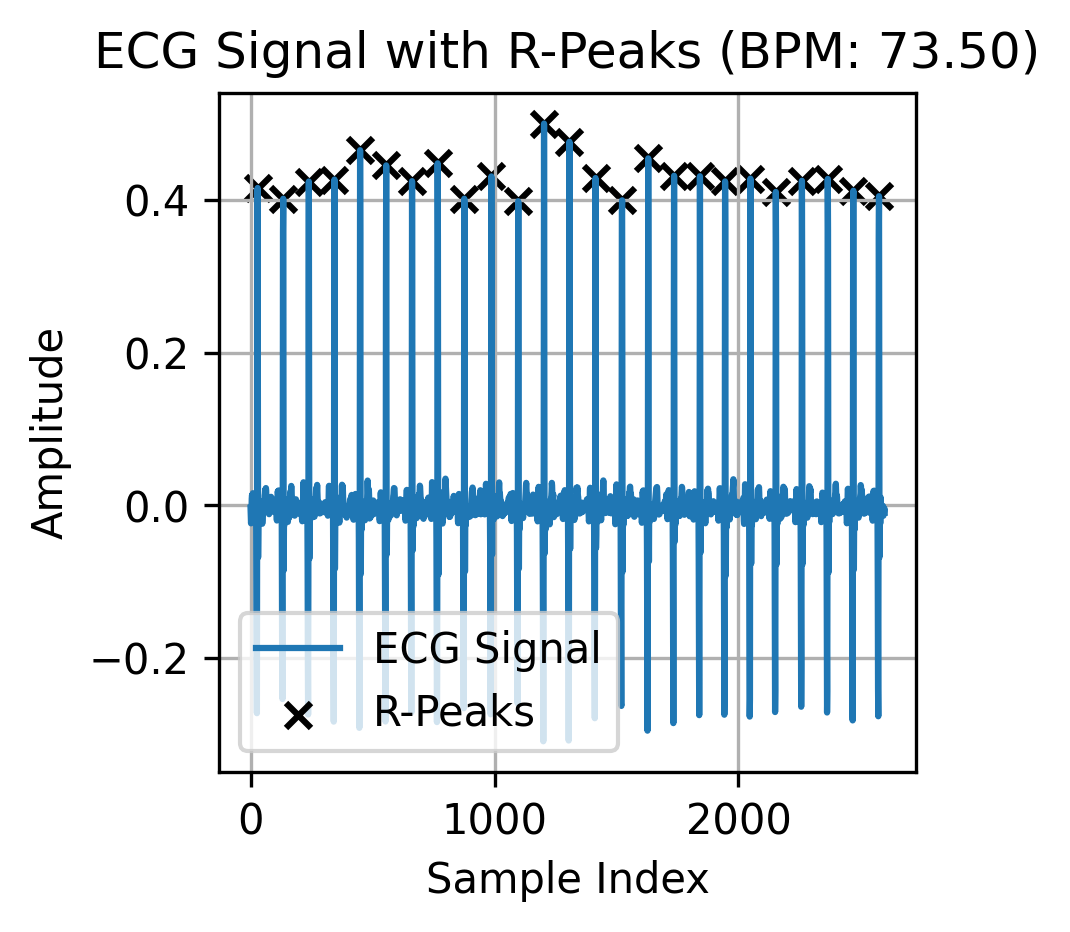

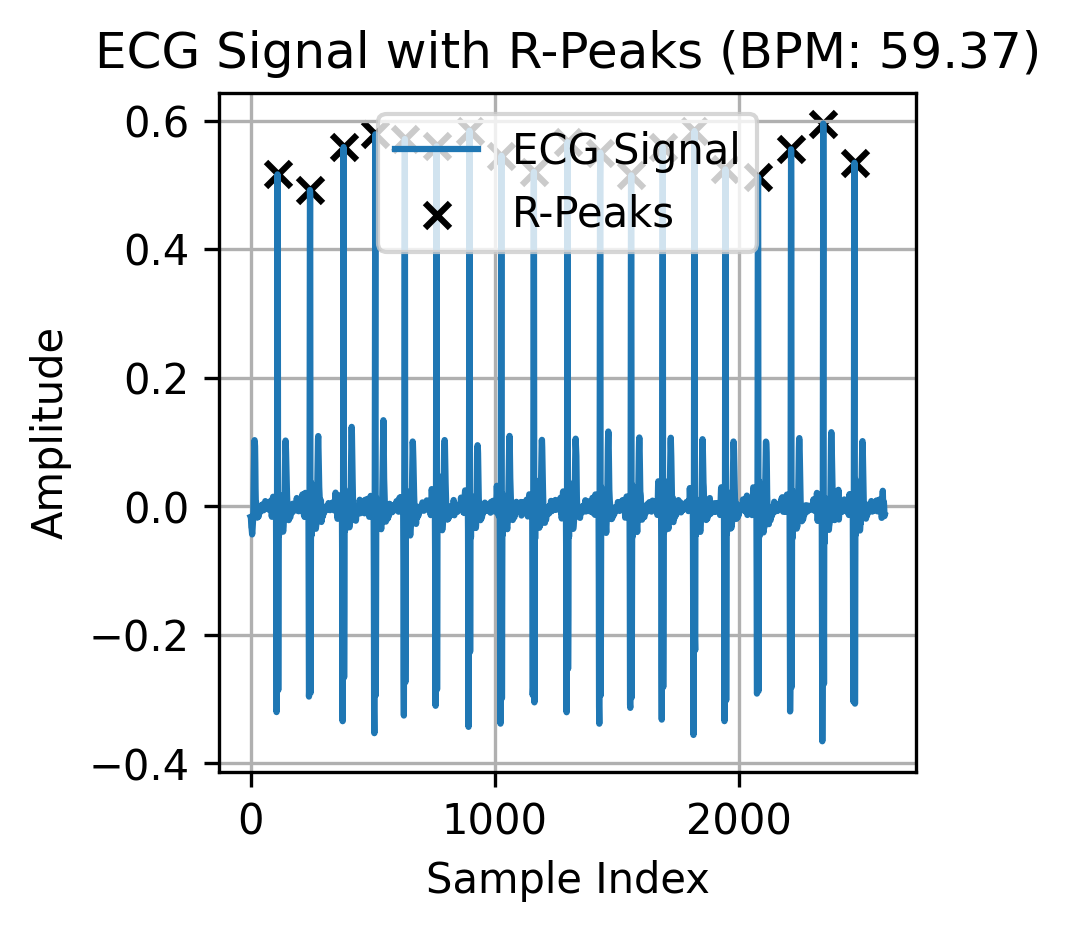

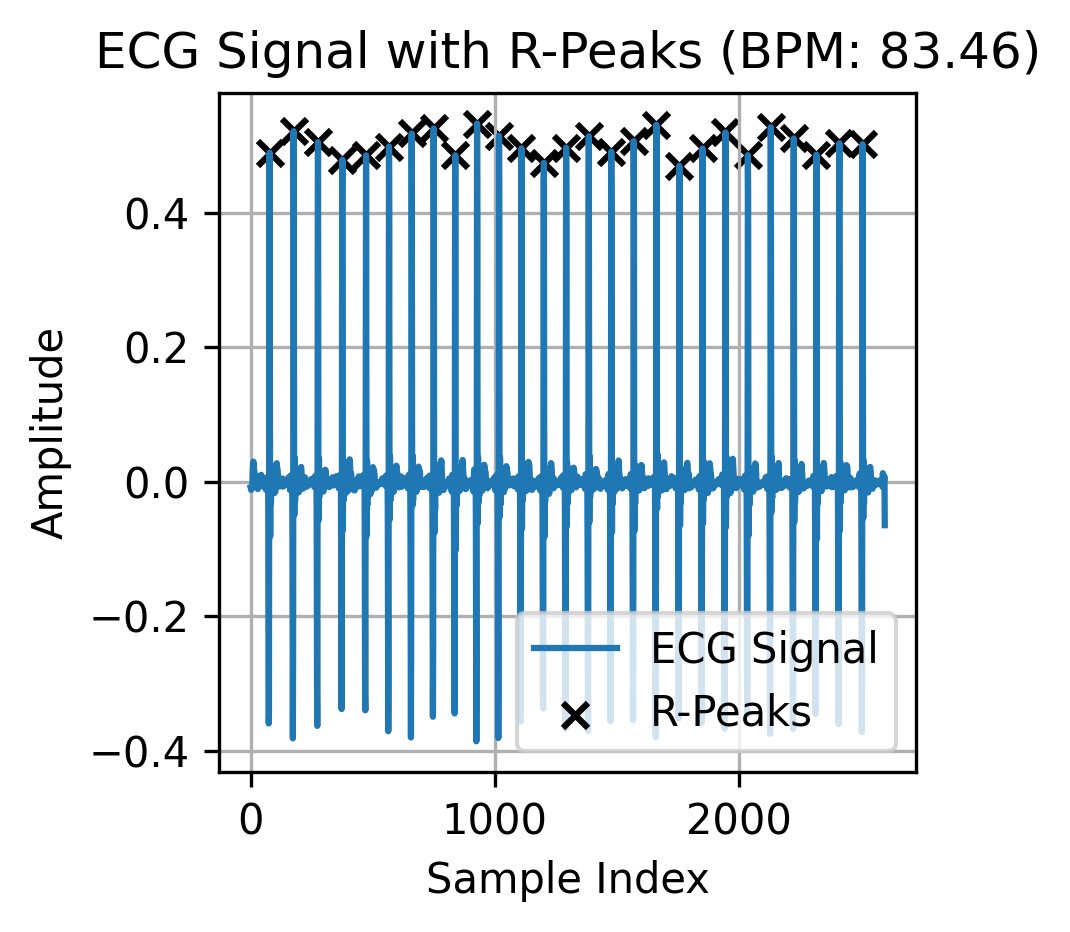

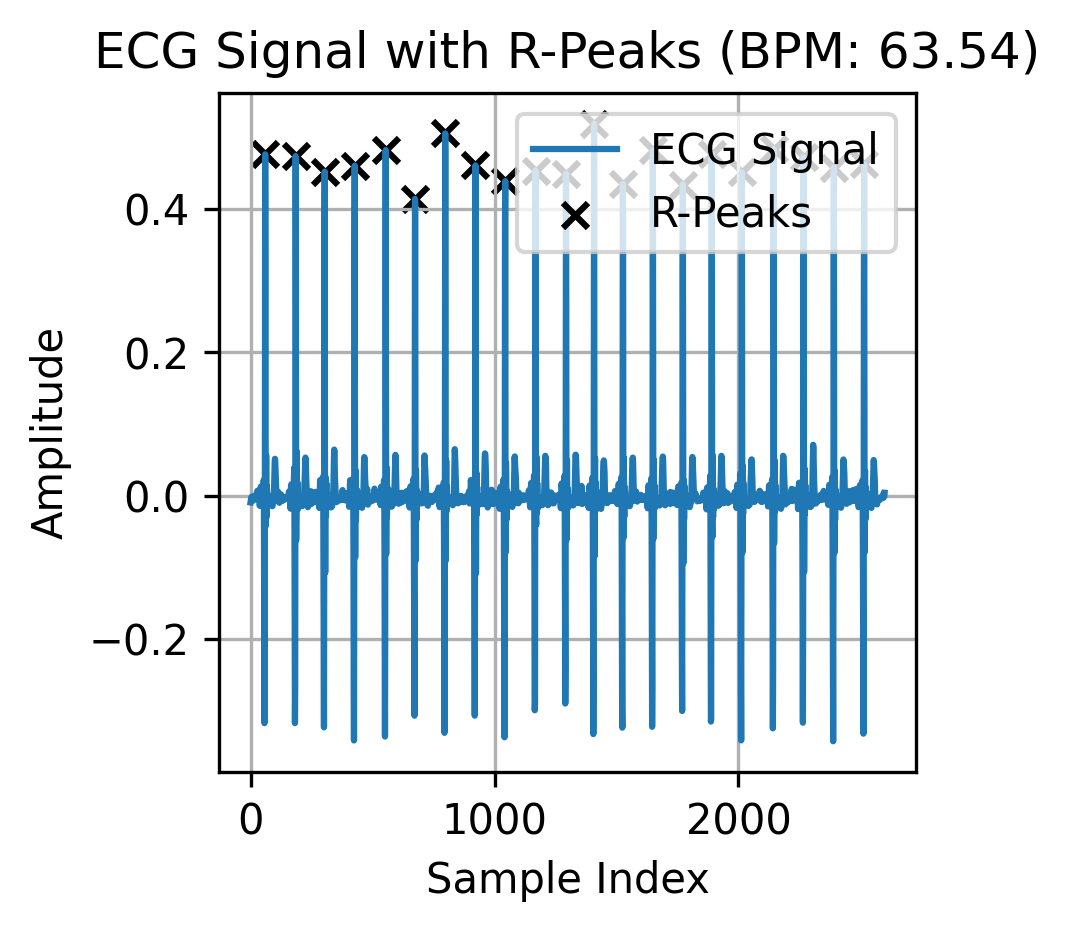

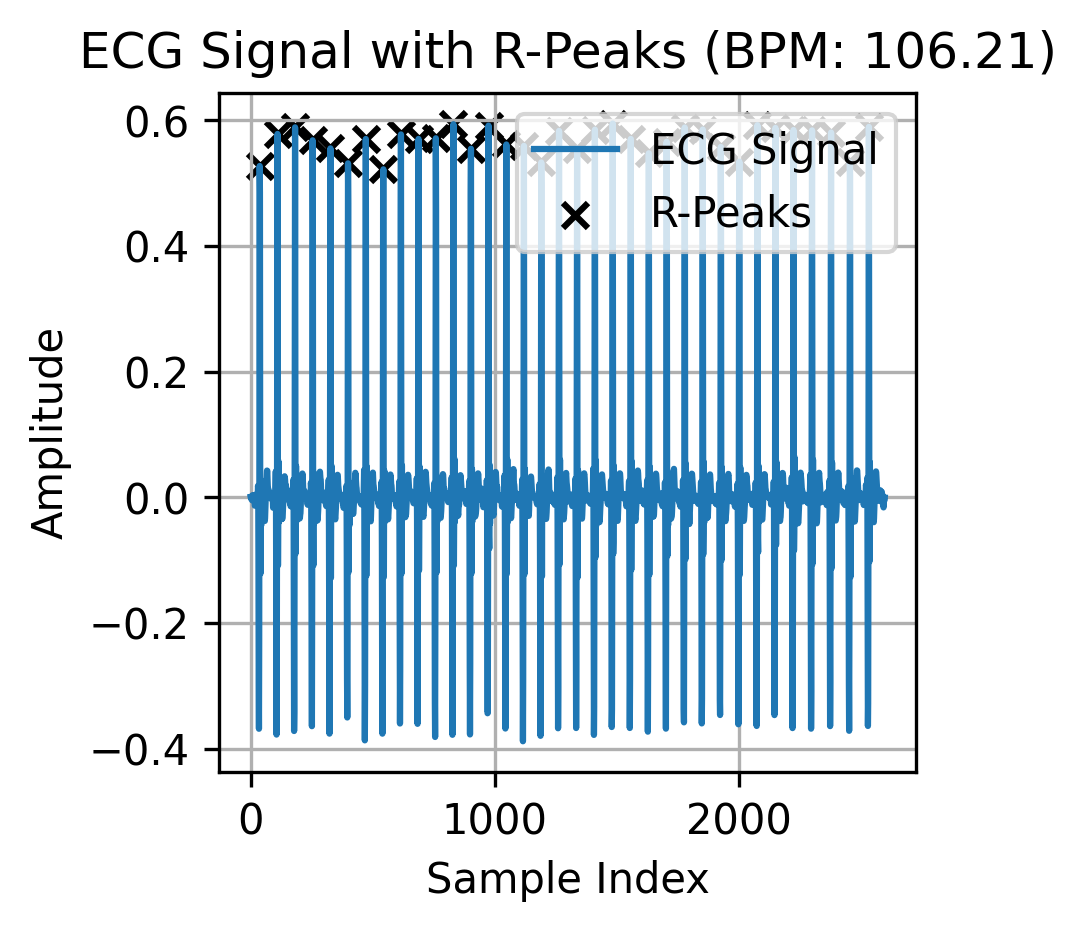

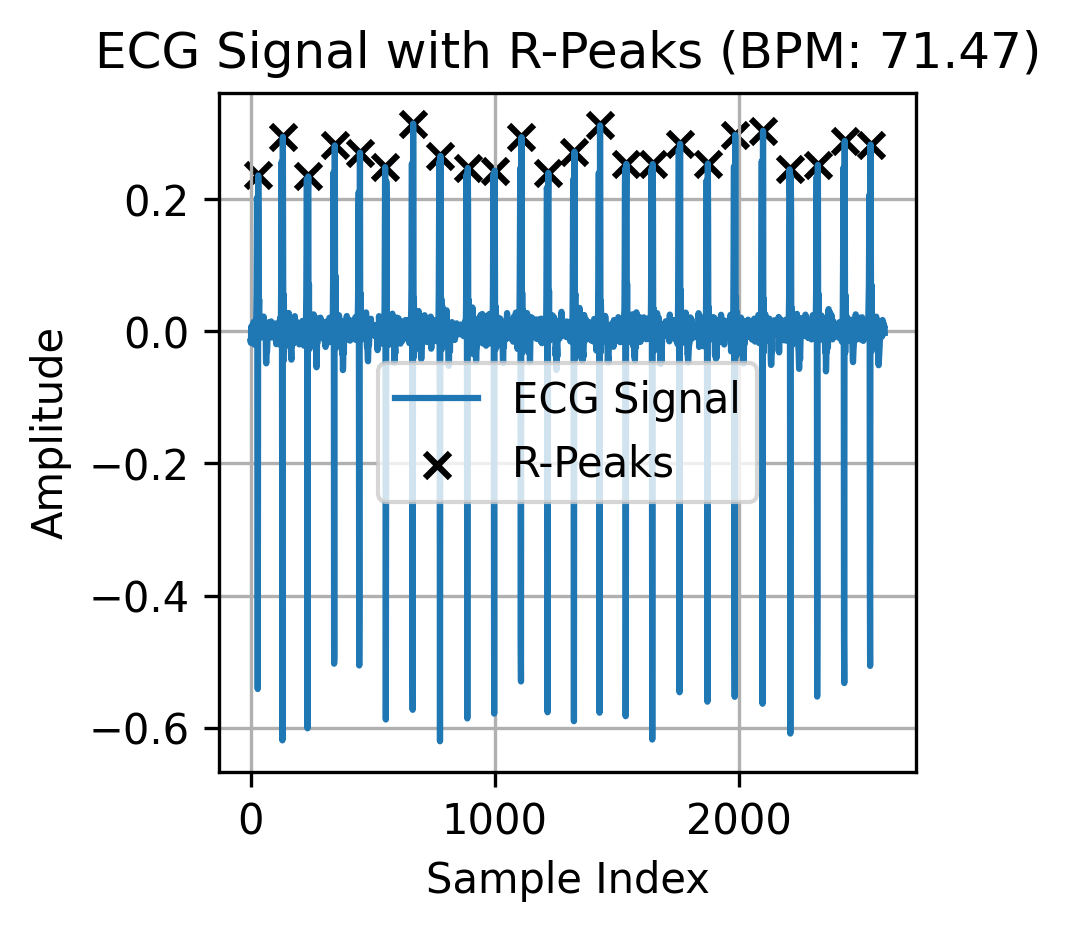

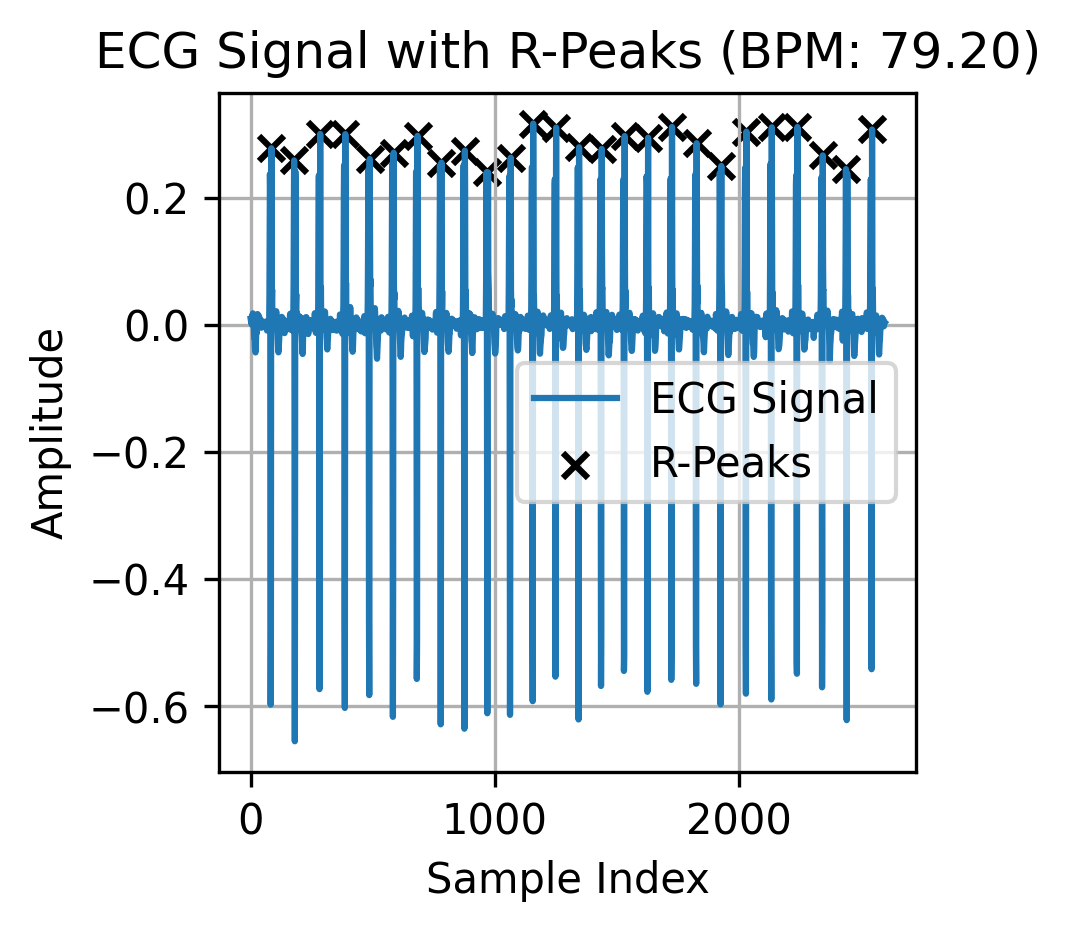

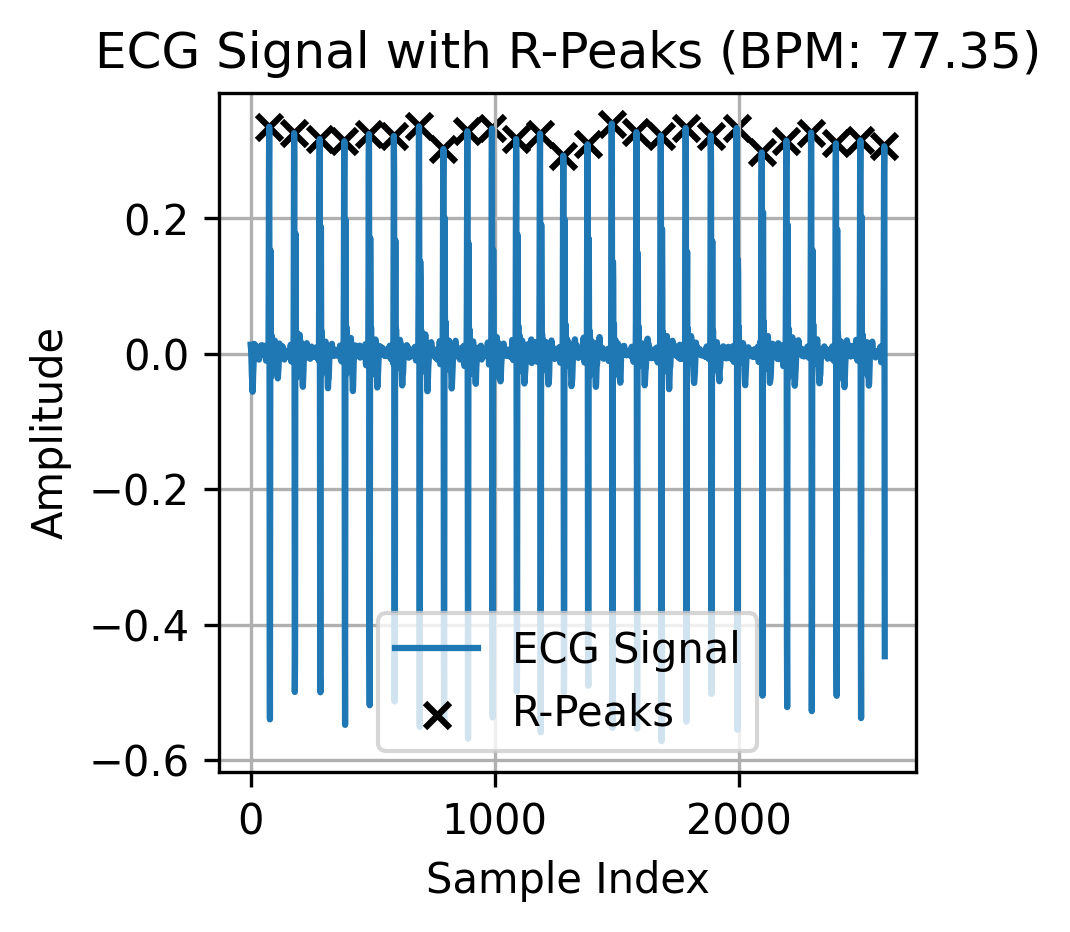

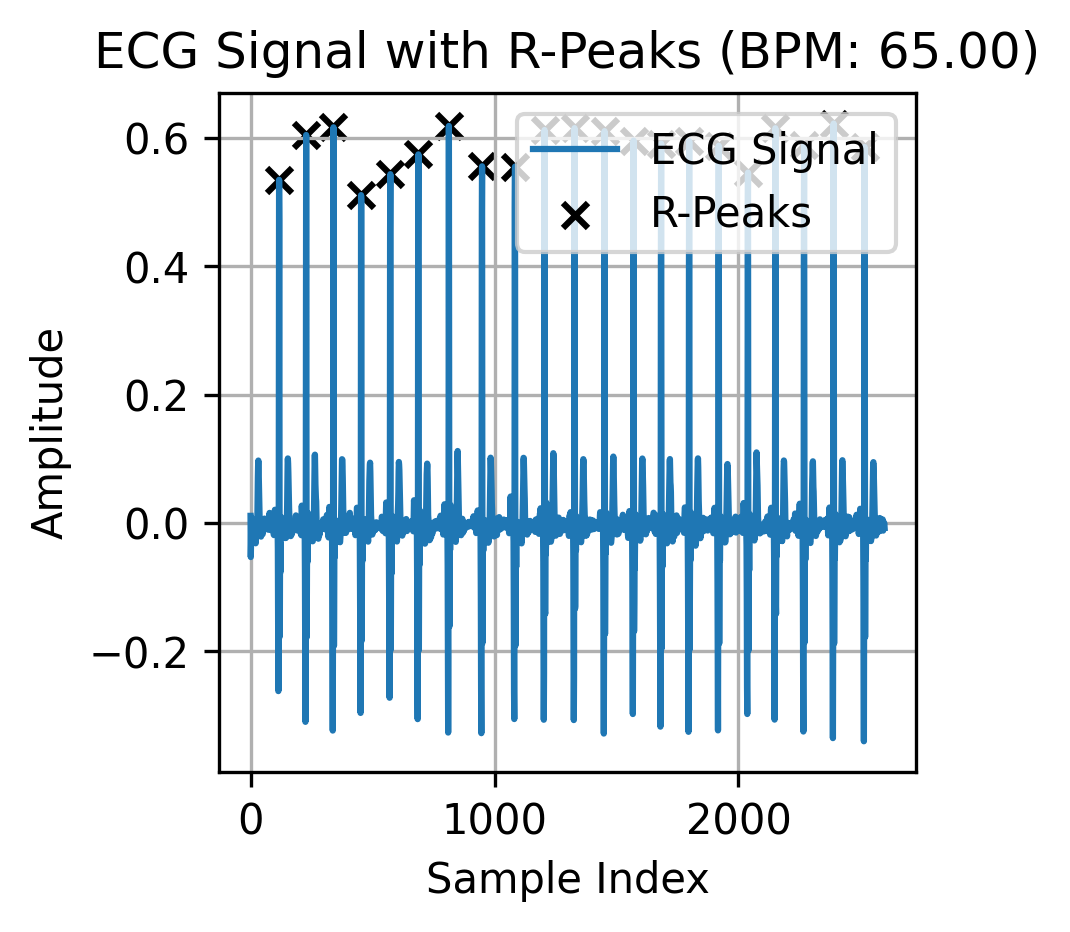

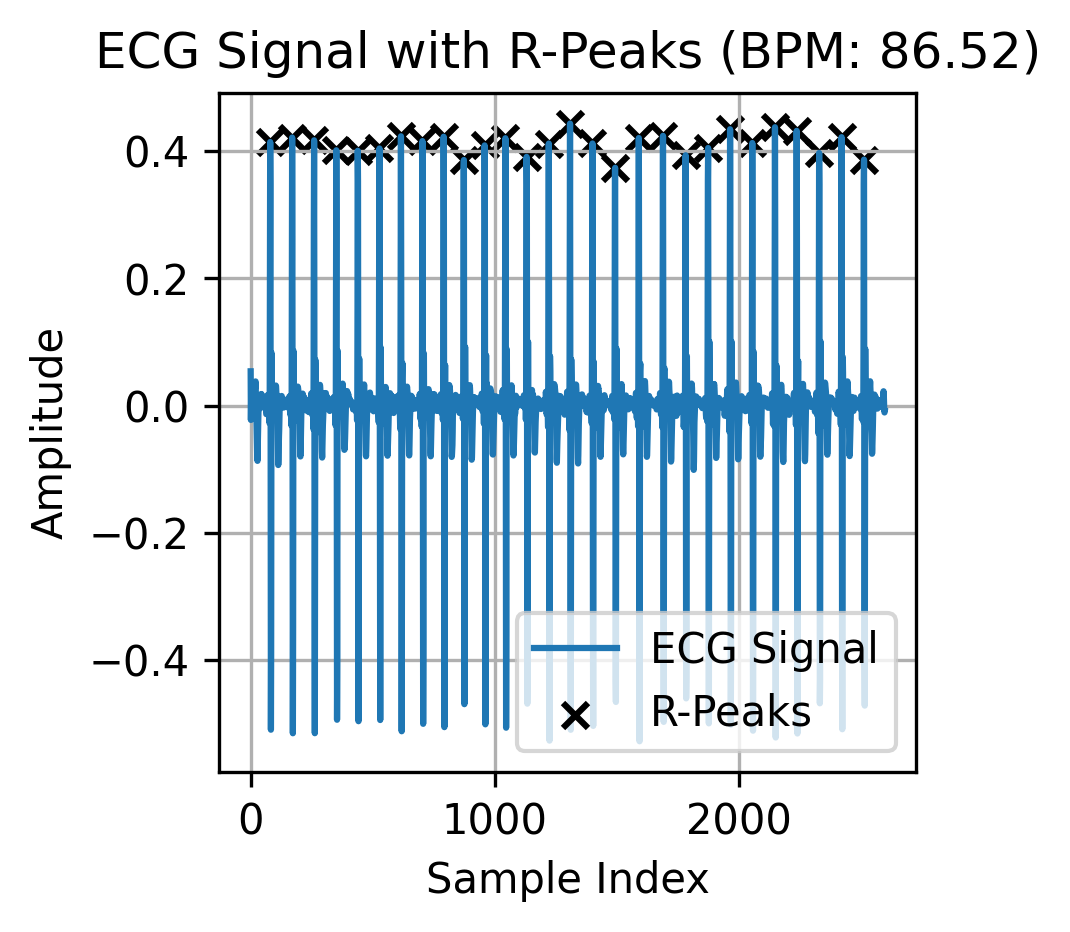

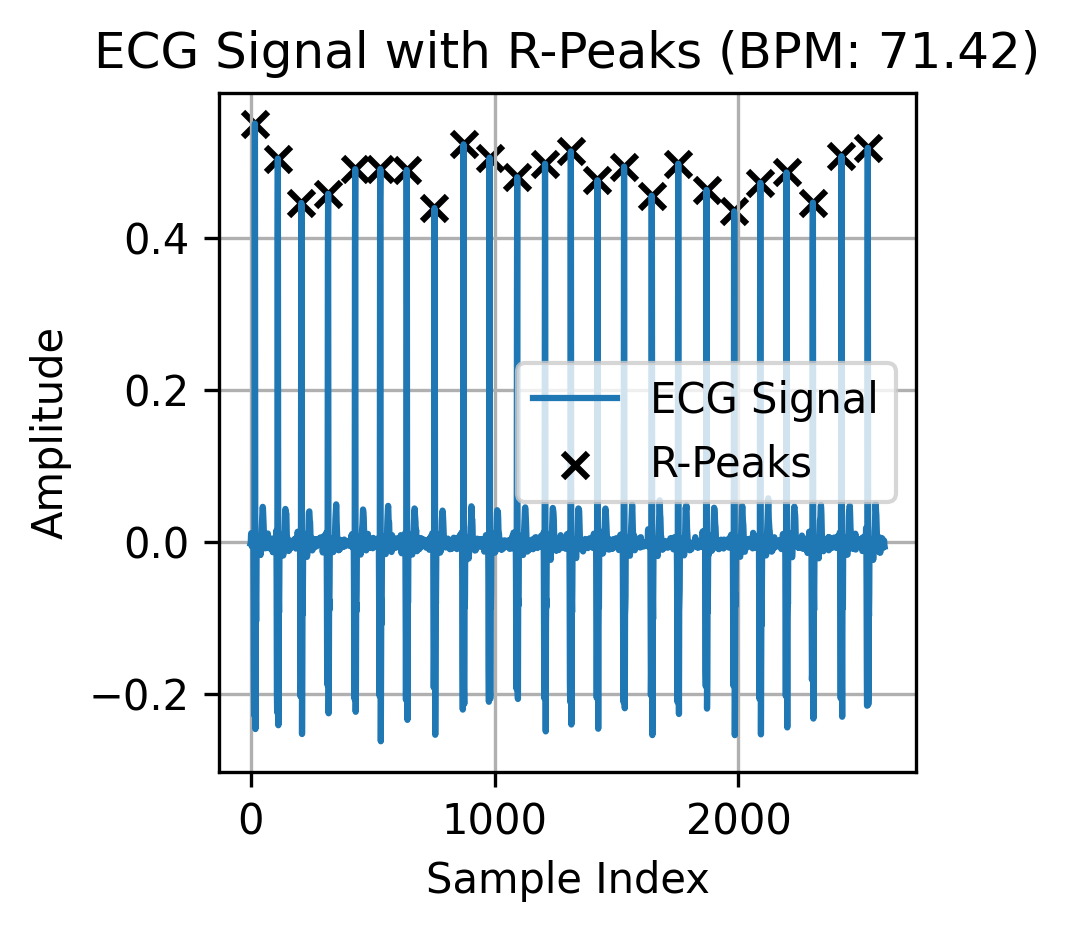

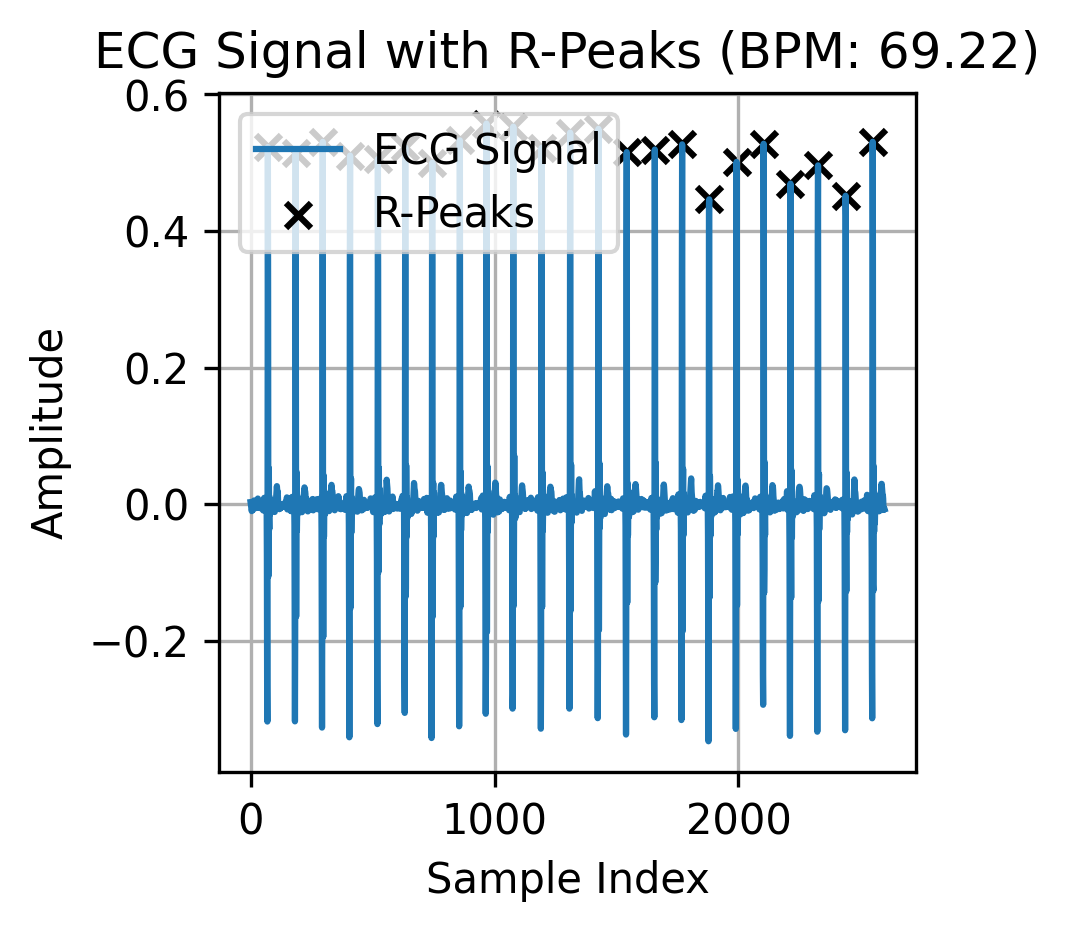

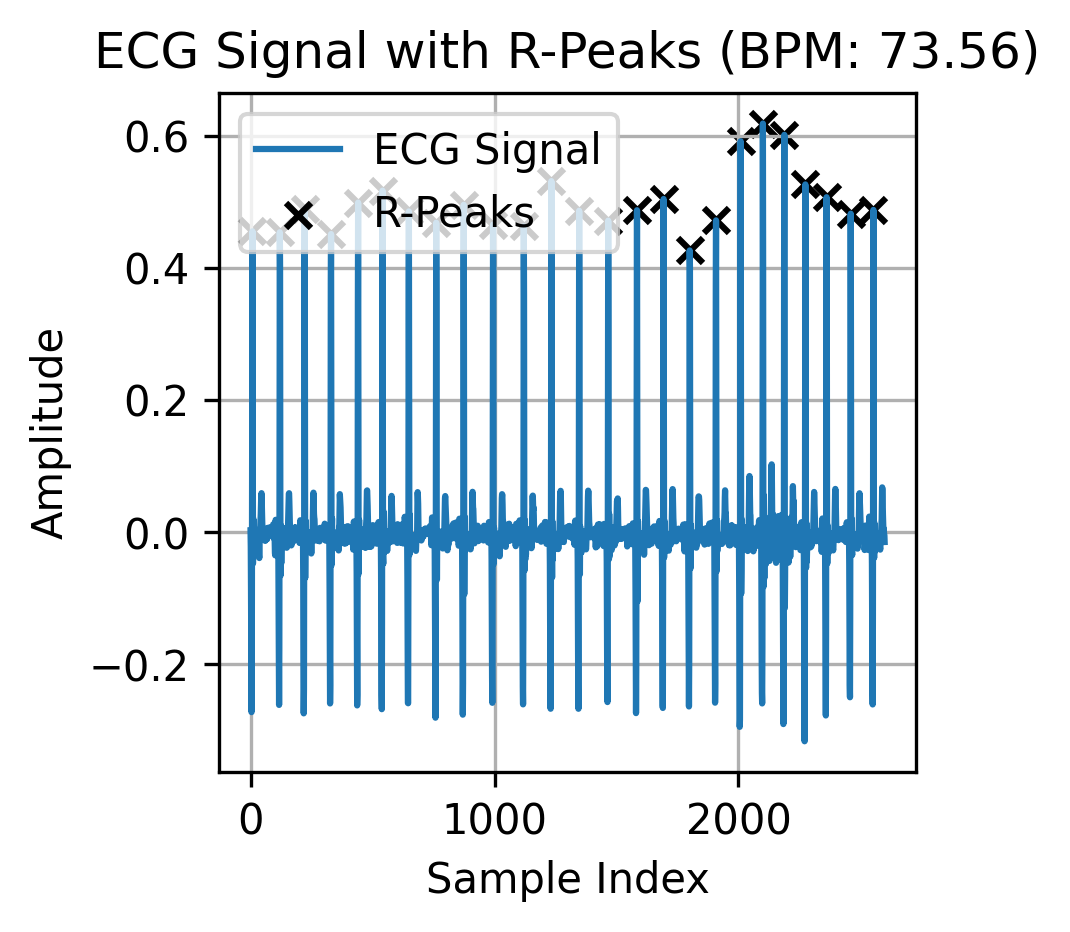

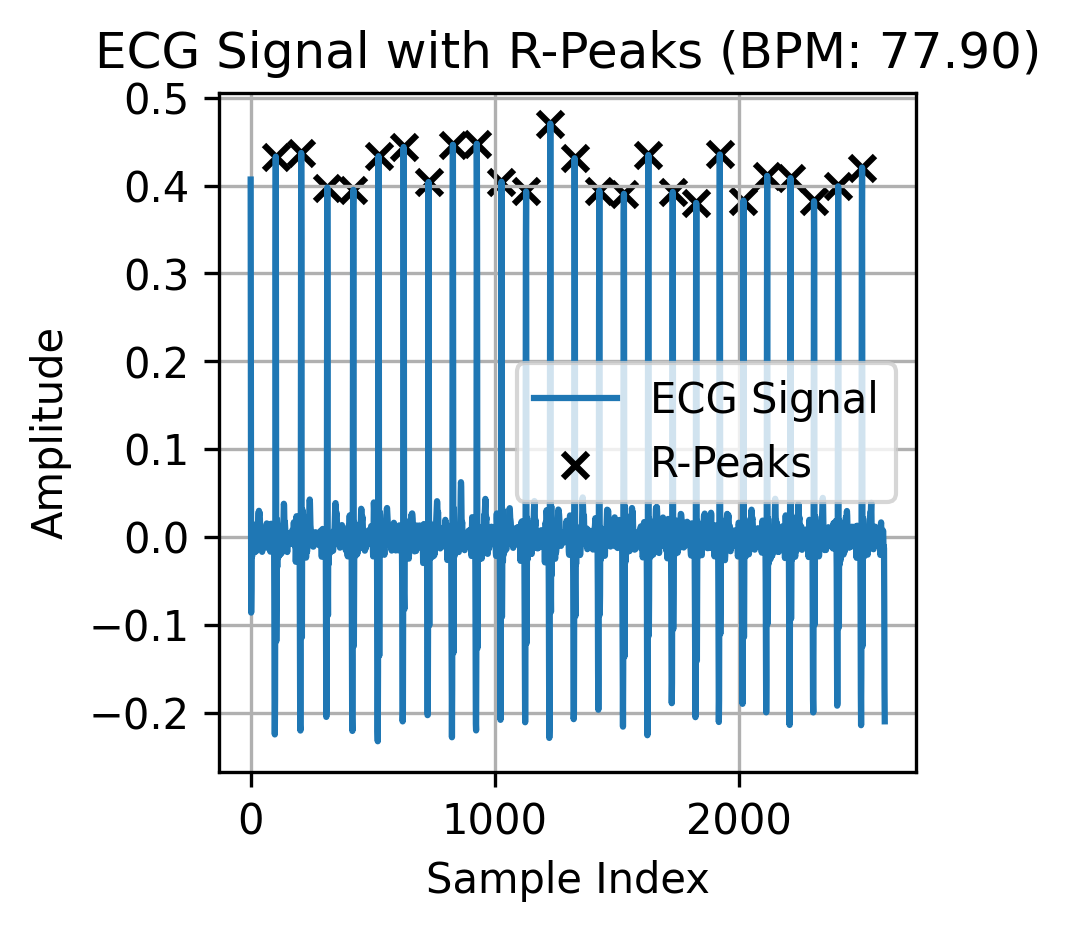

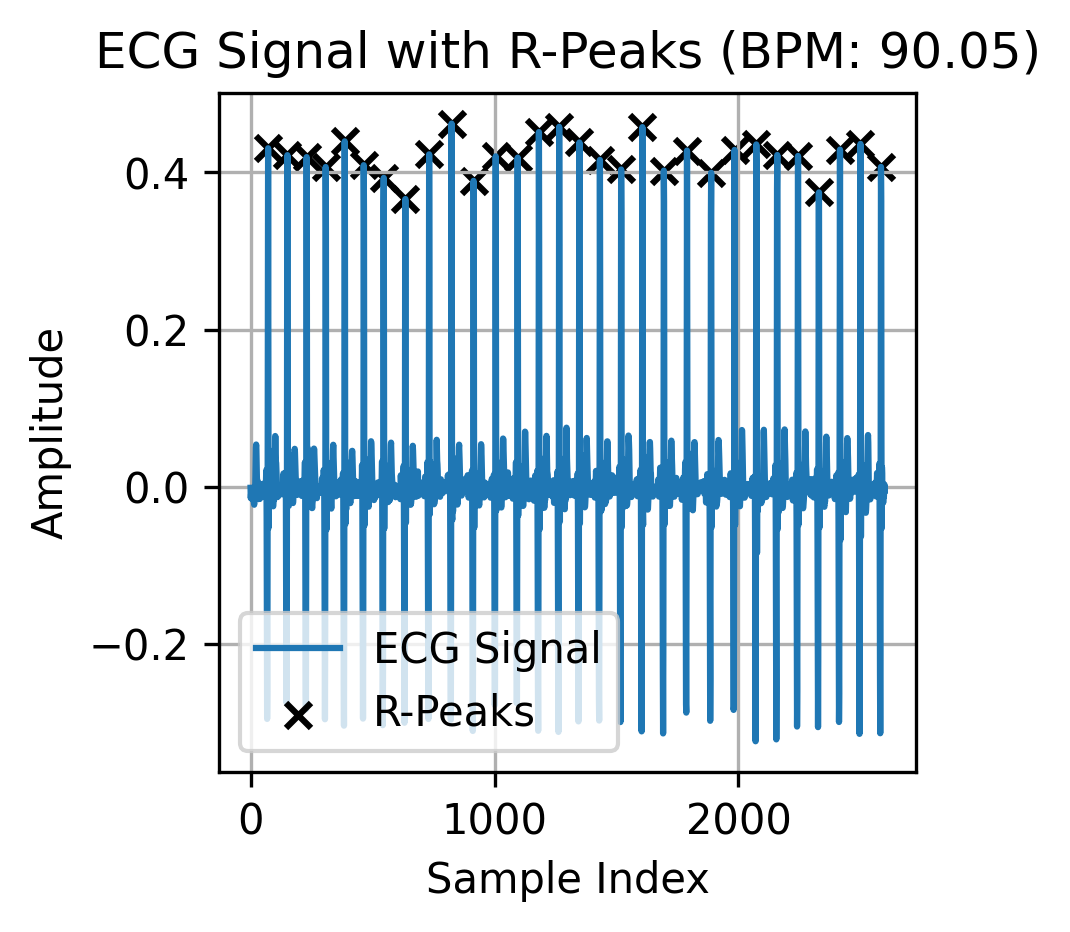

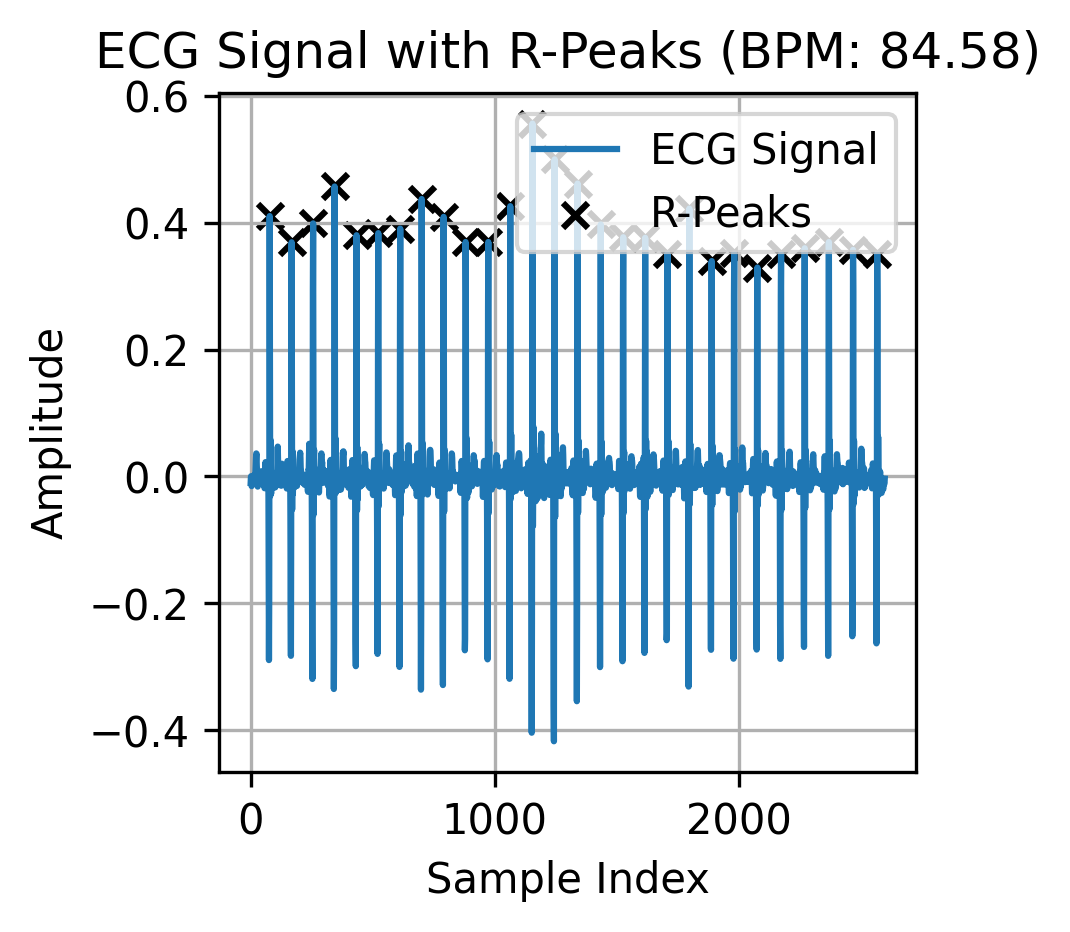

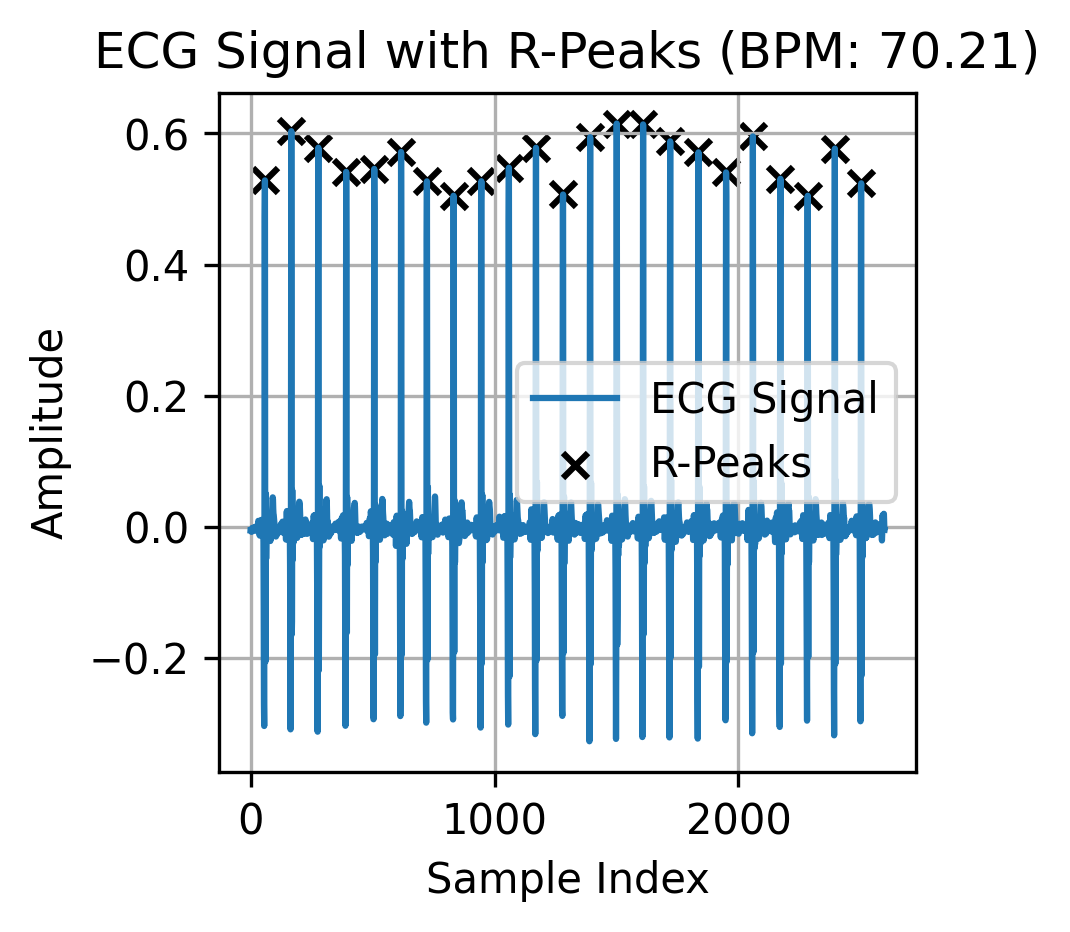

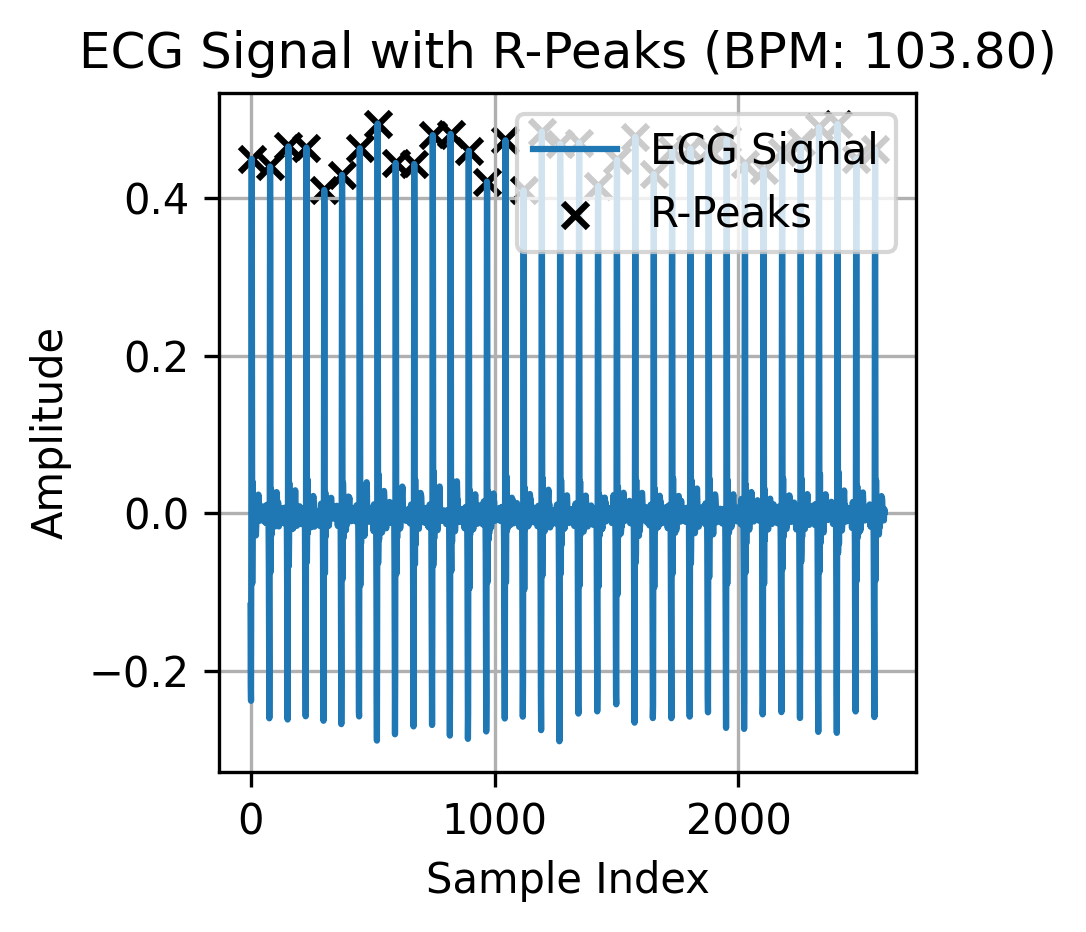

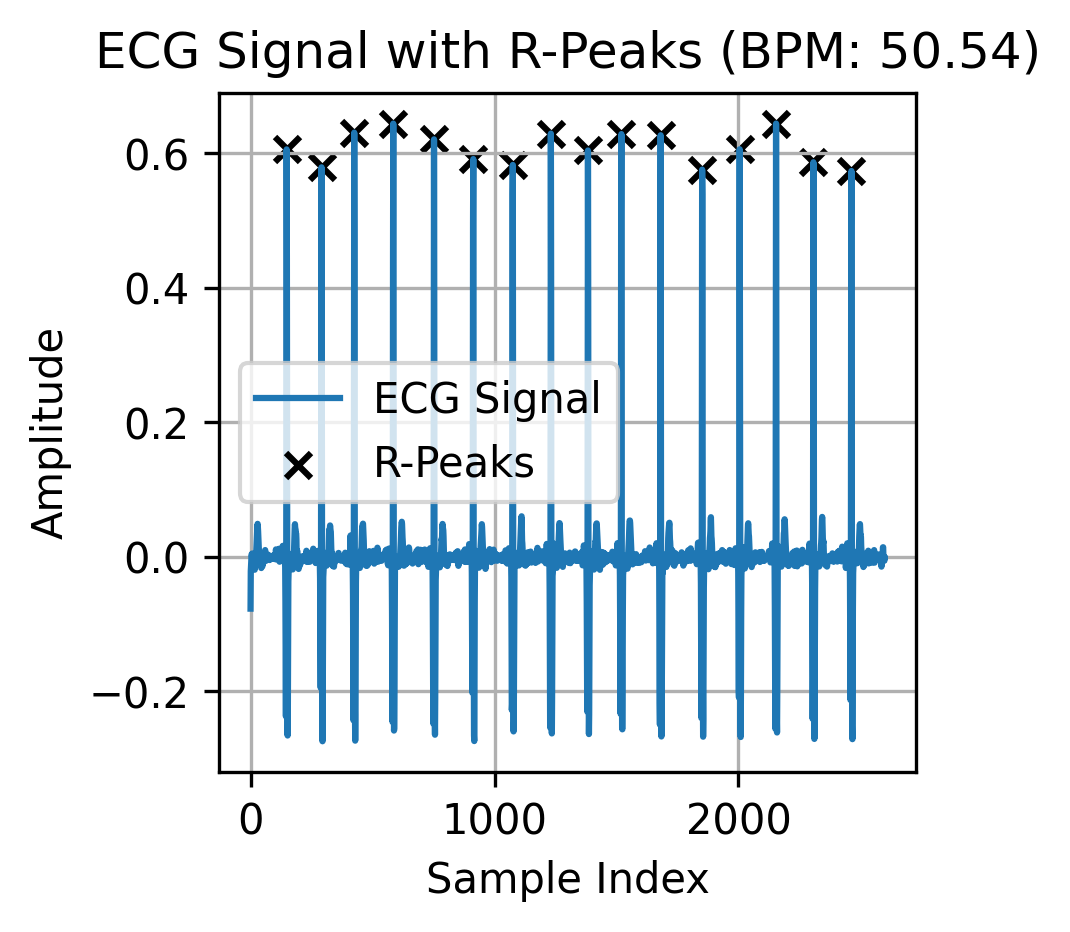

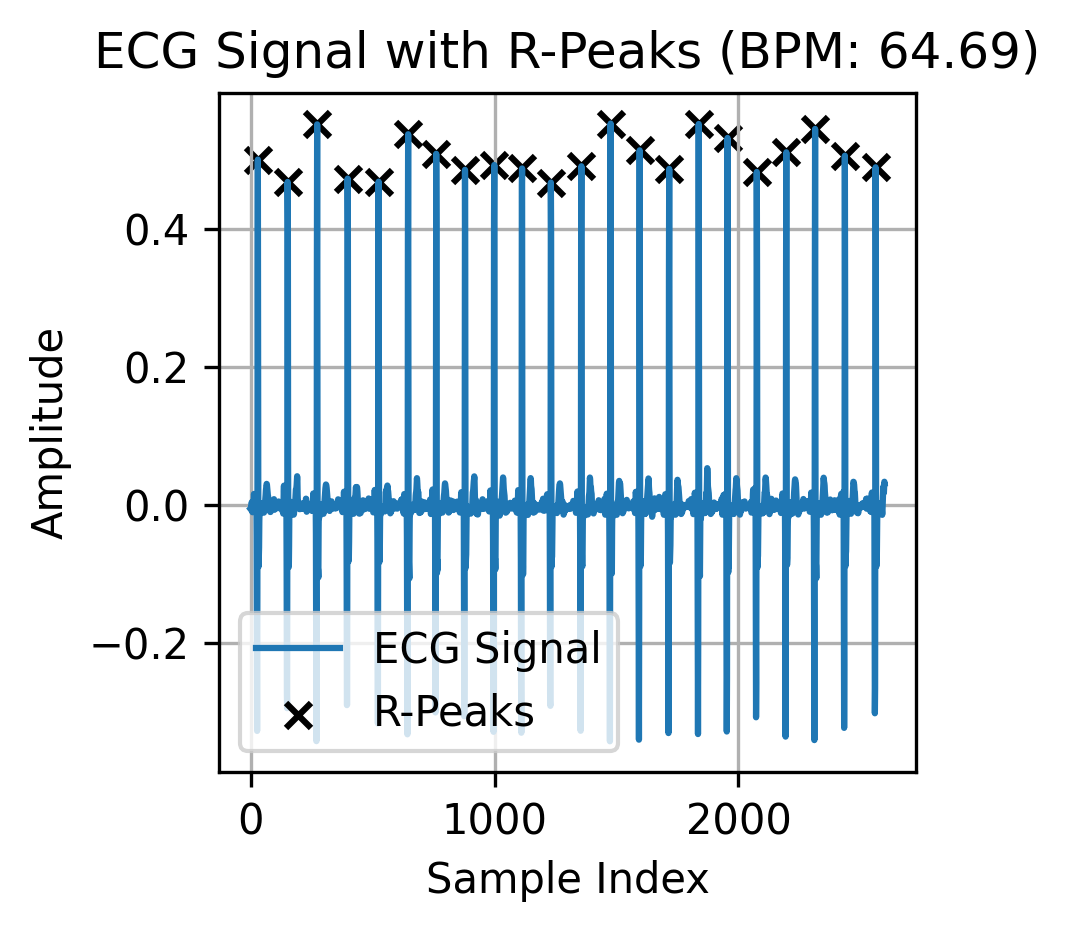

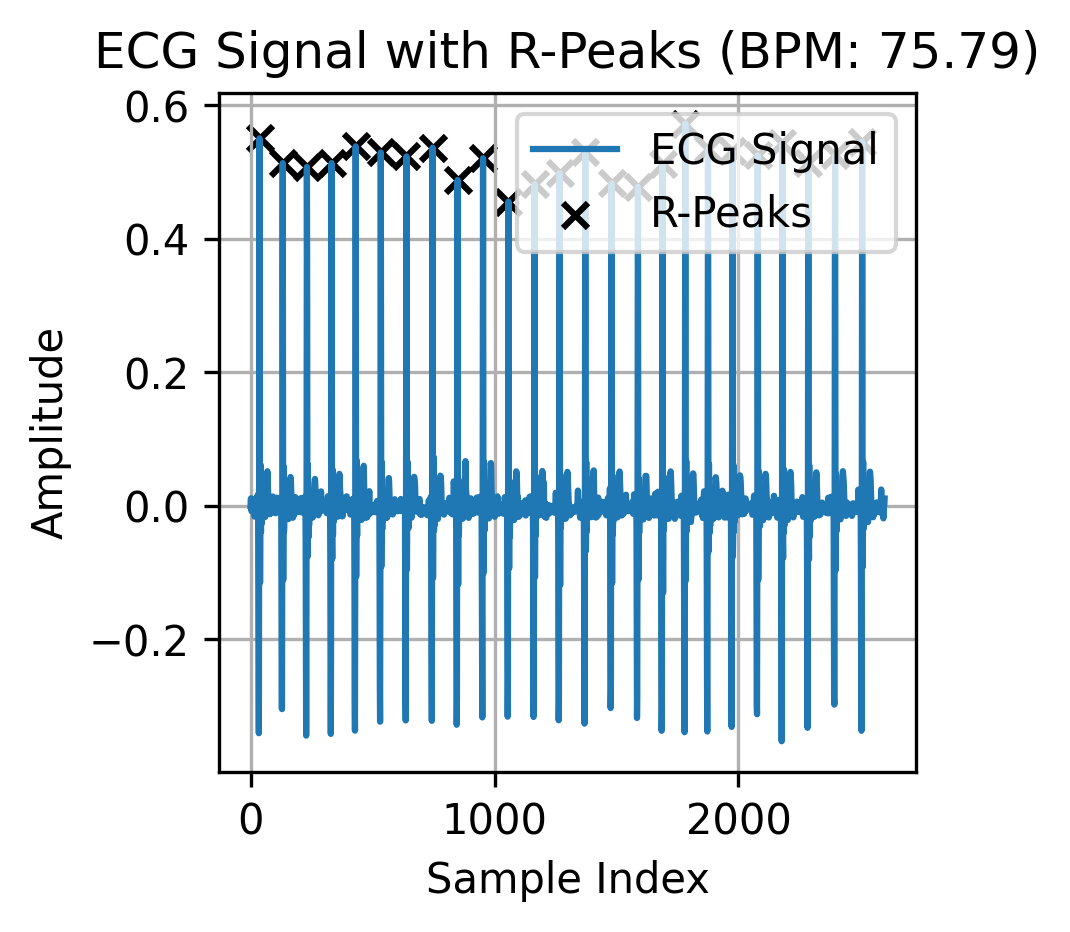

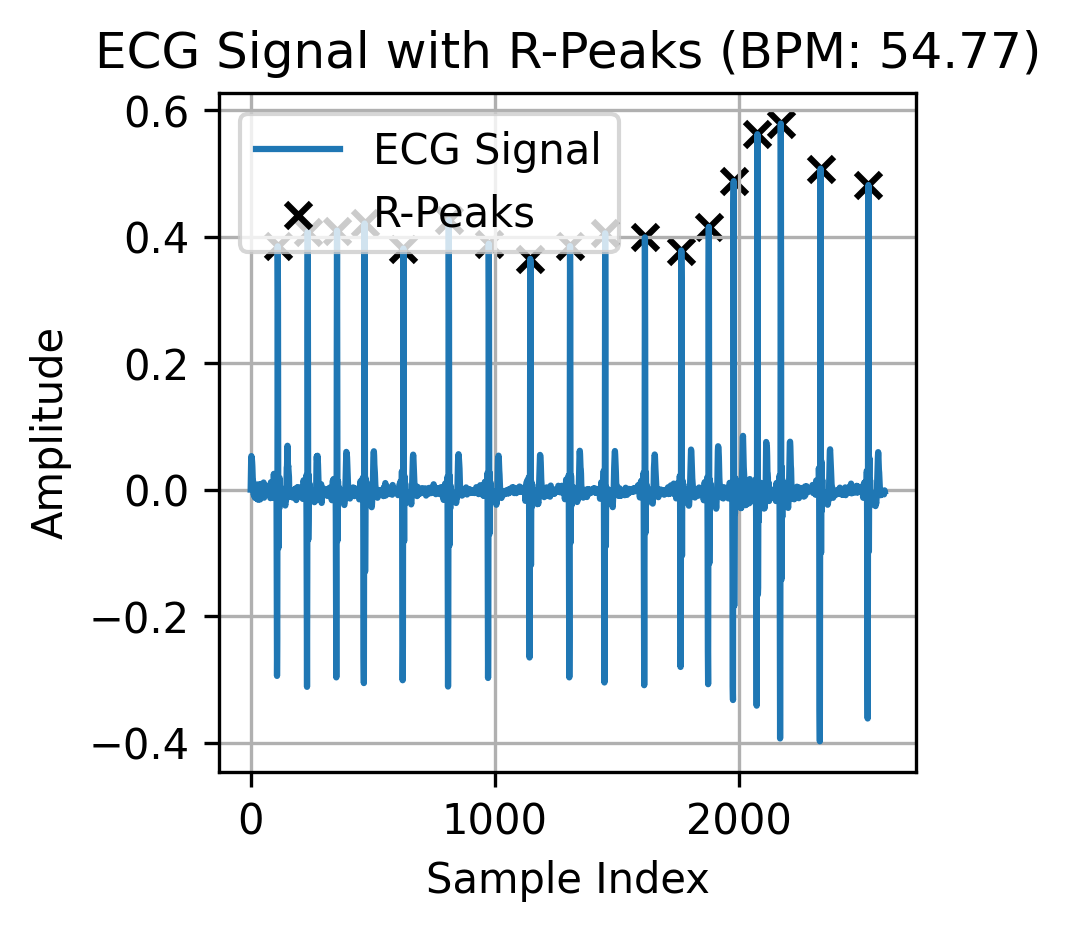

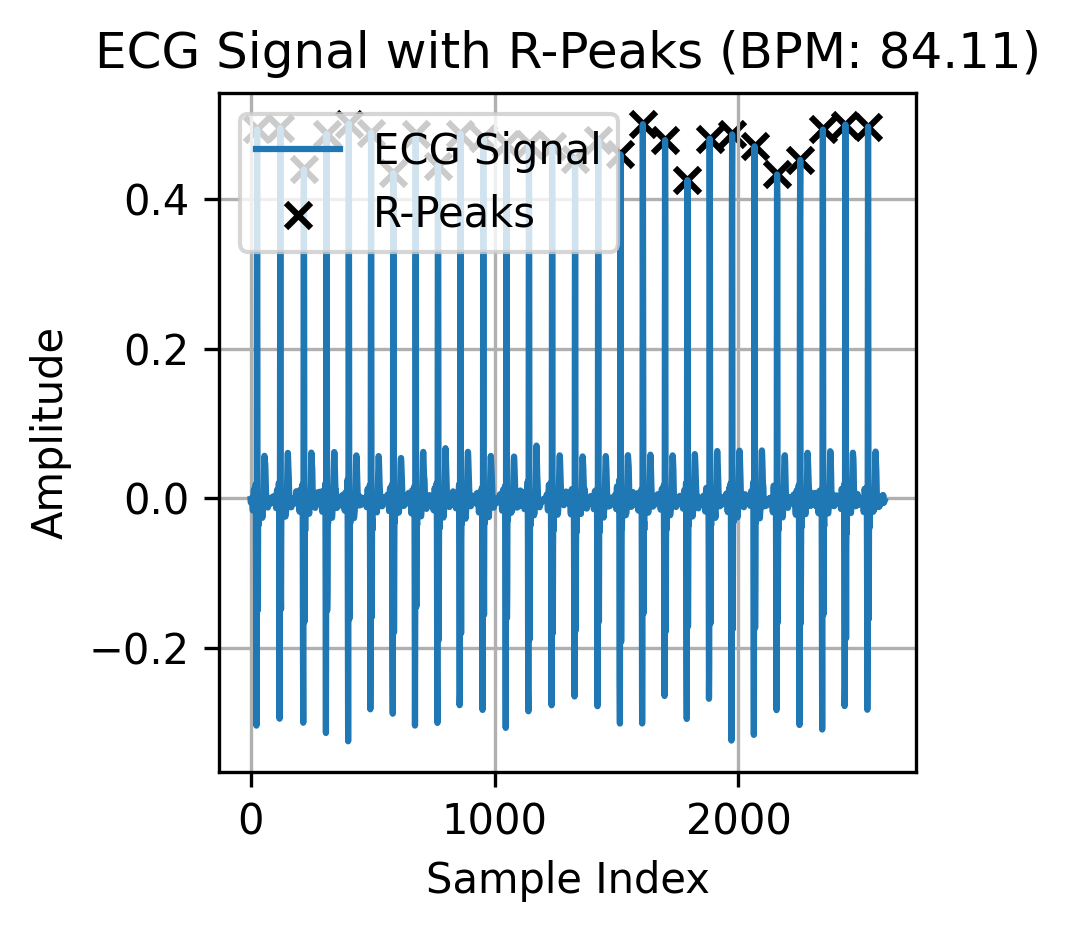

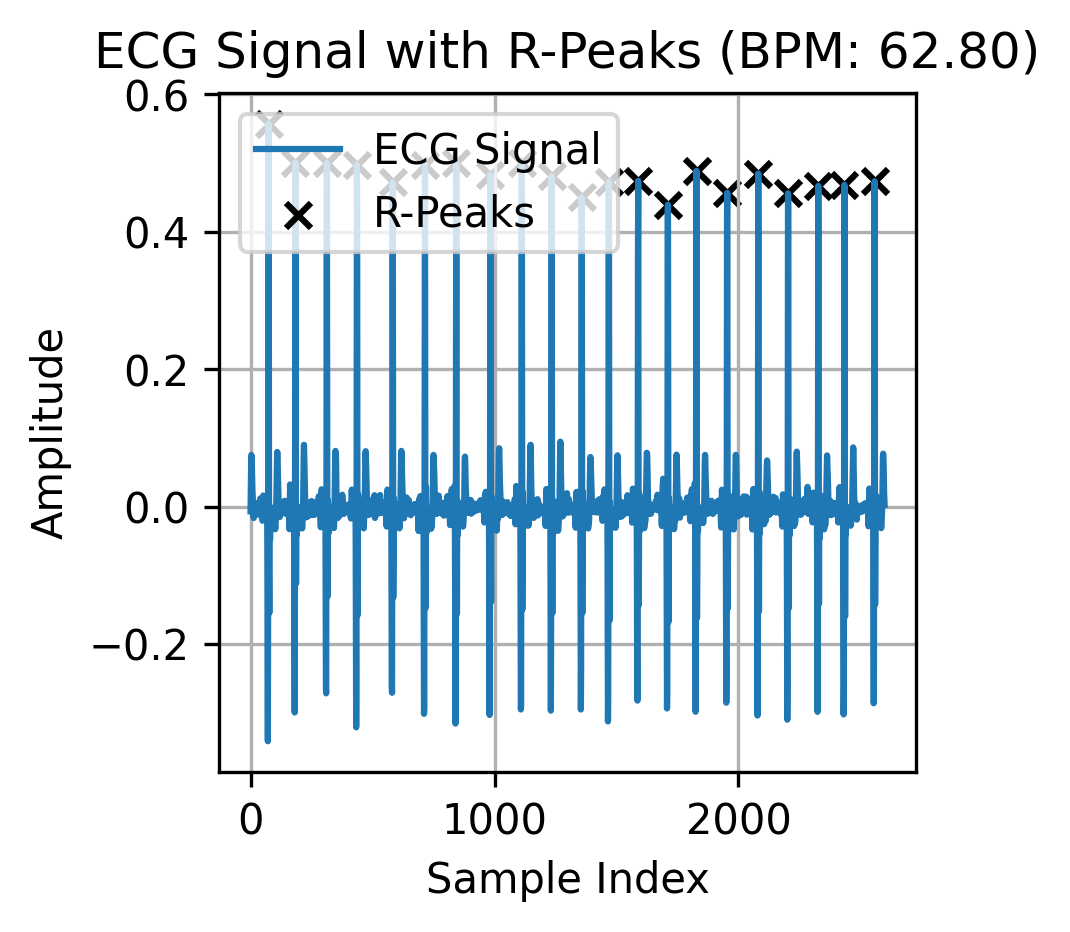

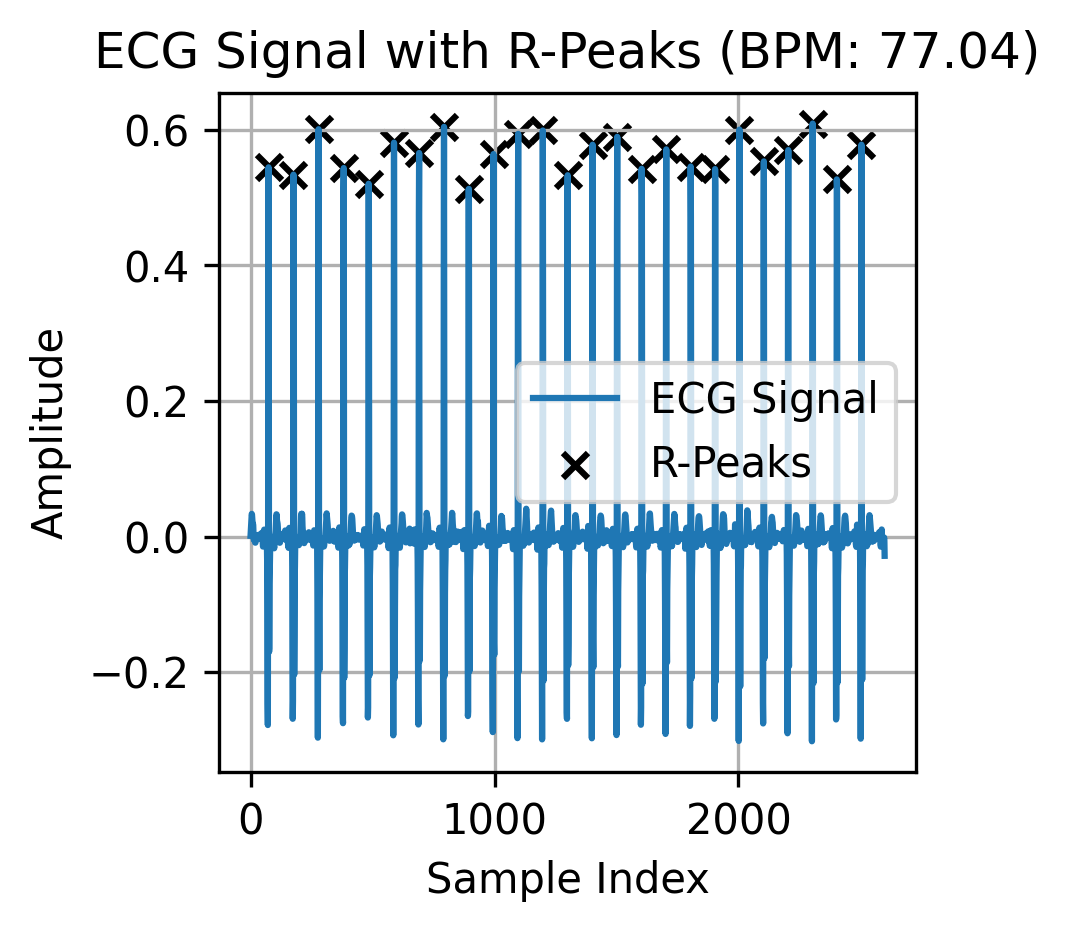

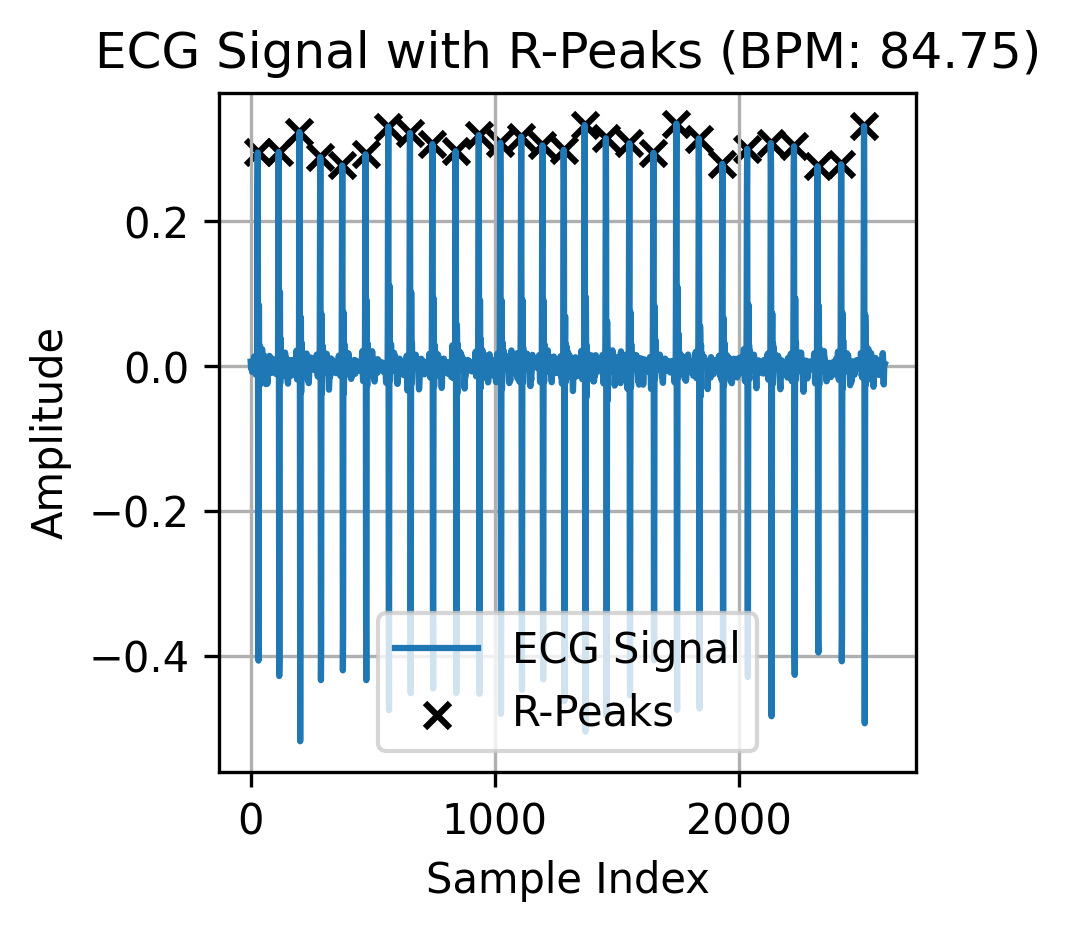

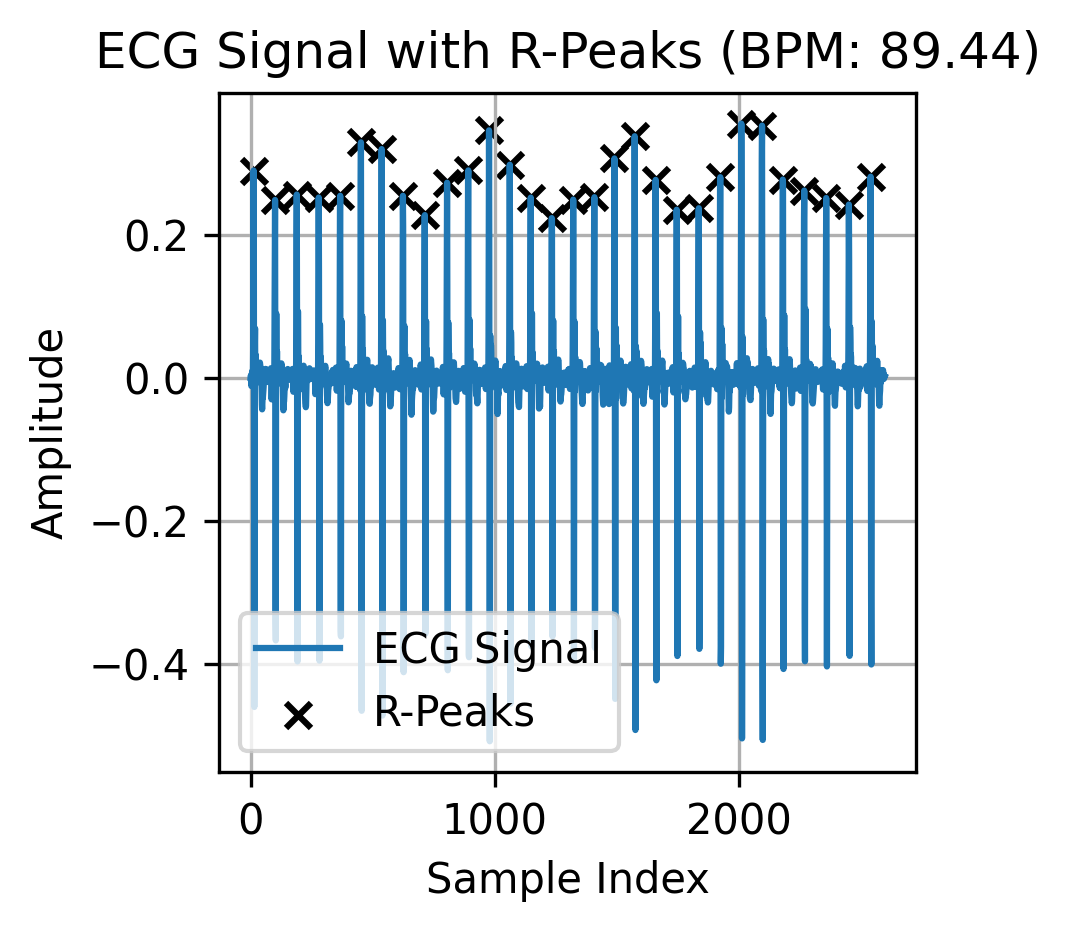

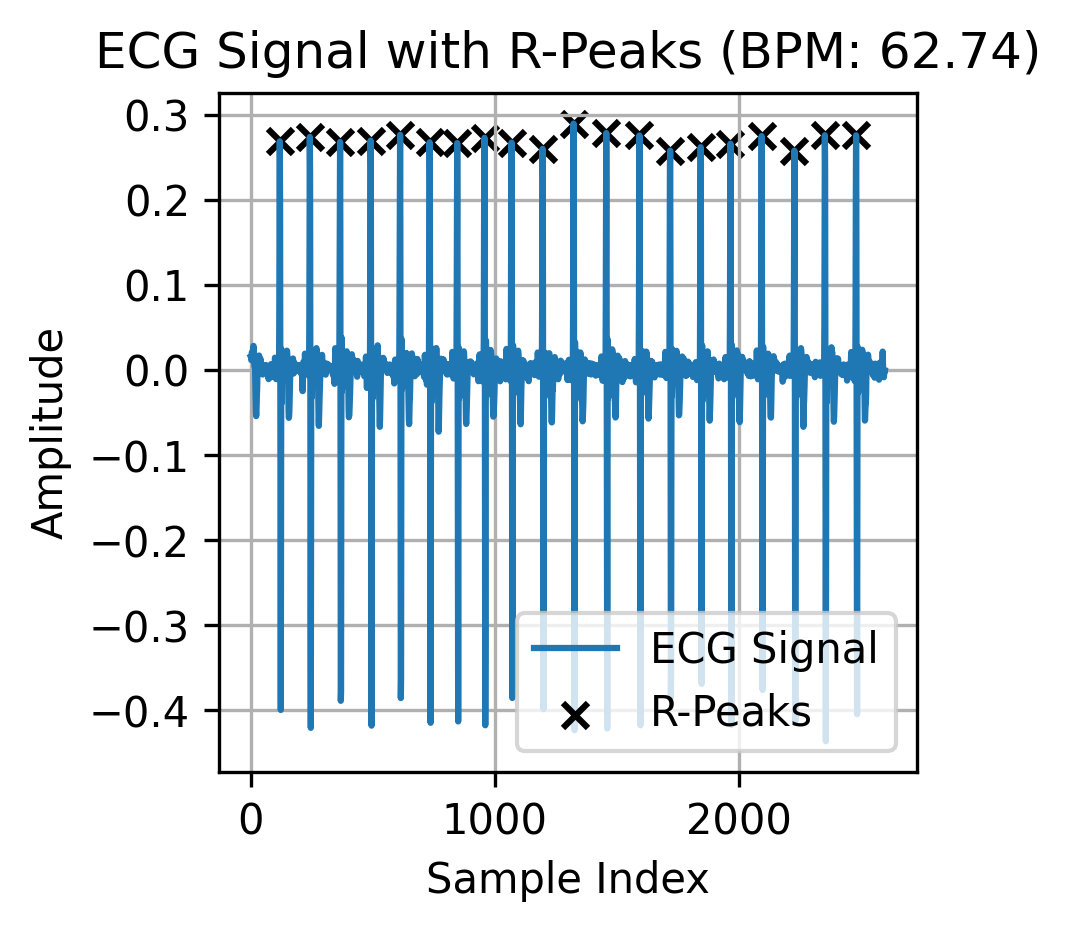

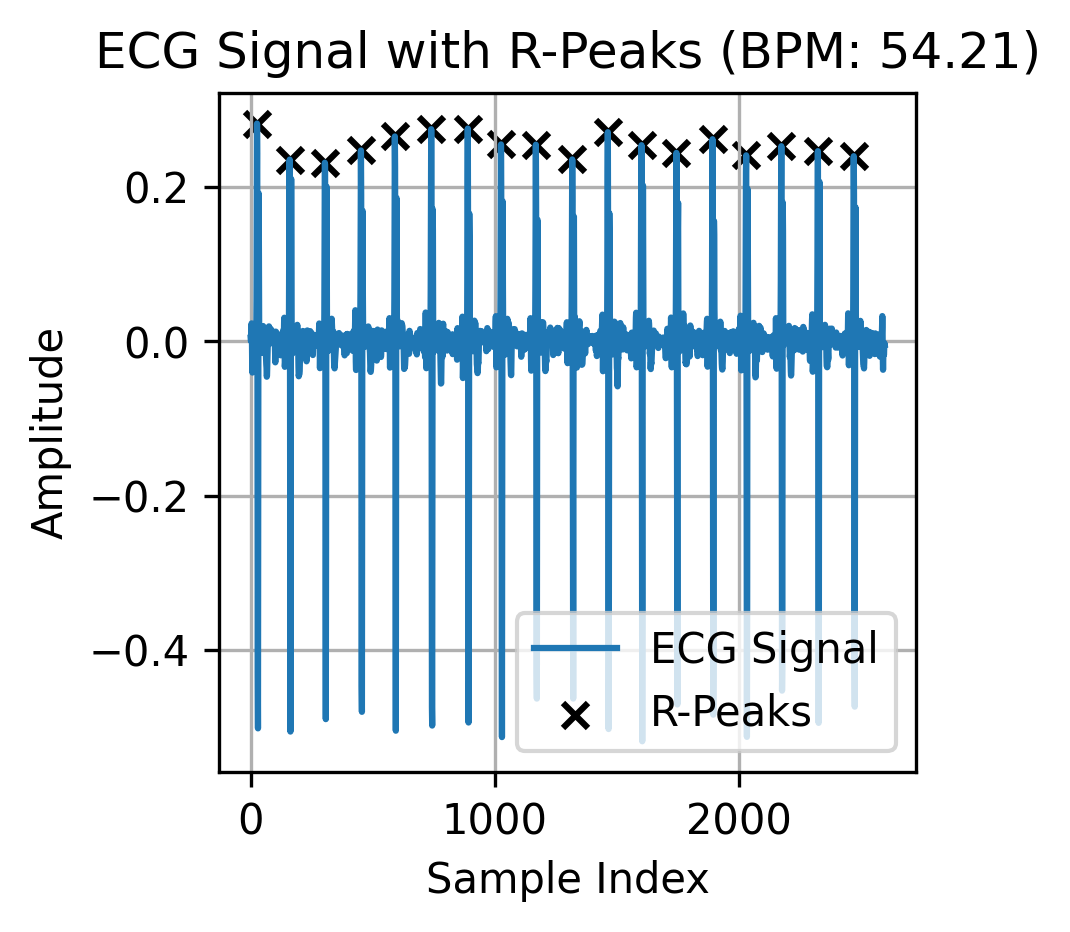

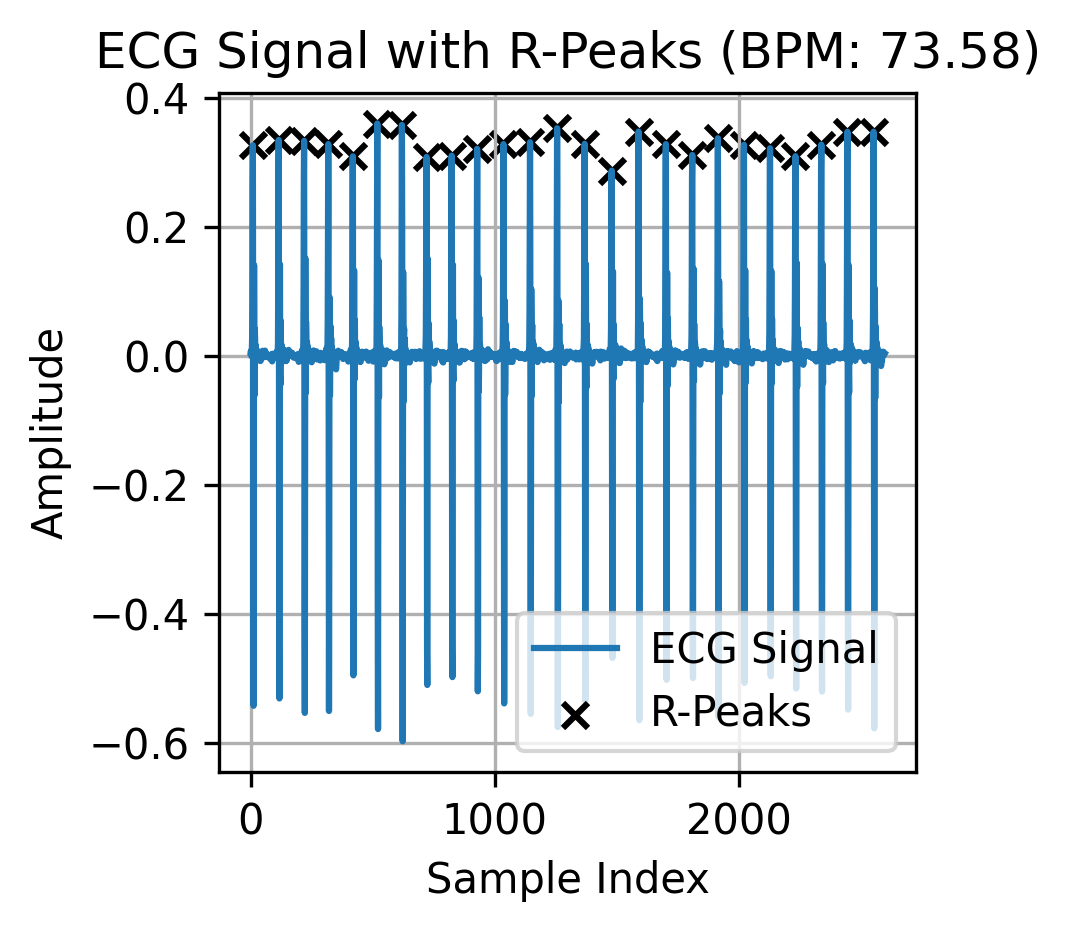

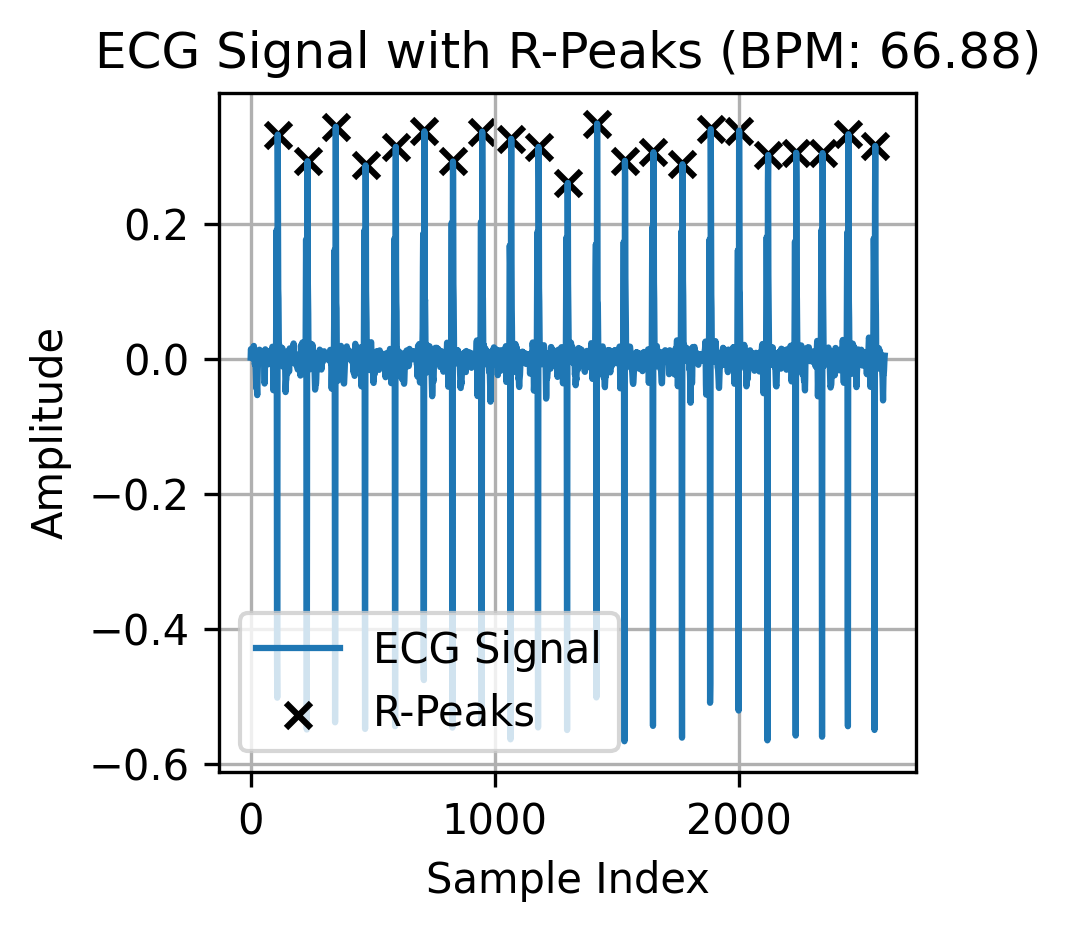

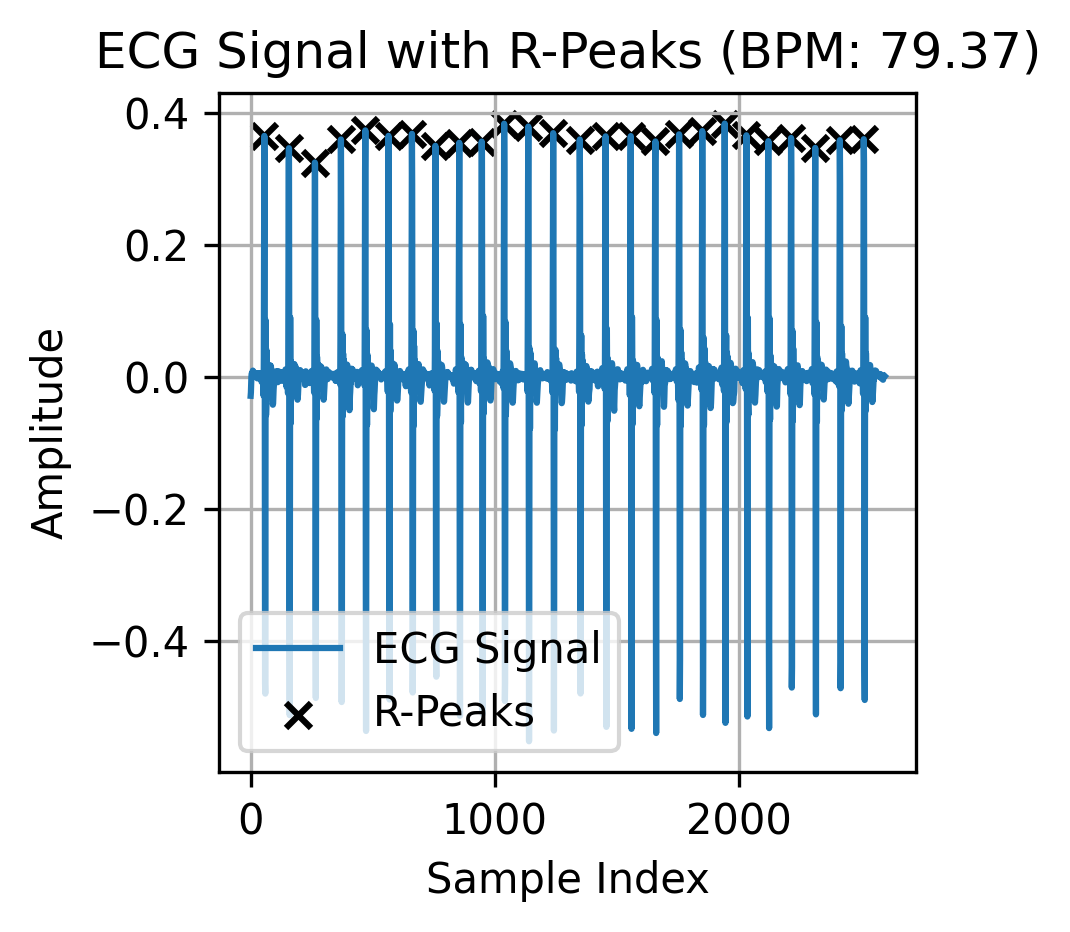

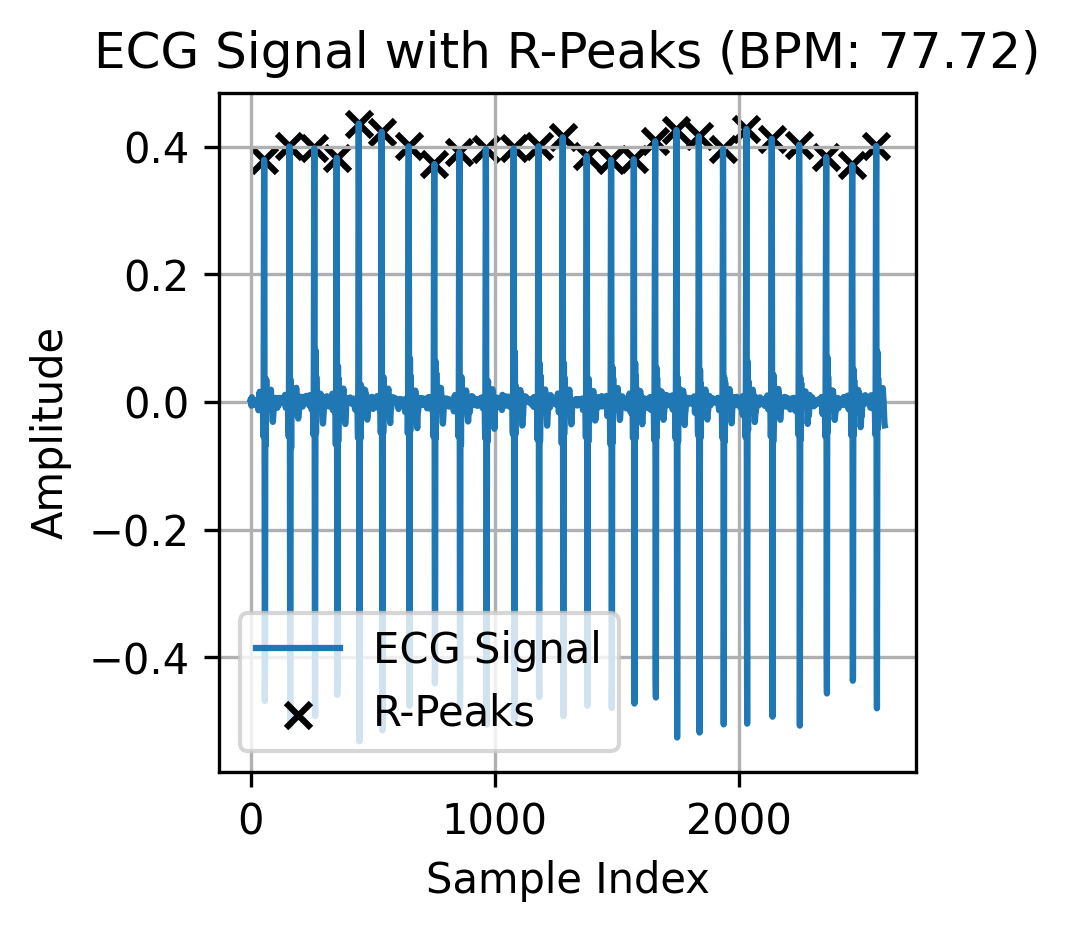

In [10]:
# generate GT (ECG method)
participants_gt = []

#some of the participant do not have Polar H10 data
ecg_trunc_files, participants_gt = find_ecg_trunc_files(directory)
n_participants = len(ecg_trunc_files)

sample_rate = 130
start = 0 #in seconds
end = 1058 * sample_rate #in seconds
length = end  - start 
ecg_data_2d = np.zeros((n_participants,length))
ecg_cleaned_2d = np.zeros((n_participants,length))

n = 0

#Some of the ECG signals are inverted, due to the chest strap sensor being placed upside down 
upside_down = [0,1,2,3,4,5,6,7,8,9,10,13,14,16,17,19,20,21,22,23,24,25,26,27,28,29,30]

for file_location in ecg_trunc_files:
        folder_name = os.path.basename(os.path.dirname(file_location))
        participant_ID, ecg_data = extract_ecg_data(file_location)        
        ecg_data_2d[n,:] = ecg_data[start:end]
        n += 1

ecg_hr = np.zeros((n_participants, int(length/sample_rate))) 

for n in range(n_participants):
    data = ecg_data_2d[n,:]
    cleaned = remove_baseline_wander(data)
    cleaned = filter_ecg_signal(cleaned)
    cleaned = (cleaned - np.mean(cleaned)) / np.ptp(cleaned)
    
    if n in upside_down:
        ecg_cleaned_2d[n,:] = -1 * cleaned 
    else:
        ecg_cleaned_2d[n,:] = cleaned

for n in range(n_participants):
    # Plot the ECG signal with RR peaks and calculate BPM at 1Hz
    plot_ecg_with_rr_and_bpm(ecg_cleaned_2d[n,101400:104000], sampling_rate=sample_rate)

inst_bpms = np.zeros((n_participants, length))

for n in range(n_participants):
    inst_bpms[n, :] = calc_instantaneous_bpm(ecg_cleaned_2d[n, :], sampling_rate=sample_rate)

In [13]:
hr_gt = np.zeros((len(participants_gt), duration))

for n in range(len(participants_gt)):
    # Apply the window with stride to the signal
    sig = apply_window_stride(inst_bpms[n,:], w_length, 1) #stride is always 1
    hr_gt[n,:] = sig[0:duration] #this is in seconds now

In [14]:
#Match arrays so we only have participants for which there is camera and ecg data
unique_to_array1 = np.where(np.isin(participants_pyvhr, participants_gt, invert=True))[0]

participants_common = np.delete(participants_pyvhr, unique_to_array1)
hr_est_common = np.delete(hr_est, unique_to_array1, axis = 0) 
hr_gt_common = hr_gt

In [15]:
# Load and clean Qualtrics data
qualtrics = pd.read_csv("qualtrics.csv").drop(index=[0, 1])

# Filter out ineligible participants, from pilot study
ineligible_participants = qualtrics.loc[qualtrics['Eligible'] == 'No', "ResponseId"].values

# Find indices of ineligible participants in the 'participants_common' list
ineligible_indices = np.isin(participants_common, ineligible_participants)

# Create datasets that only include eligible participants
common_eligible_indices = ~ineligible_indices
participants_common_eligible = participants_common[common_eligible_indices]
hr_est_common_eligible = hr_est_common[common_eligible_indices]
hr_gt_common_eligible = hr_gt_common[common_eligible_indices]

In [16]:
#B = R_1FRpvfBQgLBmdEs (Negative comments)
#C = R_1fd4klHEPku0Ebs (low ISC-HR)
#D = R_3prGTAiPEjpQn75 (Fast and decellaring HR)
#E = R_1K3bEG3oeMWpvEH (High immersion score, low ISC-HR)

# specify outliers to be removed
outliers = [''] 

# Find indices of these outliers in the 'participants_common_eligible' list
outlier_indices = np.isin(participants_common_eligible, outliers)

# Create mask to filter out these outliers
mask_no_outliers = ~outlier_indices

# Create datasets excluding the specified outliers
hr_gt_common_eligible_no_outliers = hr_gt_common_eligible[mask_no_outliers]
hr_est_common_eligible_no_outliers = hr_est_common_eligible[mask_no_outliers]
participants_common_eligible_no_outliers = participants_common_eligible[mask_no_outliers]

In [17]:
hr_gt_working = hr_gt_common_eligible_no_outliers
hr_est_working = hr_est_common_eligible_no_outliers
participants_working = participants_common_eligible_no_outliers

# Use pd.Categorical to specify the desired order
qualtrics['ResponseId'] = pd.Categorical(qualtrics['ResponseId'], categories=participants_working, ordered=True)

# Sort the DataFrame based on the 'ResponseId' column
qualtrics = qualtrics.sort_values('ResponseId').reset_index(drop=True)
qualtrics.dropna(subset=['ResponseId'], inplace=True)

immersion_scores = qualtrics['SC0'].to_numpy(dtype = float)
groups = qualtrics['Group'].to_numpy(dtype = str)

Difference in median:  71.0
MannwhitneyuResult(statistic=120.0, pvalue=0.7914998747785833)


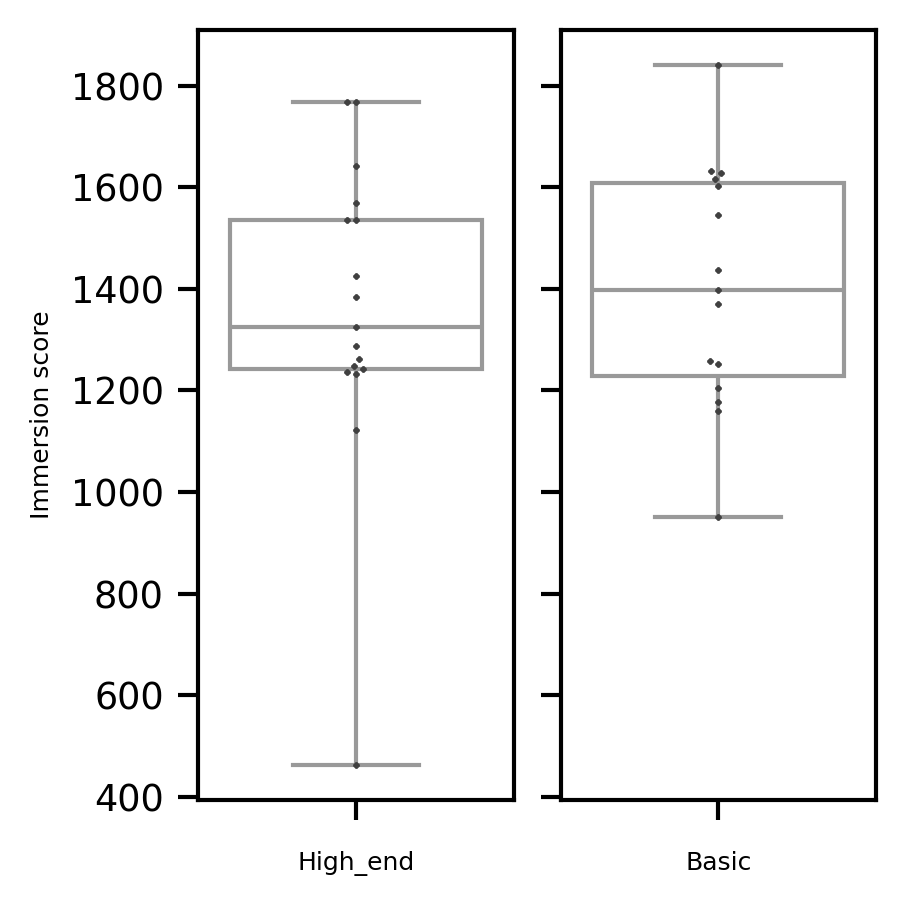

In [18]:
#Immersion score between groups analysis
grouped_values = [immersion_scores[groups == 'A'], immersion_scores[groups == 'B']]
group_names = ['High_end', 'Basic']

create_box_plots(grouped_values, group_names, "Immersion score", sharey = True)

print("Difference in median: ", abs(np.median(immersion_scores[groups == 'A']) - np.median(immersion_scores[groups == 'B'])))

print(scipy.stats.mannwhitneyu(immersion_scores[groups == 'A'], immersion_scores[groups == 'B']))

R_bHI6b3OCjxEKPx7
97.54092729271356


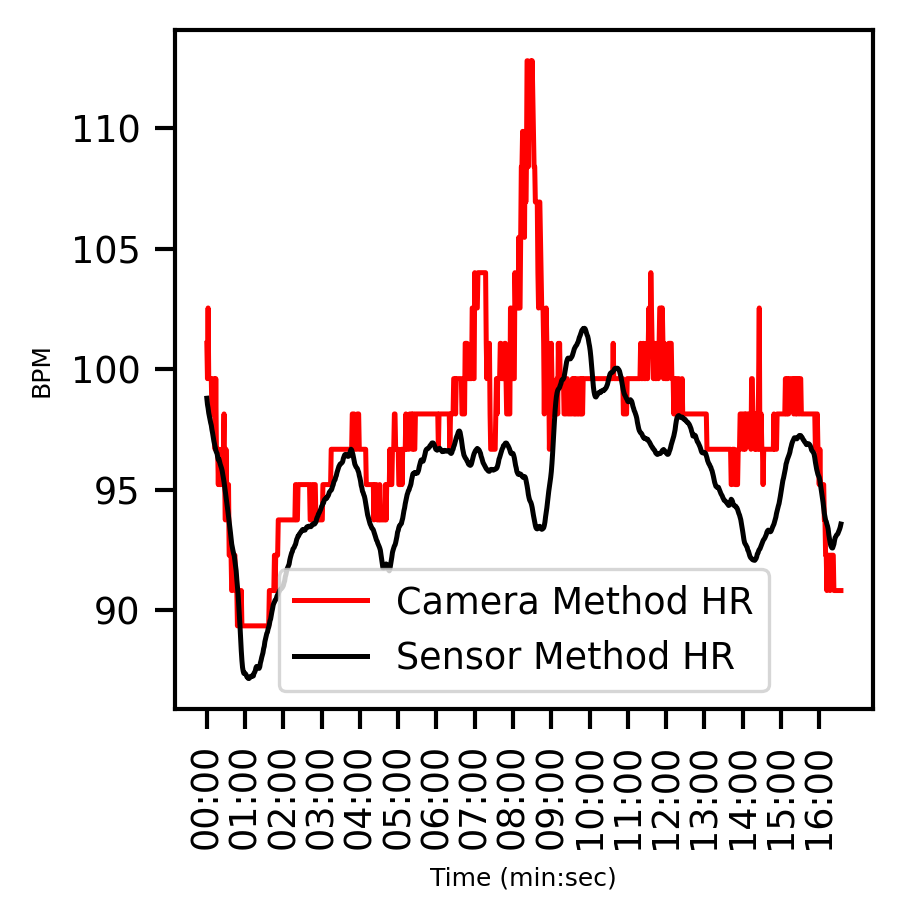

R_3prGTAiPEjpQn75
103.89496309673366


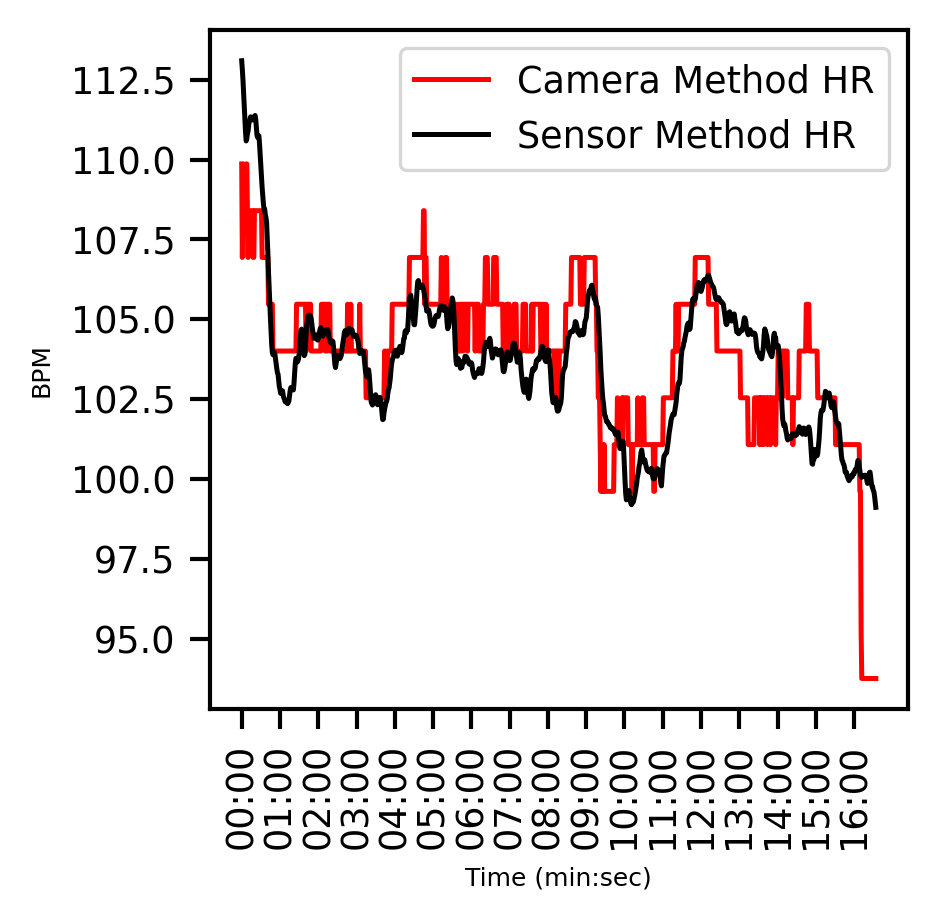

R_3IaxwlNH4B0nPfh
92.30871152638191


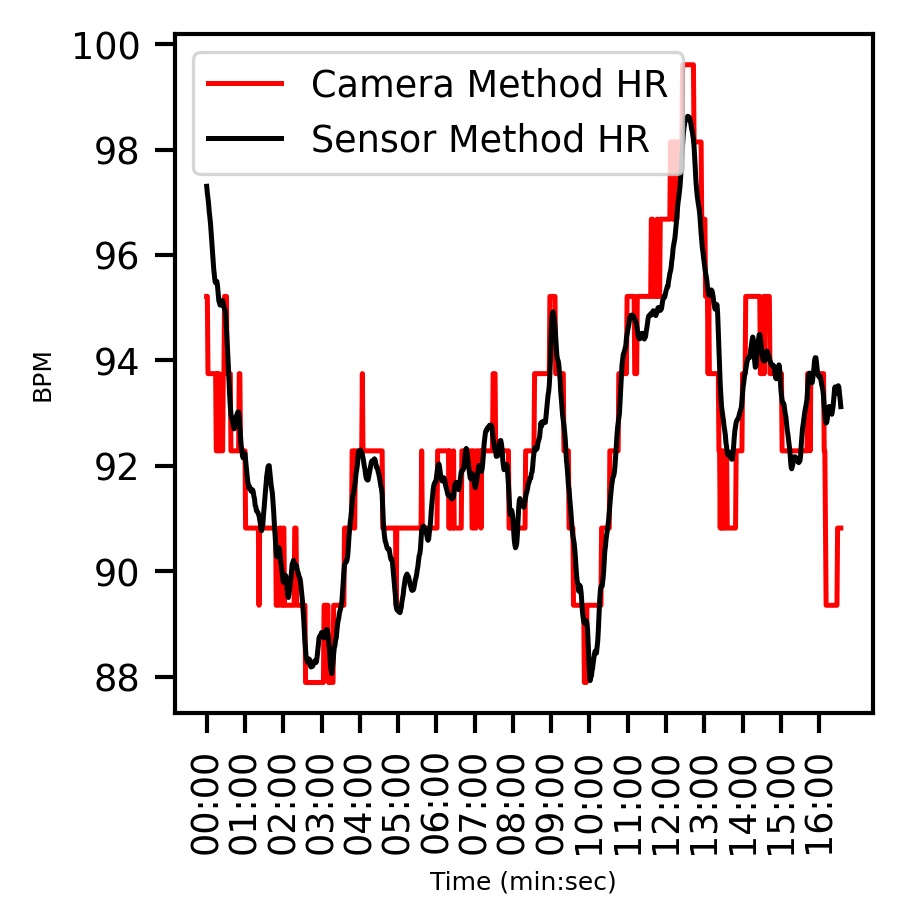

R_8p7iH4DnPMeva4V
66.05930040829146


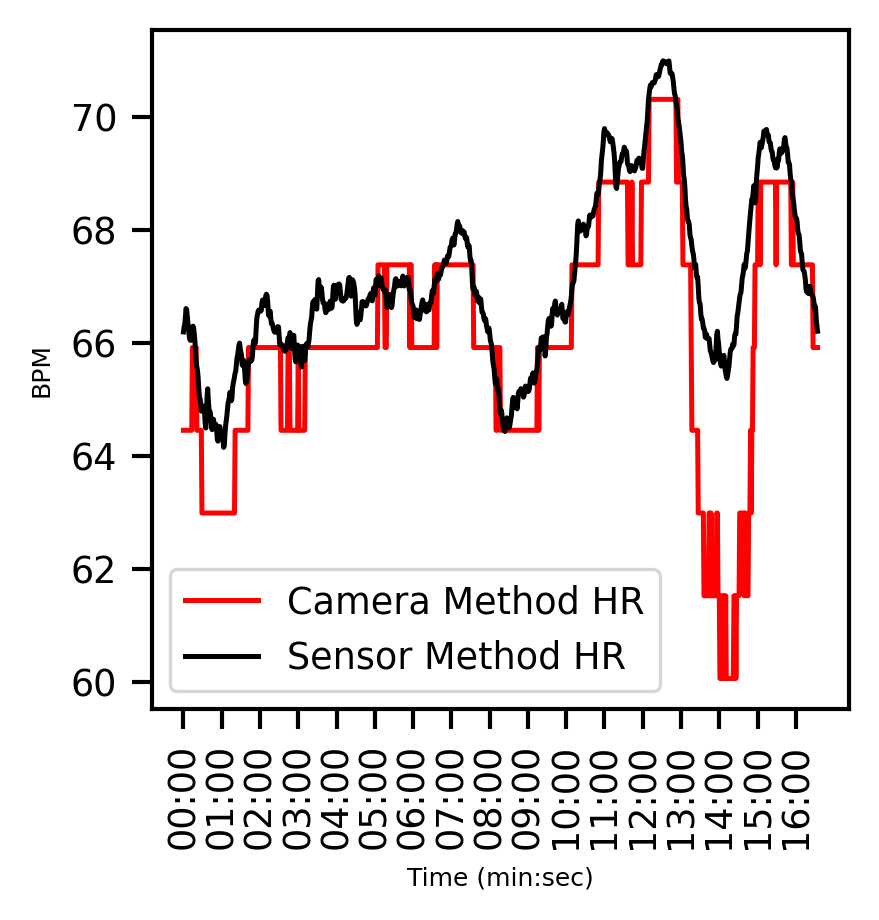

R_r798d2tUx9pXWYV
87.28702104271356


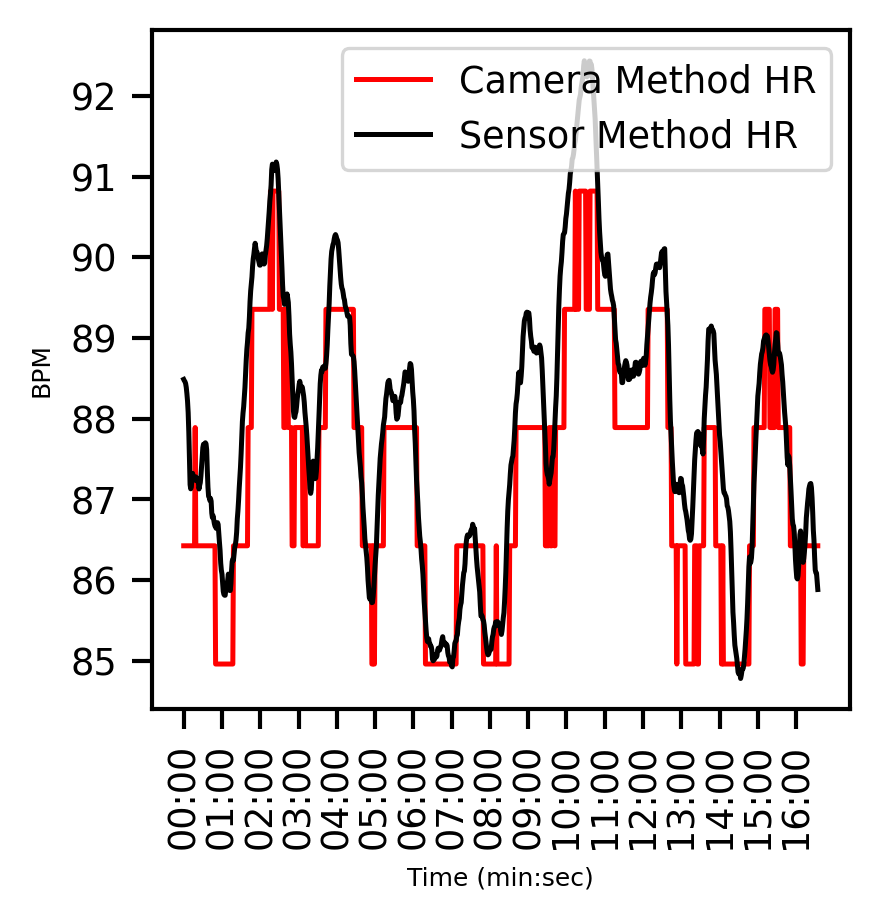

R_TuOM7SHtYl58aml
72.59294519472361


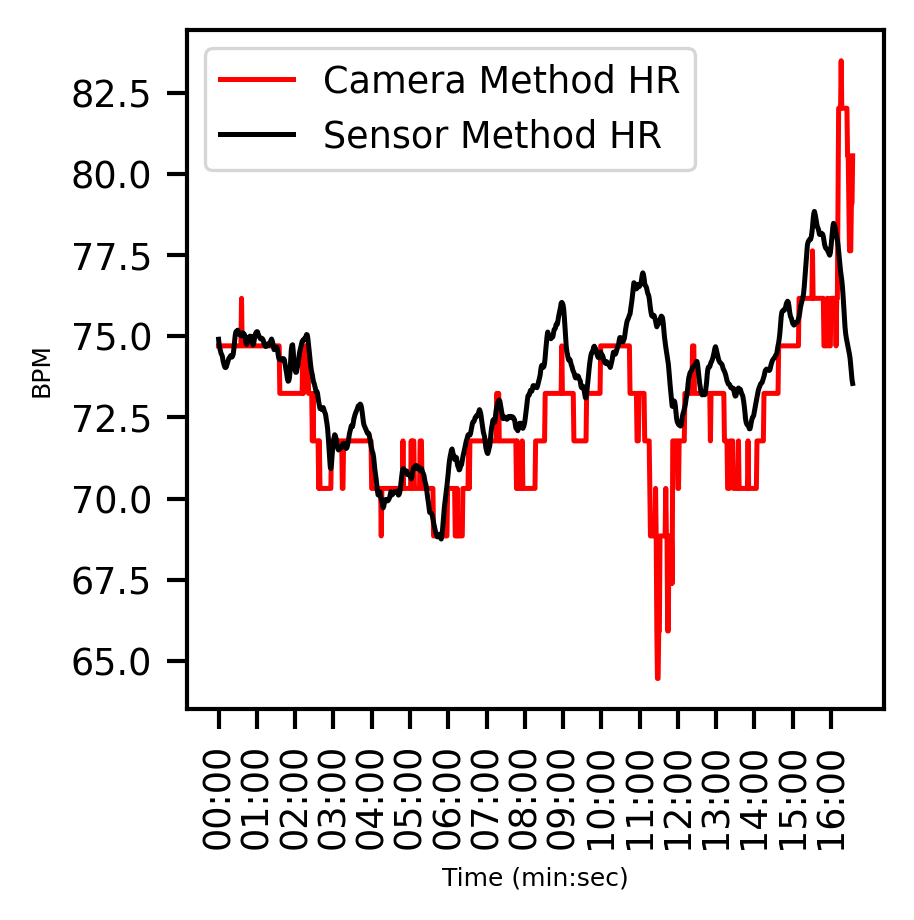

R_1Dvzw0GIqmt0Elm
60.255869189698494


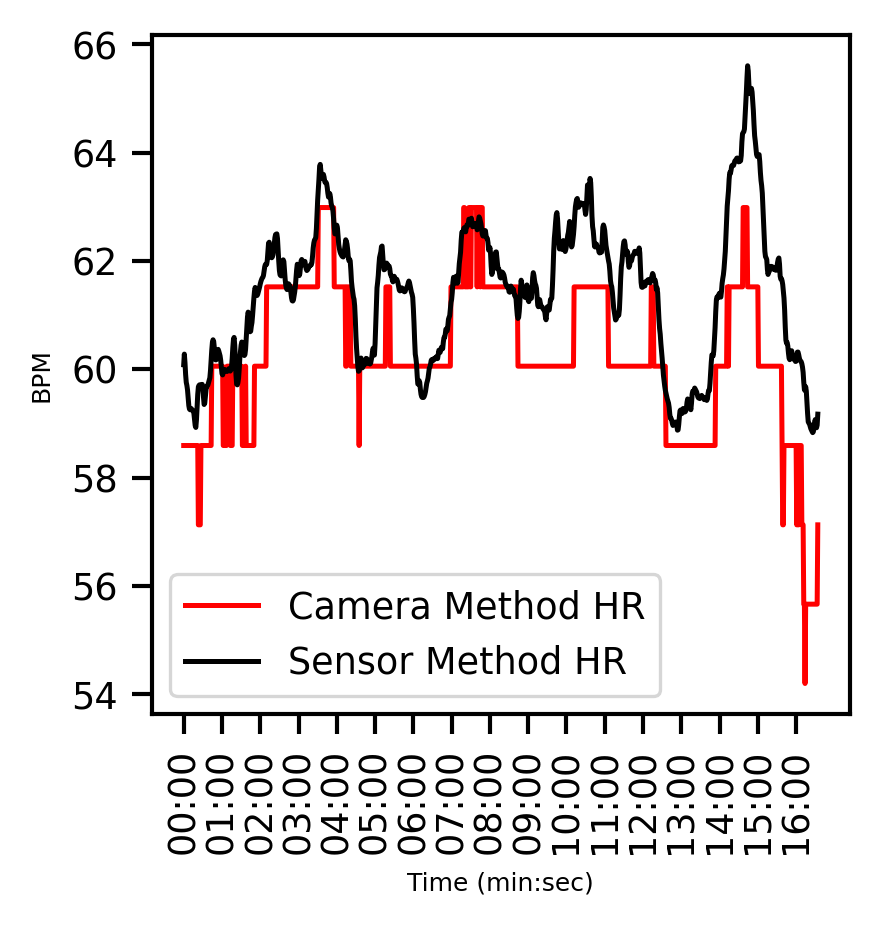

R_1eOBJ4Iy5nA2LLG
88.8460858982412


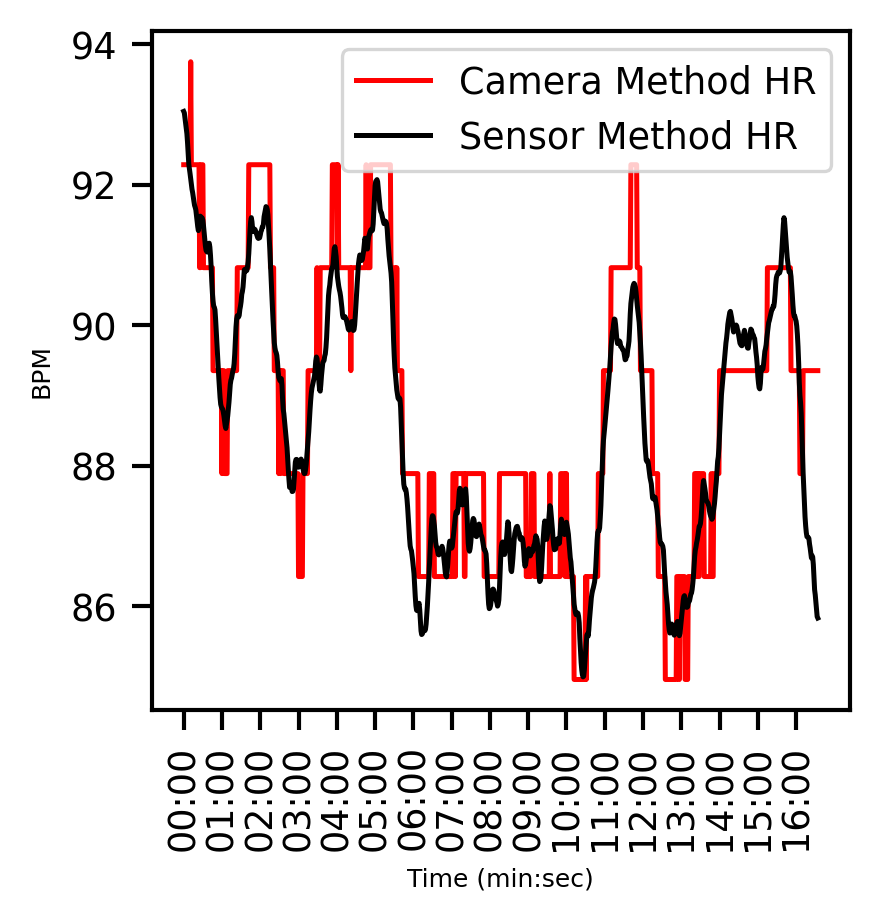

R_1fd4klHEPku0Ebs
66.10641096105527


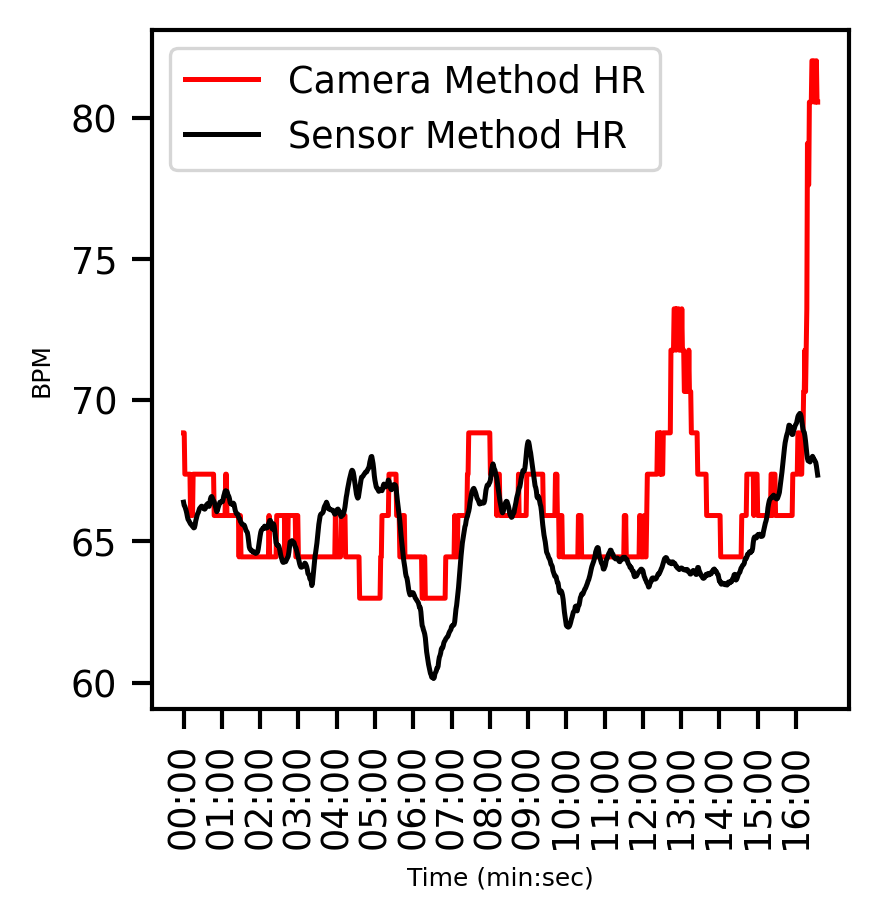

R_1FRpvfBQgLBmdEs
86.03711918969849


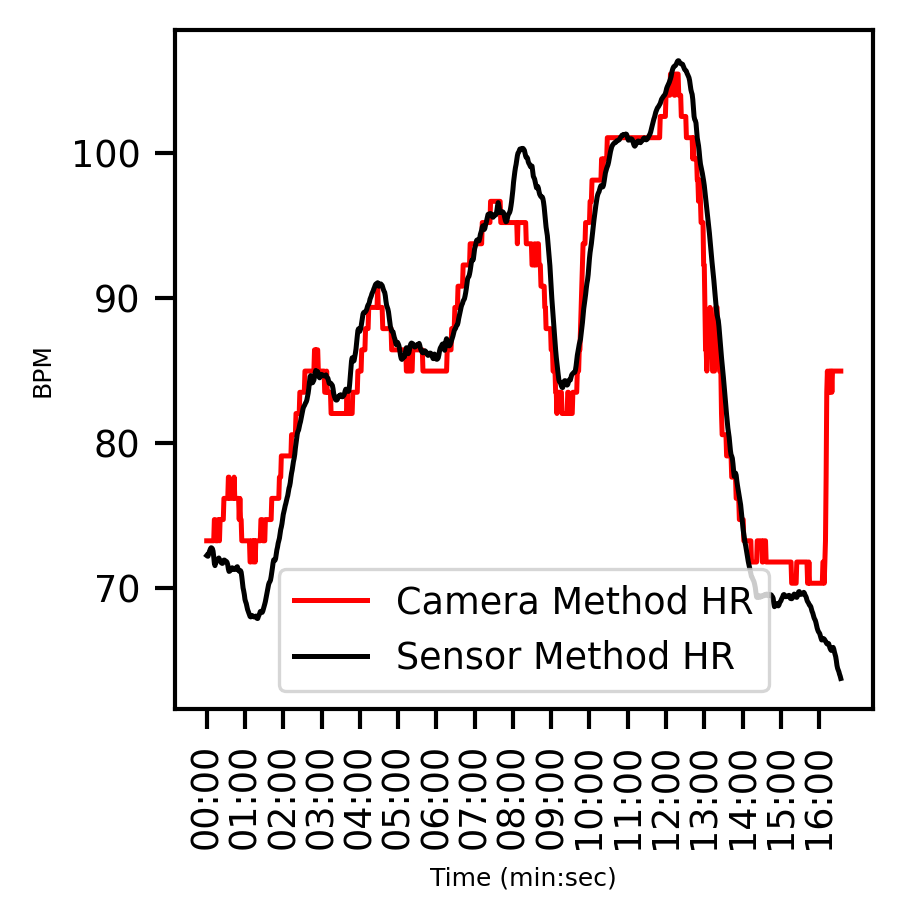

R_1K3bEG3oeMWpvEH
75.52557710427136


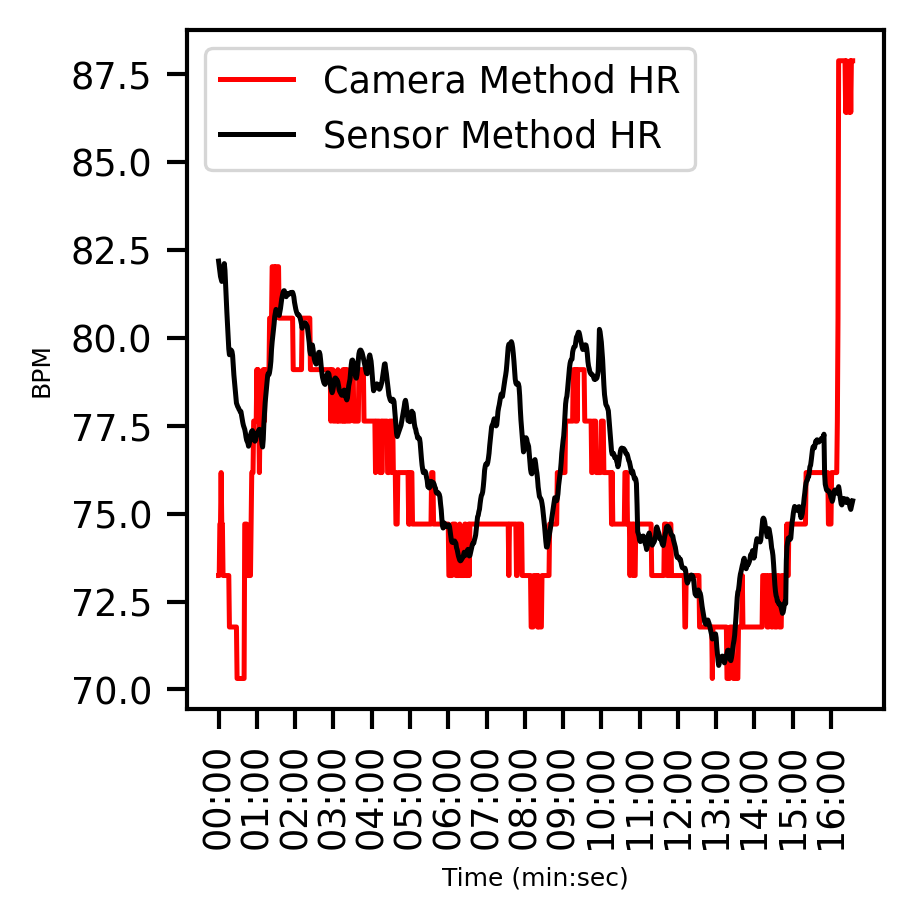

R_1kGq3T7VzXkPLxz
77.79718907035176


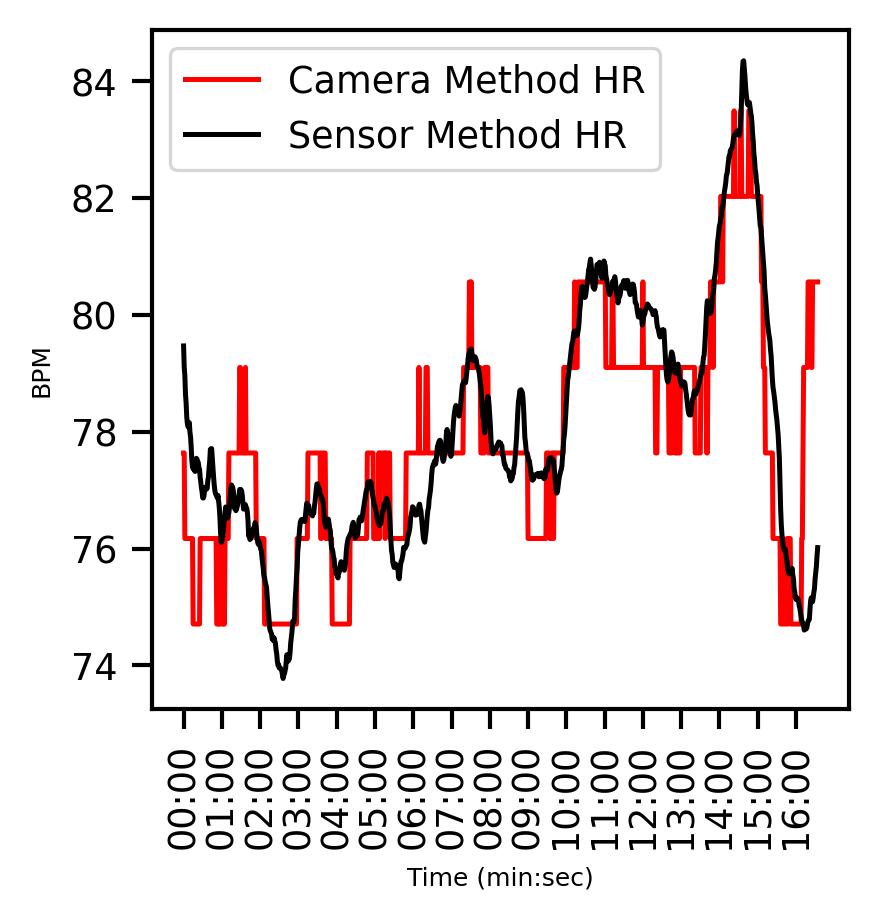

R_1lsrFqOAUFzszJl
79.88771984924622


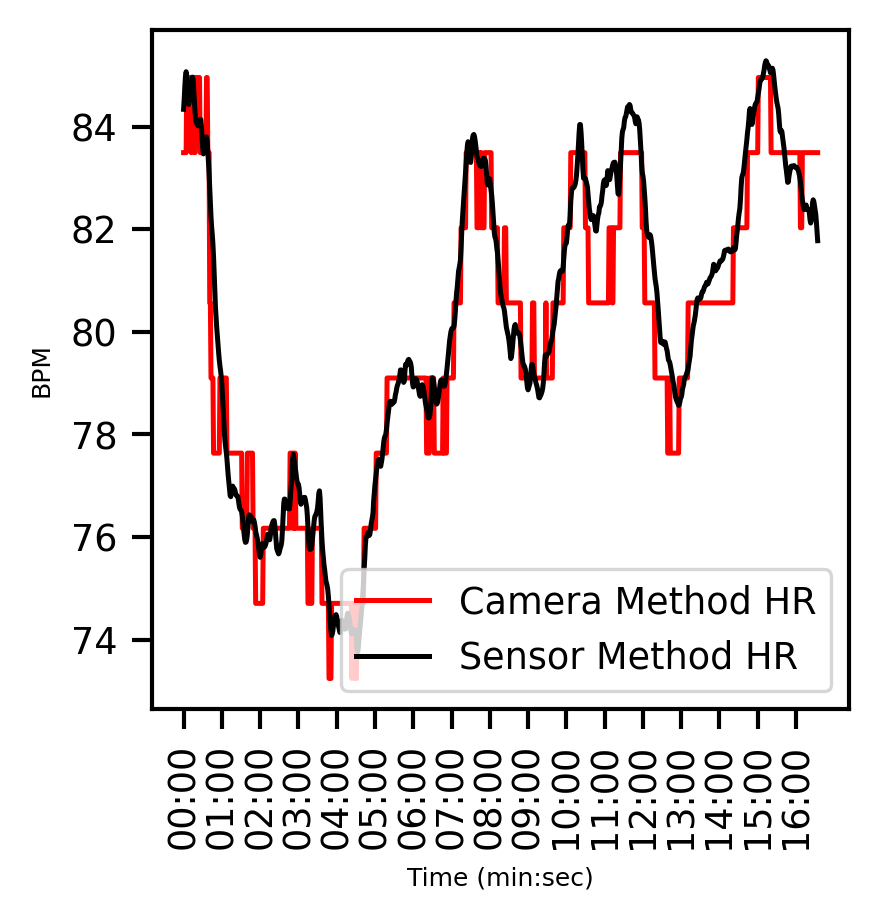

R_1QaRbBwnDzcyeOu
85.05074199120602


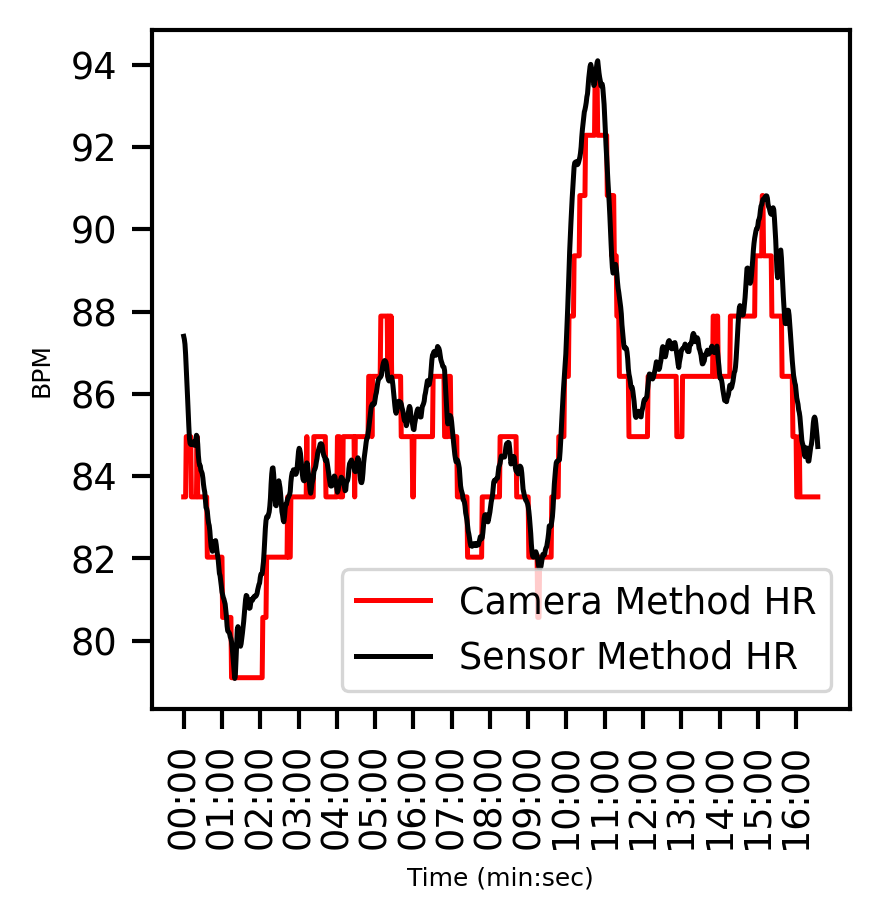

R_1QDB59T94KIbKLH
77.30326436871859


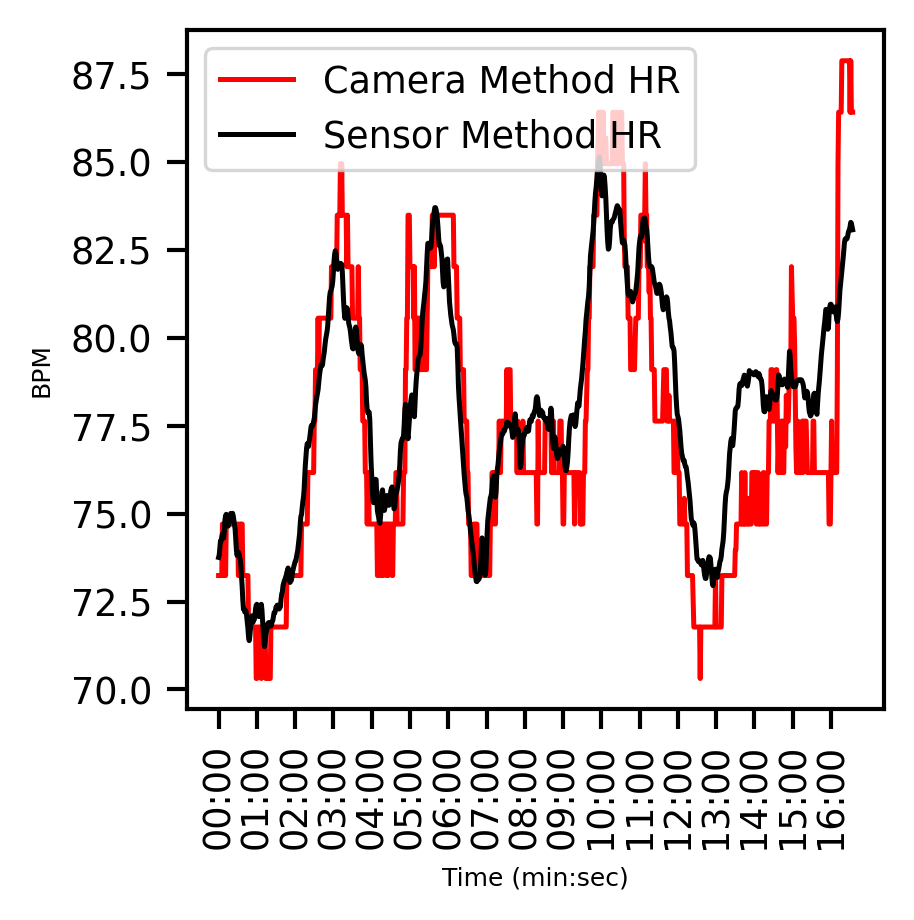

R_1r34MlXvLf1GkIz
66.03574513190955


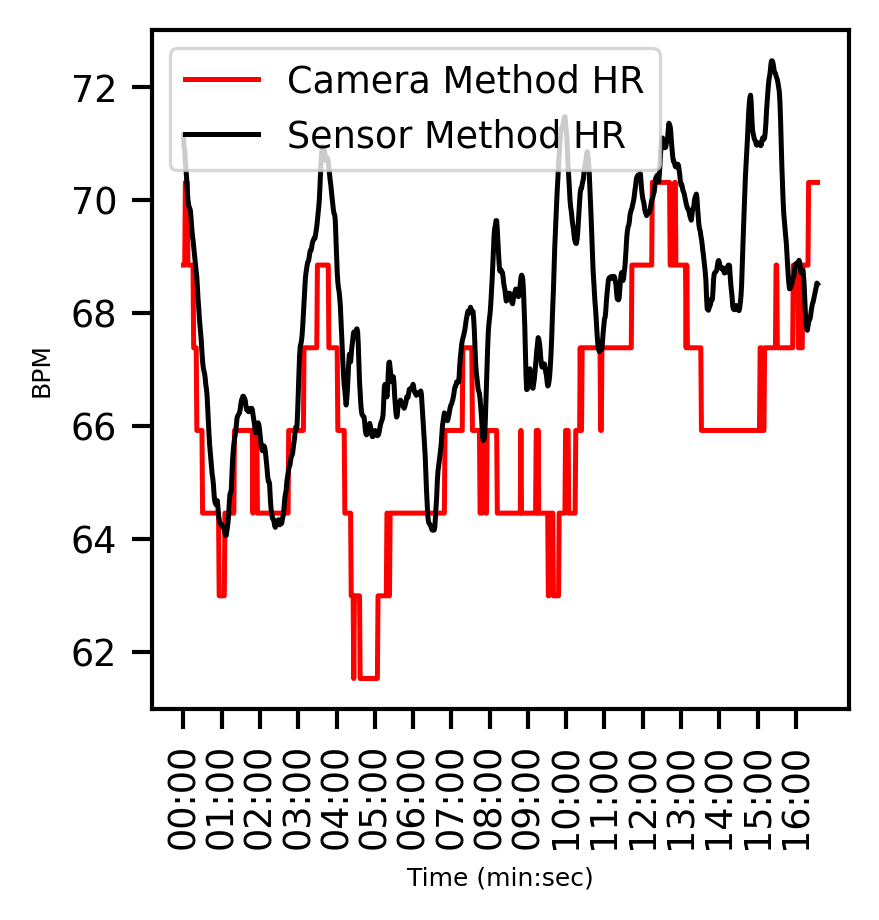

R_1rMk0PvxWGaqheZ
64.62831736809045


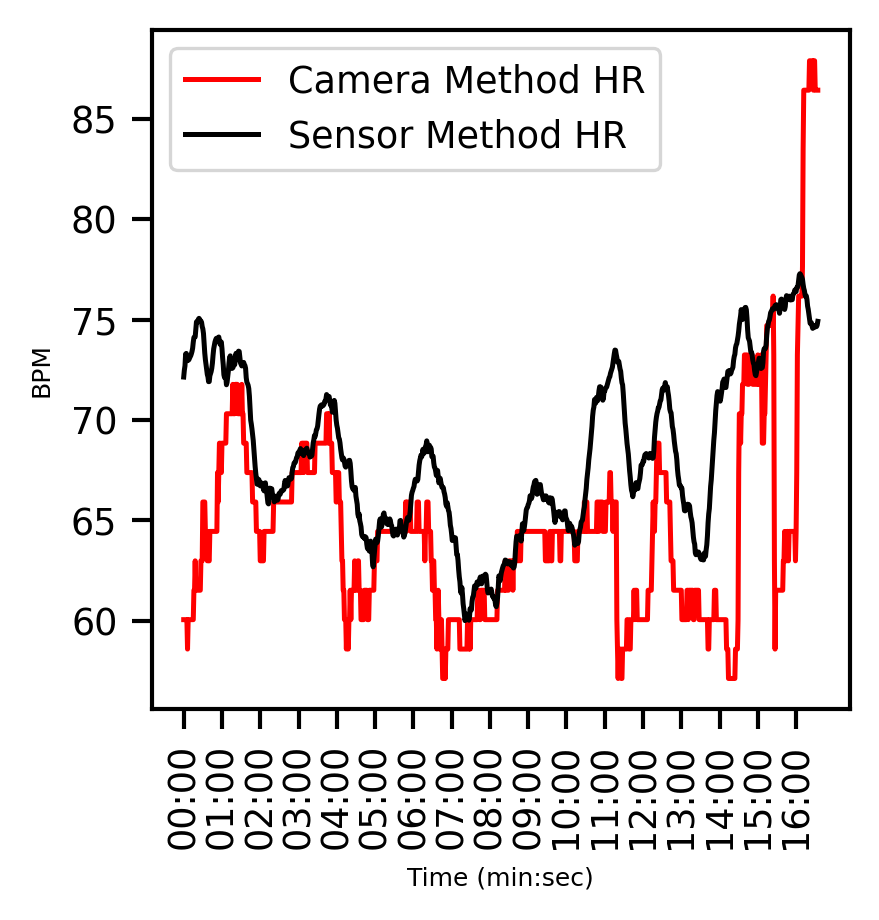

R_2aJOivDBdZ2B6hD
78.85864871231156


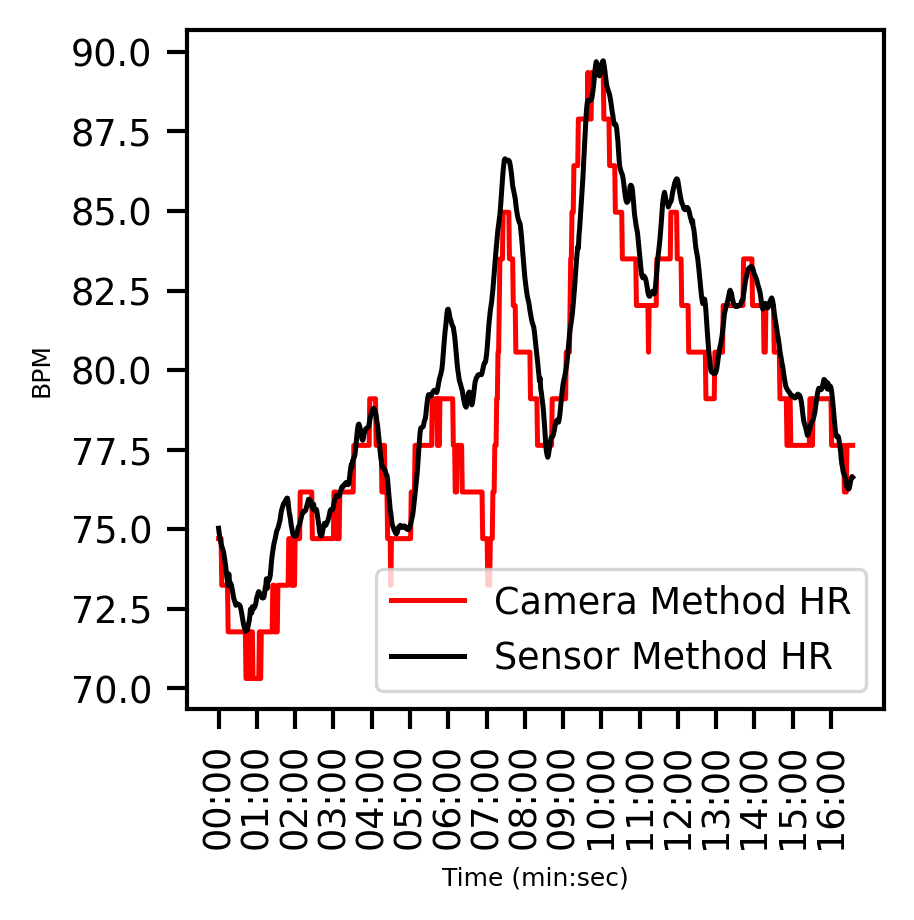

R_2CJLXVg9CnXoldB
84.55166457286433


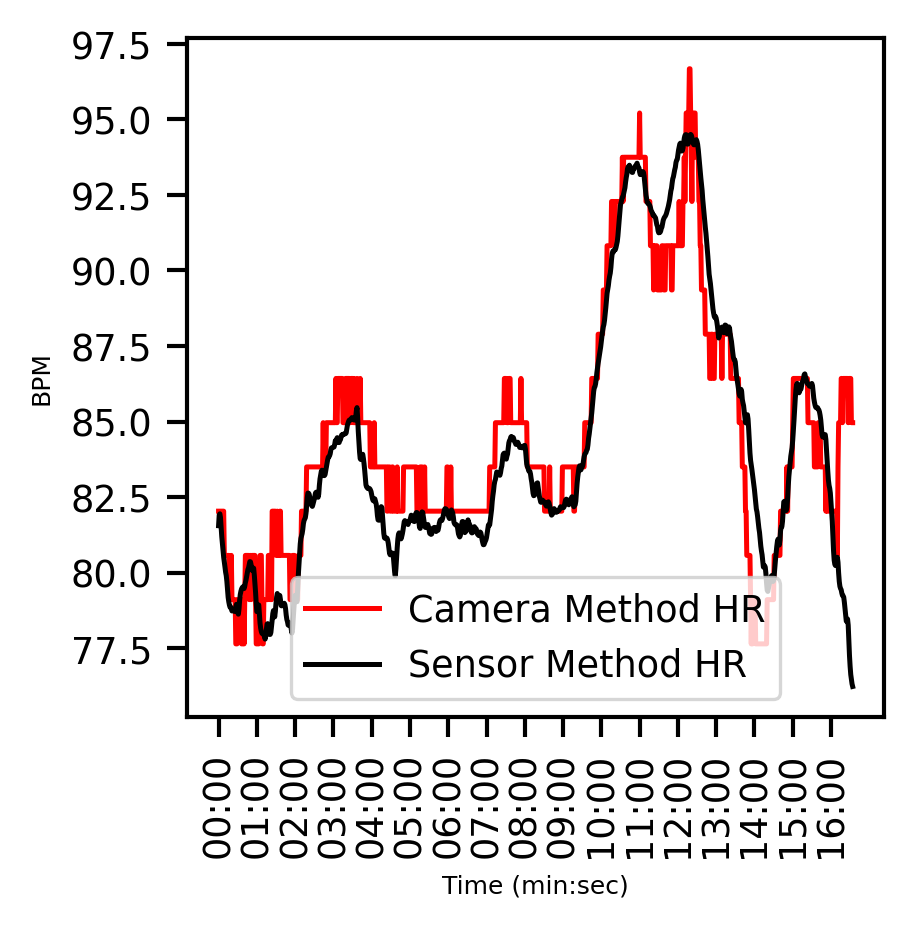

R_2Ei0PulXjuvDbpZ
81.87814070351759


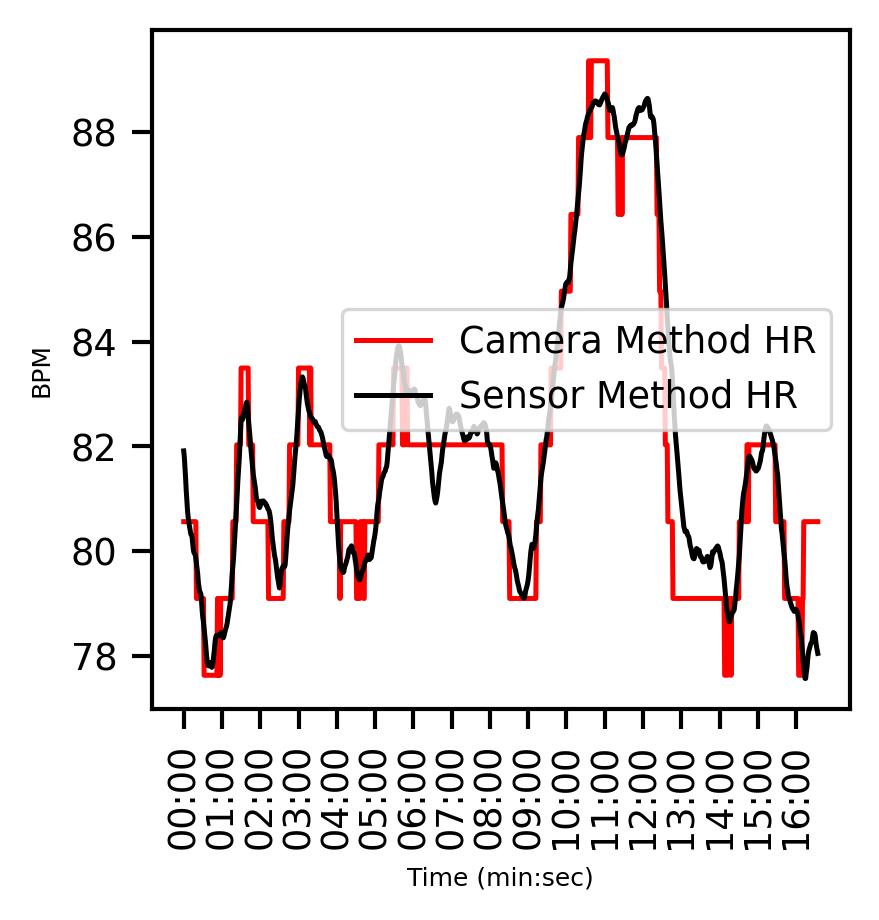

R_2eOsaw9rqxQ1dsv
72.0703125


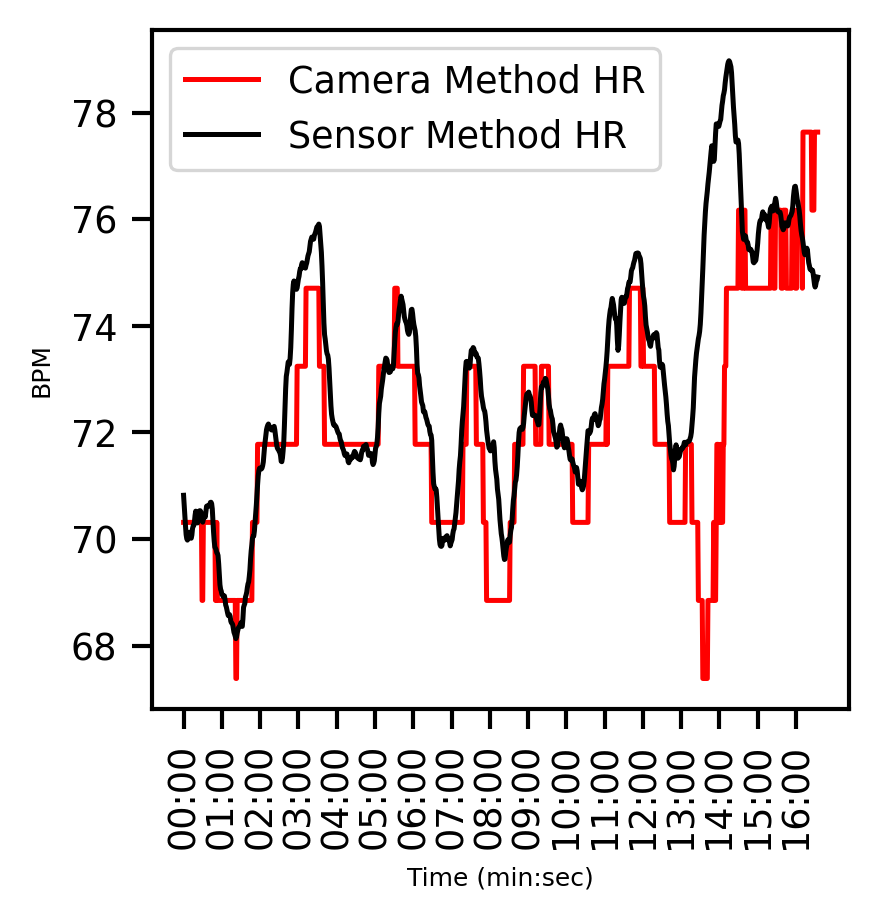

R_2SkNIP4Ds6aigPj
56.07775204145729


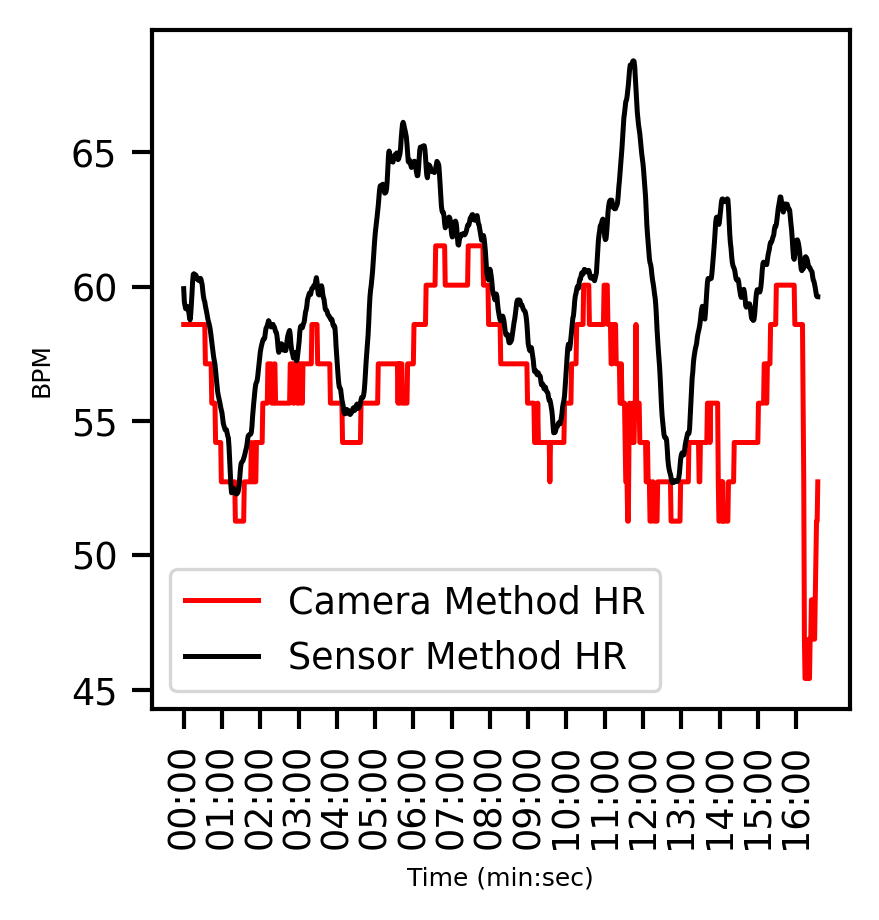

R_2VmOboy9TLtQe8o
63.44981744660804


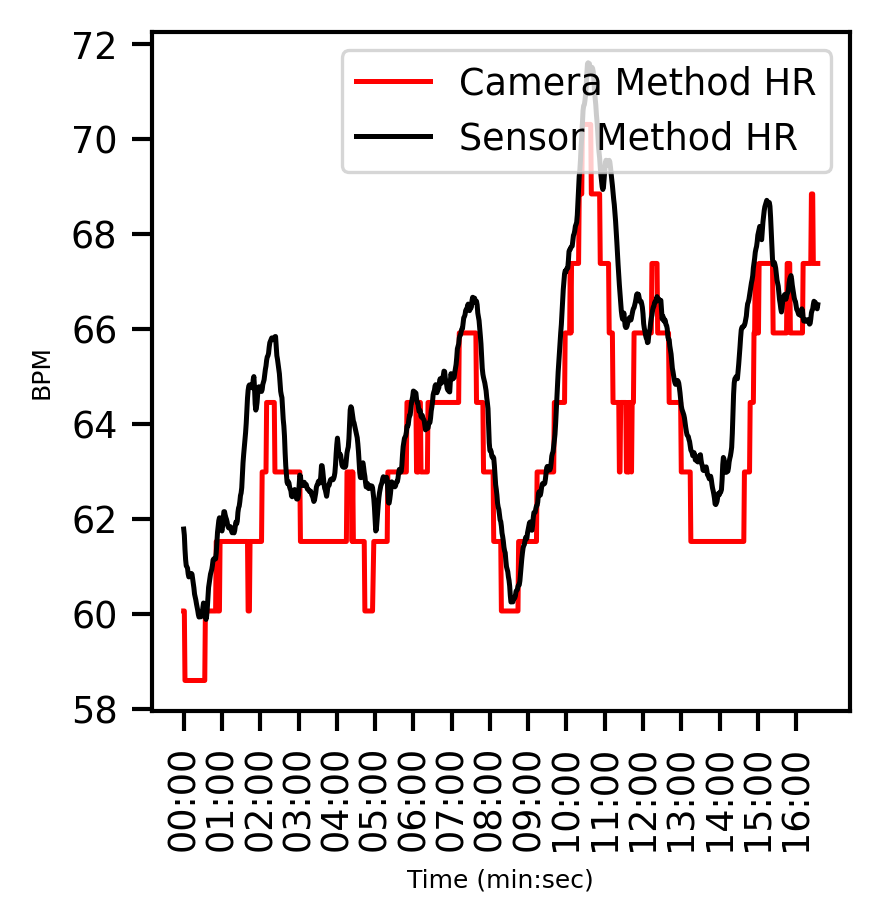

R_2wdJf7BqYjhYKO3
81.47181218592965


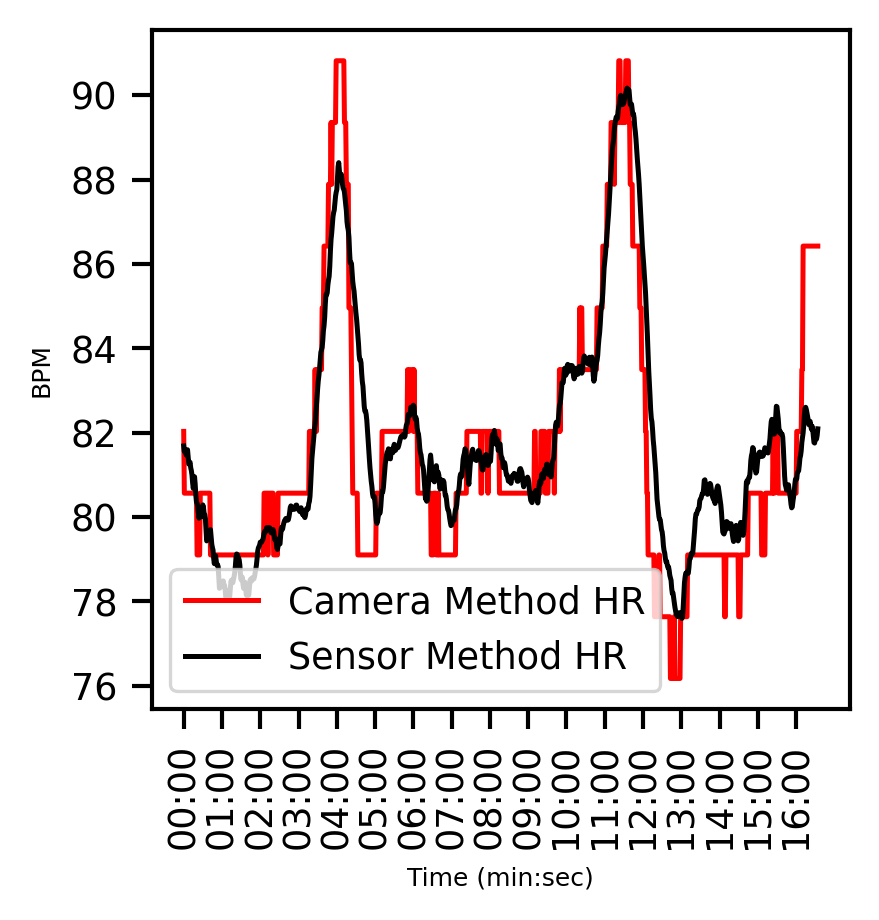

R_2xY7j0GNgTZsWVL
50.2272102701005


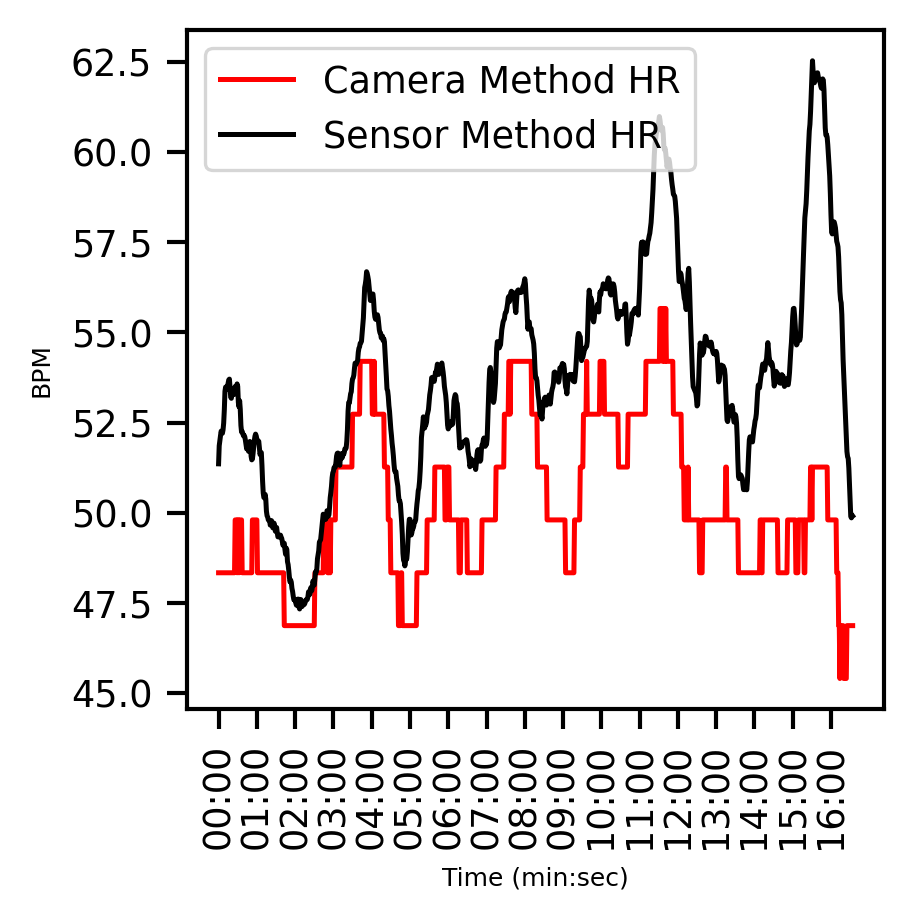

R_3HMM0xF3hGsjyjD
83.6595084798995


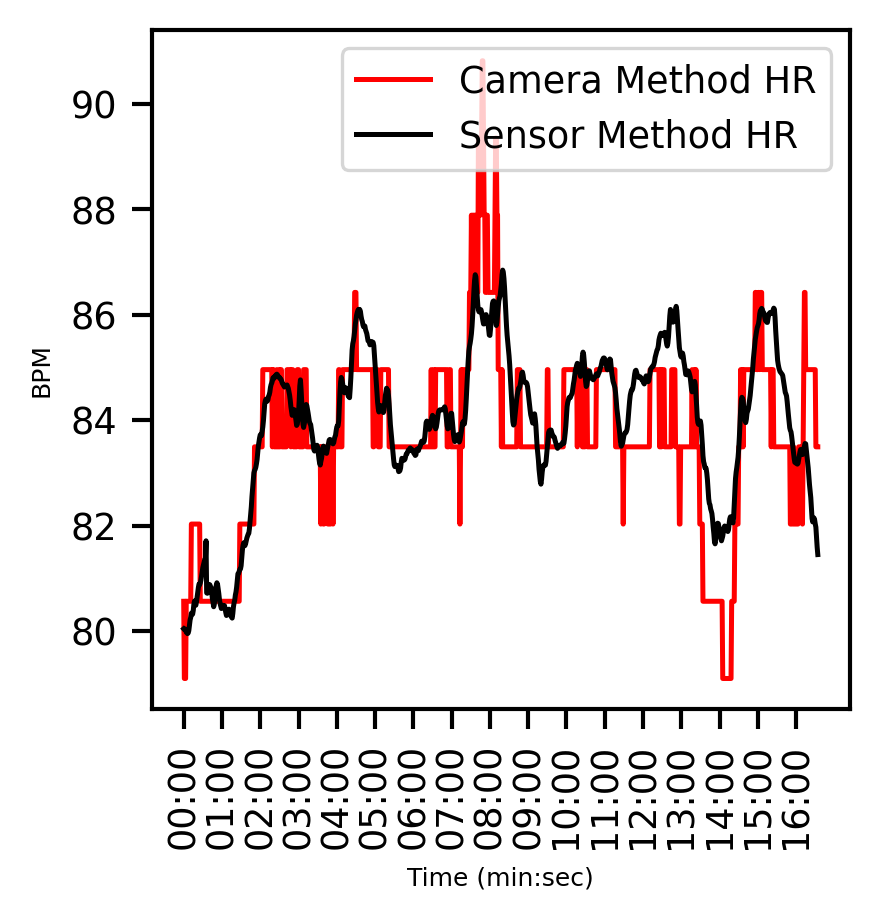

R_3NCa9qlBBqZivh2
83.89800565326634


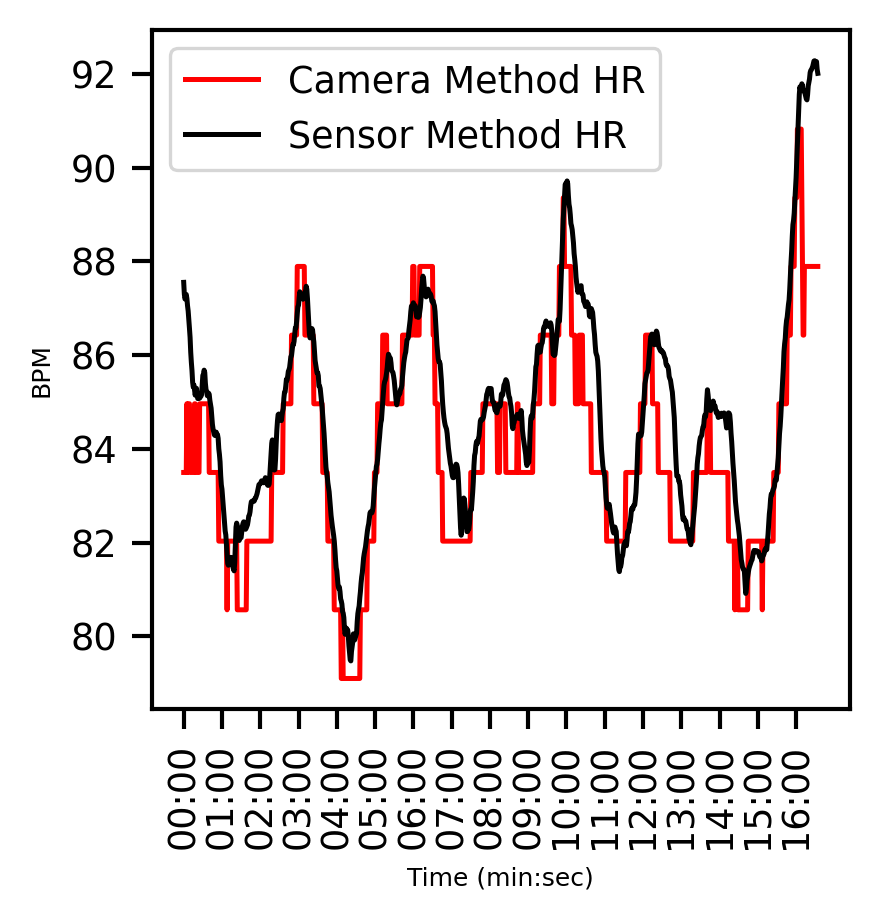

R_3Pp412MYdwnsxUl
81.75447550251256


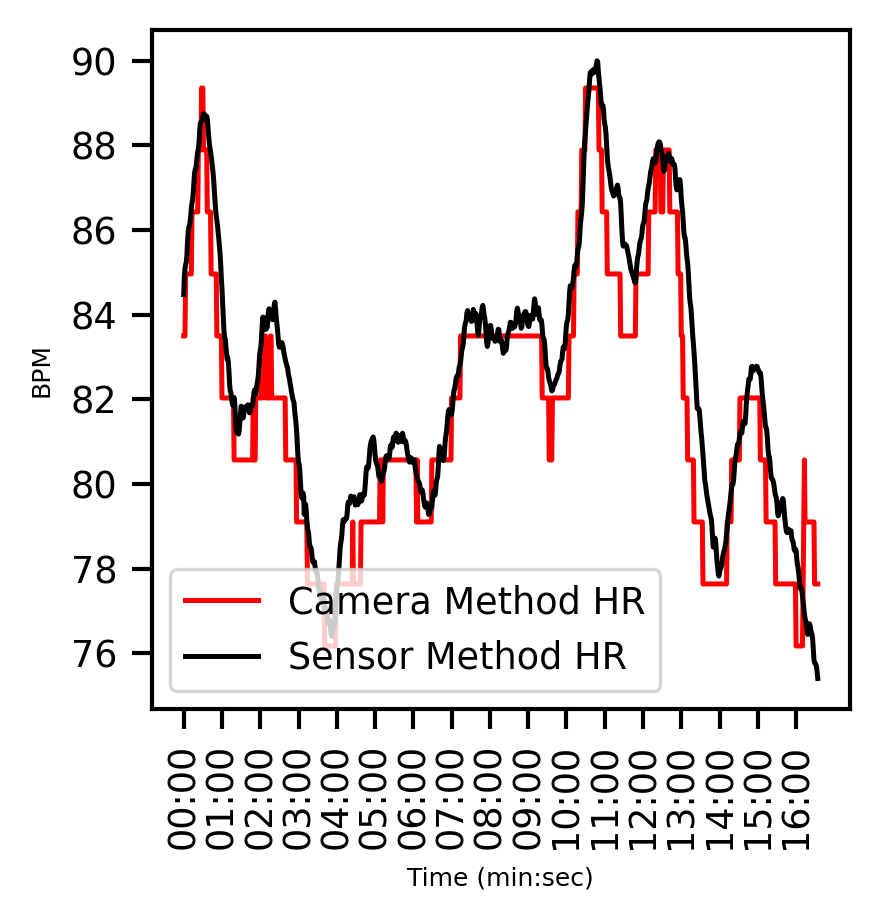

R_3qIhVrb3LVzuHTU
59.421129082914575


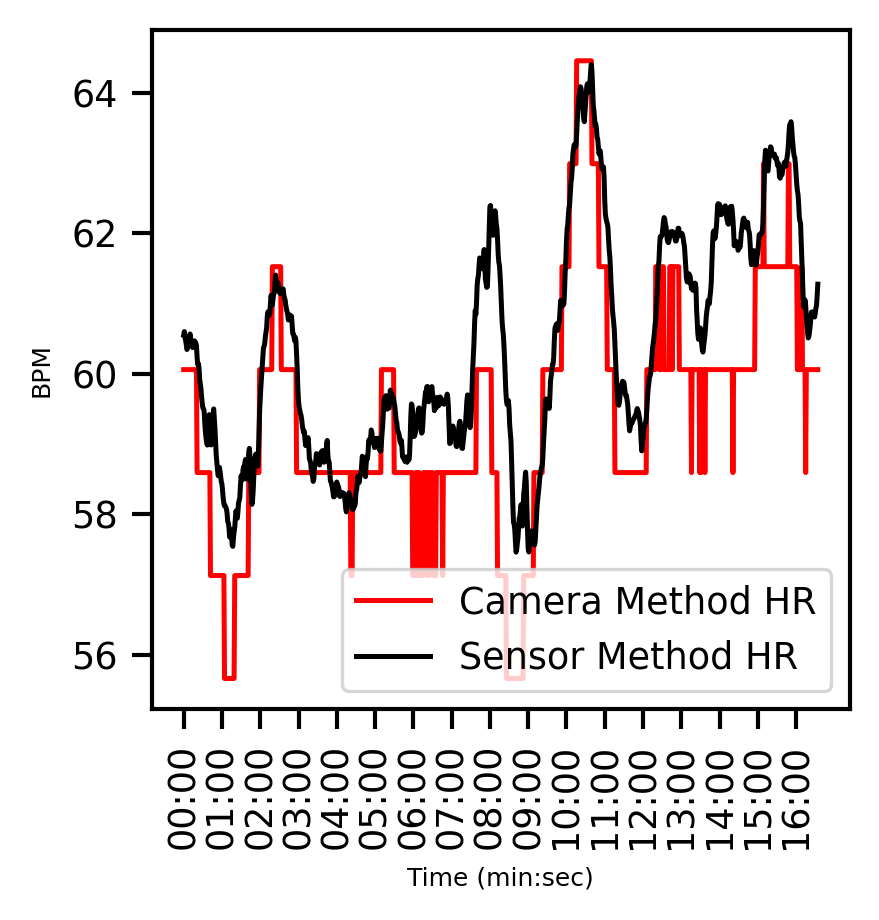

R_3Rl9l5rsjg6kyrB
53.42925565326633


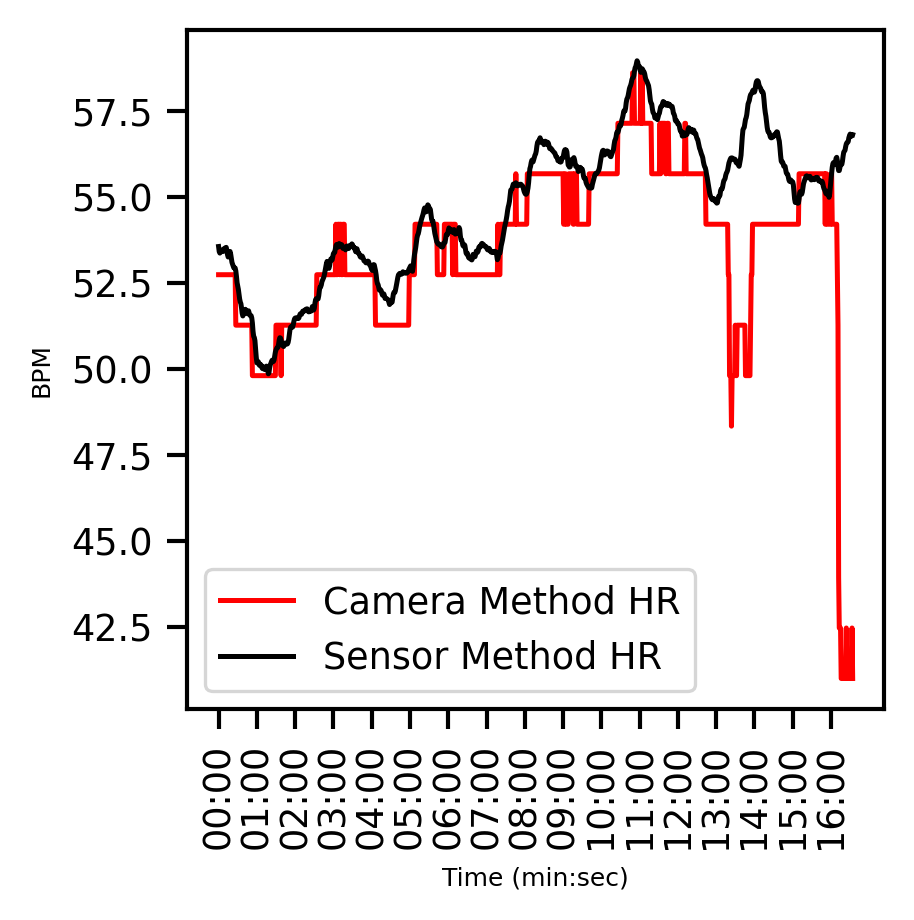

R_6mo4AaZoBPY18UV
72.37947550251256


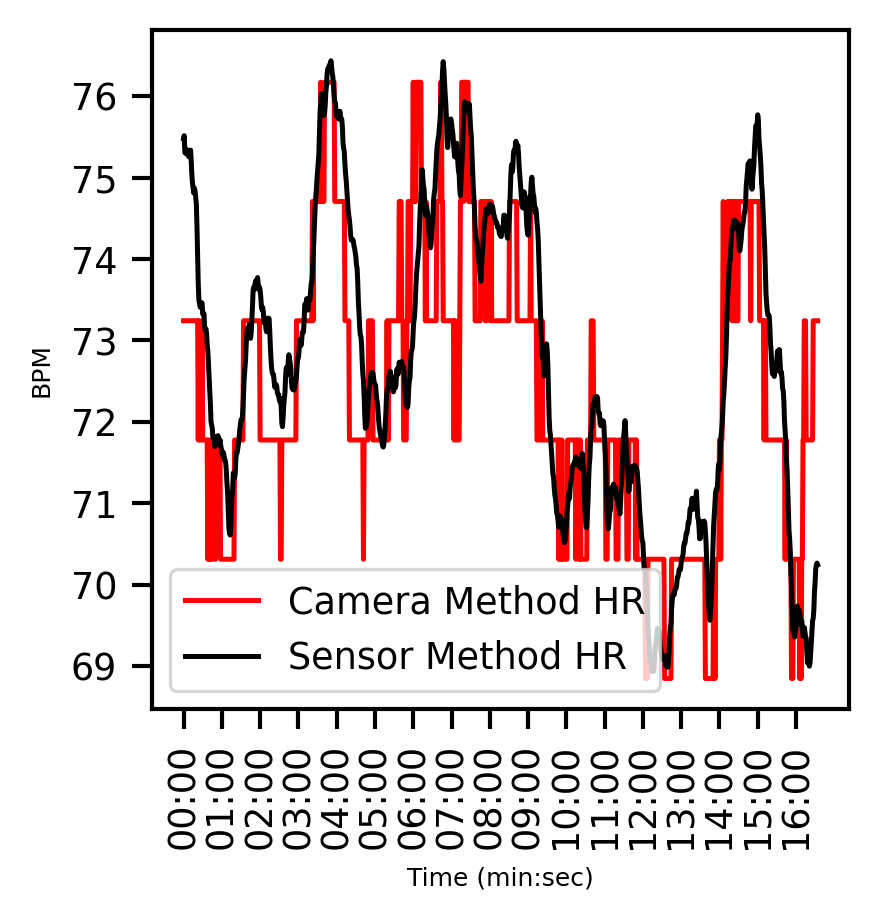

R_28TFqg64BSucSkg
73.30254789572864


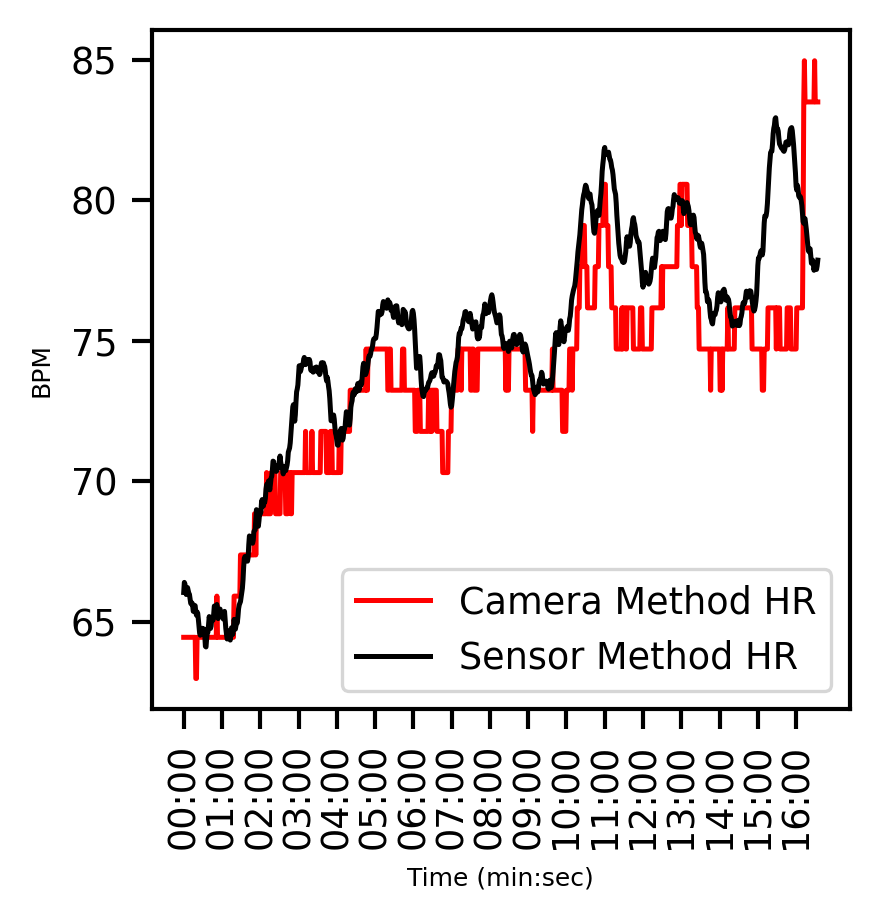

In [19]:
#plot HR data for all participants
for n in range(len(participants_working)):
    # Convert time from seconds to minutes
    time_in_minutes = np.arange(len(hr_est_working[n, :])) / 60
    
    # Plotting the data
    plt.plot(time_in_minutes, hr_est_working[n,:], color='red', label='Camera Method HR')
    plt.plot(time_in_minutes, hr_gt_working[n,:], color='black', label='Sensor Method HR')

    # Setting titles and labels
    #plt.title(participants_working[n])
    plt.xlabel('Time (min:sec)')
    plt.ylabel('BPM')
    
    # Creating custom x-tick labels in the format 0:00, 1:00, 2:00, etc.
    max_time = np.ceil(max(time_in_minutes))
    tick_labels = [f"{int(minute):02d}:00" for minute in np.arange(0, max_time, 1)]
    
    # Setting the x-tick labels
    plt.xticks(np.arange(0, max_time, 1), tick_labels, rotation = 90)
    
    # Adding the legend
    plt.legend()
    
    # Display the plot
    print(participants_working[n])
    print(np.mean(hr_est_working[n,:]))
    plt.show()
    
    # Close the plot to avoid display issues in some environments
    plt.close()

 p: 0.49469
Difference in median:  0.020171486773427533


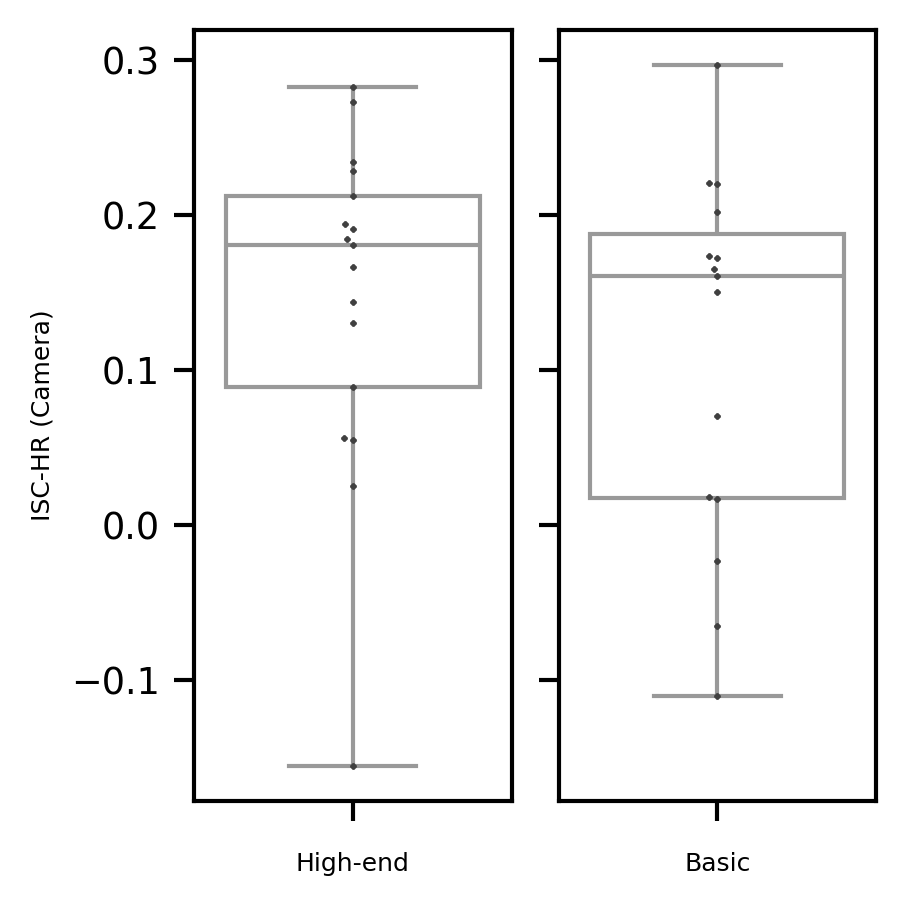

In [20]:
#ISC Between Groups Analysis For Camera Data
iscs_cam = check_isc_single_feature(hr_est_working) 

observed_difference, permuted_differences, p_value = permutation_isc_test(iscs_cam[groups == 'A'], iscs_cam[groups == 'B'])
print(f" p: {p_value:.5f}") 

grouped_values_cam = [iscs_cam[groups == 'A'], iscs_cam[groups == 'B']]
group_names_cam = ['High-end', 'Basic']

create_box_plots(grouped_values_cam, group_names_cam, "ISC-HR (Camera)", sharey = True)

print("Difference in median: ", abs(np.median(iscs_cam[groups == 'A']) - np.median(iscs_cam[groups == 'B'])))

 p: 0.11130


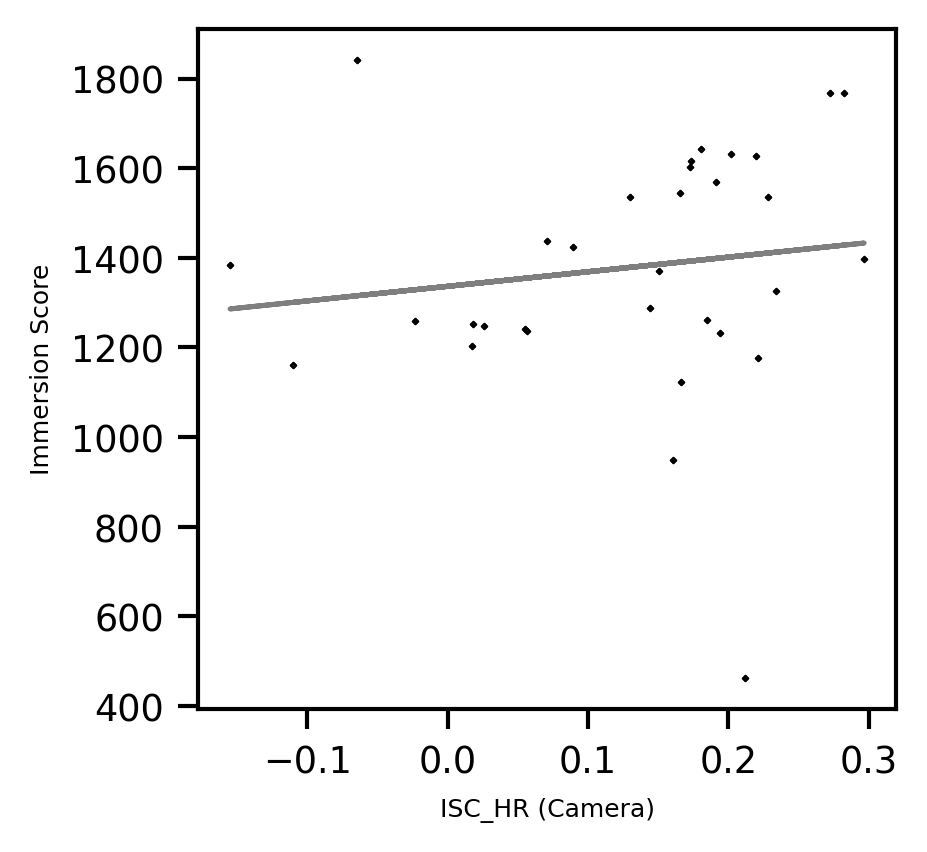

SignificanceResult(statistic=0.2897992863422366, pvalue=0.10764478209234607)


In [21]:
#ISC Correlation With Immersion Score Analysis For Camera Data
p_value, permuted_correlations, observed_correlation = permutation_correlation_test(hr_est_working, immersion_scores)
print(f" p: {p_value:.5f}") 

create_scatter_plot_with_regression(iscs_cam, immersion_scores, "ISC_HR (Camera)", "Immersion Score")
print(scipy.stats.spearmanr(iscs_cam, immersion_scores))

 p: 1.00000
Difference in median:  0.031582083233323205


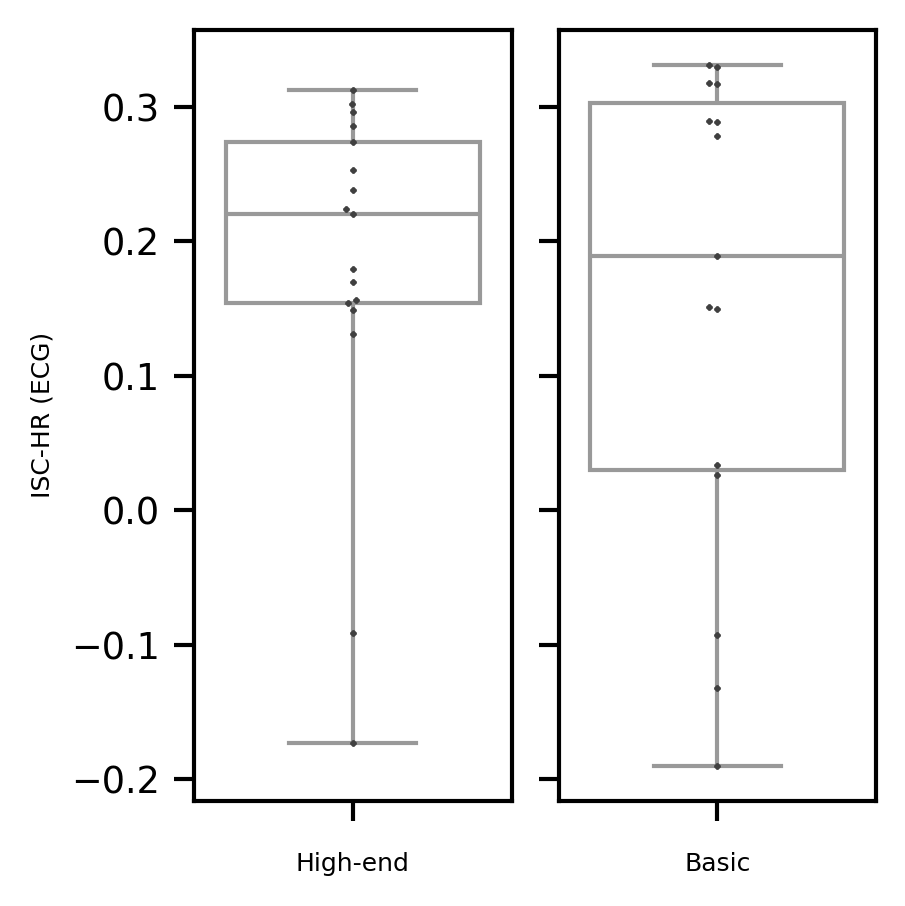

In [22]:
#ISC Between Groups Analysis For ECG Data
iscs_gt = check_isc_single_feature(hr_gt_working) 

observed_difference, permuted_differences, p_value = permutation_isc_test(iscs_gt[groups == 'A'], iscs_gt[groups == 'B'])
print(f" p: {p_value:.5f}") 

grouped_values_gt = [iscs_gt[groups == 'A'], iscs_gt[groups == 'B']]
group_names_gt = ['High-end', 'Basic']

create_box_plots(grouped_values_gt, group_names_gt, "ISC-HR (ECG)", sharey = True)

print("Difference in median: ", abs(np.median(iscs_gt[groups == 'A']) - np.median(iscs_gt[groups == 'B'])))

 p: 0.05510


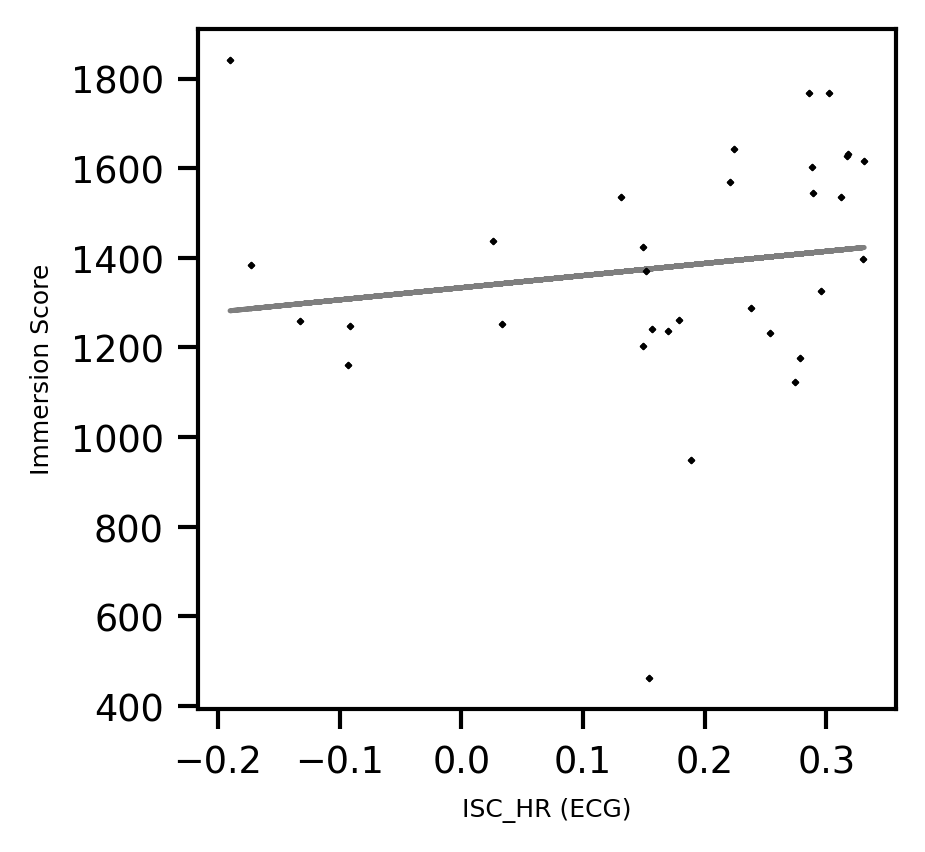

SignificanceResult(statistic=0.33874072179661807, pvalue=0.05789821237799129)


In [23]:
#ISC Correlation With Immersion Score Analysis For ECG Data
p_value, permuted_correlations, observed_correlation = permutation_correlation_test(hr_gt_working, immersion_scores)
print(f" p: {p_value:.5f}") 

create_scatter_plot_with_regression(iscs_gt, immersion_scores, "ISC_HR (ECG)", "Immersion Score")
print(scipy.stats.spearmanr(iscs_gt, immersion_scores))

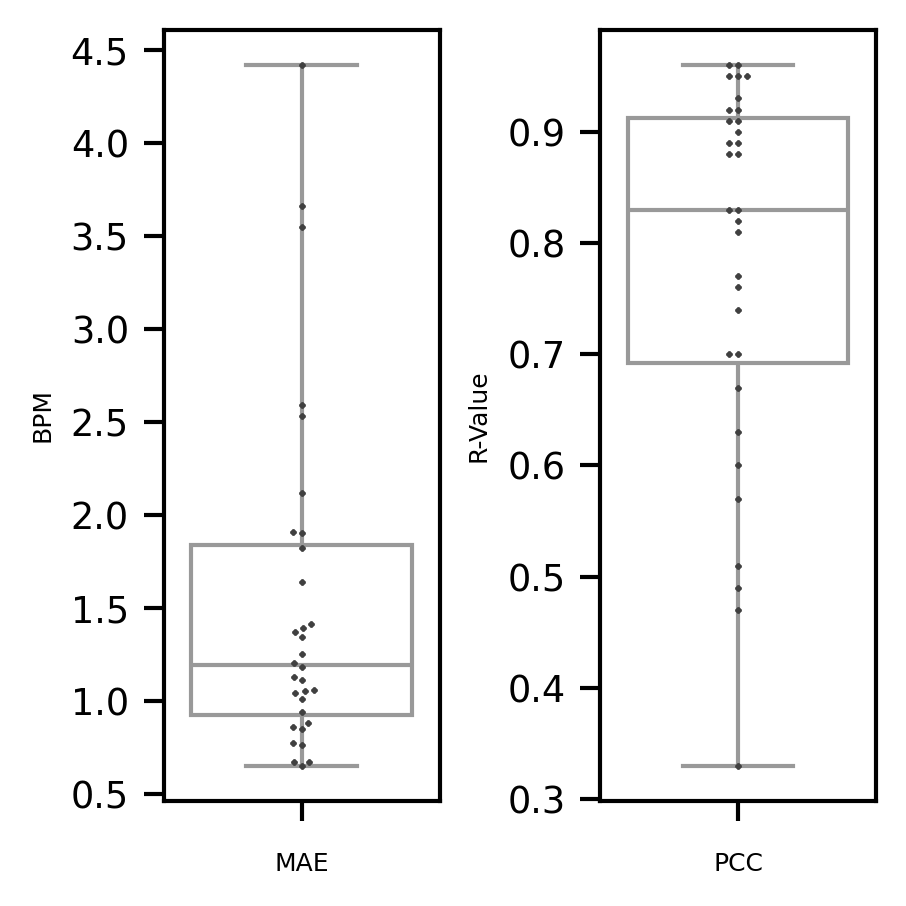

In [24]:
#Camera & Contact data comparison (MAE & PCC)
maes = np.zeros(len(participants_working))
pccs = np.zeros(len(participants_working))
ps = np.zeros(len(participants_working))

for n in range(len(participants_working)):
    maes[n], res = mae(hr_est_working[n,:], hr_gt_working[n,:])
    pccs[n], ps[n] = corr(hr_est_working[n,:], hr_gt_working[n,:])

grouped_values = [maes, pccs]
group_names = ['MAE', 'PCC']

create_box_plots(grouped_values, group_names, ["BPM", "R-Value"])

R: 0.899, p: 0.000


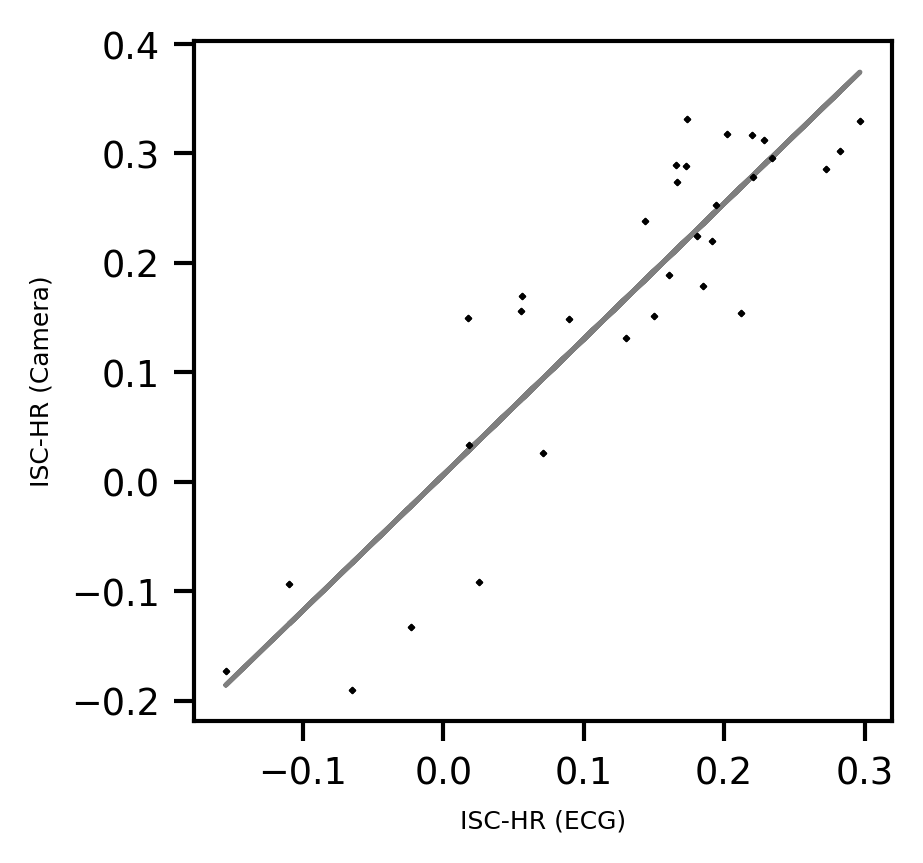

In [25]:
#correlation of ISC-HR feature for ECG and camera data
iscs_est = check_isc_single_feature(hr_est_working)
iscs_gt = check_isc_single_feature(hr_gt_working)

correlation, p_value = scipy.stats.pearsonr(iscs_est, iscs_gt)
print(f"R: {correlation:.3f}, p: {p_value:.3f}")

create_scatter_plot_with_regression(iscs_est, iscs_gt, "ISC-HR (ECG)", "ISC-HR (Camera)")

In [ ]:
#Any questions or queries? Email jw1858@york.ac.uk!